In [19]:
# import new_model_integration as model_mobster_mv
import model_mobster as model_mobster_mv
import numpy as np
import pandas as pd
import pyro.distributions as dist
import scipy.stats as stats
import torch
import pyro
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt

from utils.plot_functions import *
from utils.BoundedPareto import BoundedPareto
from utils.create_beta_pareto_dataset import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def beta_lk(mb,idx,  d, a_beta, b_beta):
    """
    Compute beta-binomial likelihood for a single dimension of a single cluster.
    """
    betabin = dist.BetaBinomial(a_beta, b_beta, total_count=mb.DP[idx,d]).log_prob(mb.NV[idx,d])
    return betabin # simply does log(weights) + log(density)

def expon_lk(mb, idx,  d):
    """
    Compute exponential likelihood for a single dimension of a single cluster.
    """
    exp = dist.Exponential(mb.rate_expon).log_prob(mb.NV[idx,d])
    return exp # simply does log(weights) + log(density)

def pareto_binomial_pmf(mb, NV, DP, alpha):
    integration_points=2000
    # Generate integration points across all rows at once
    t = torch.linspace(mb.pareto_L, mb.pareto_H, integration_points).unsqueeze(0)  # Shape (1, integration_points)
    NV_expanded = NV.unsqueeze(-1)  # Shape (NV.shape[0], NV.shape[1], 1)
    DP_expanded = DP.unsqueeze(-1)  # Shape (NV.shape[0], DP.shape[1], 1)
    binom_vals = dist.Binomial(total_count=DP_expanded, probs=t).log_prob(NV_expanded).exp()
    pareto_vals = BoundedPareto(mb.pareto_L, alpha, mb.pareto_H).log_prob(t).exp()  # Shape (1, integration_points)
    integrand = binom_vals * pareto_vals

    pmf_x = torch.trapz(integrand, t, dim=-1).log()  # Shape (NV.shape[0], NV.shape[1])

    return pmf_x.tolist()  # Convert the result to a list

def pareto_lk(mb, idx, d, alpha):
    paretobin = torch.tensor(pareto_binomial_pmf(mb, NV=mb.NV[idx, d], DP=mb.DP[idx, d], alpha=alpha))
    return paretobin # tensor of len N (if D = 1, only N)

### Synthetic samples

In [2]:
def euclidean_distance(a, b):
    return torch.dist(a, b)

# Define the Pareto-Binomial function
def pareto_binomial(N, alpha, L, H, depth):
    p = BoundedPareto(scale=L, alpha=alpha, upper_limit=H).sample((N,))
    bin = dist.Binomial(total_count=depth, probs=p).sample()
    min_bin = torch.ceil(L * depth)
    max_bin = torch.ceil(H * depth)
    # bin = torch.max(bin, min_bin)
    while torch.any(bin > max_bin):
        mask = bin > max_bin
        bin[mask] = dist.Binomial(total_count=depth[mask], probs=p[mask]).sample()
    while torch.any(bin < min_bin):
        mask = bin < min_bin
        bin[mask] = dist.Binomial(total_count=depth[mask], probs=p[mask]).sample()
        
    return bin


# Define the Beta-Binomial function
def beta_binomial(N, phi, kappa, depth, L):
    a = phi * kappa
    b = (1 - phi) * kappa
    p = dist.Beta(a, b).sample((N,))
    bin = dist.Binomial(total_count=depth, probs=p).sample()
    min_bin = torch.ceil(L * depth)
    while torch.any(bin < min_bin):
        mask = bin < min_bin
        bin[mask] = dist.Binomial(total_count=depth[mask], probs=p[mask]).sample()
    return bin

def sample_mixing_prop(K, min_value=0.05):
    while True: # loop until valid sample
        sample = dist.Dirichlet(torch.ones(K)).sample()
        if (sample > min_value).all():
            return sample


In [3]:
def generate_data_new_model(N, K, pi, D, purity, coverage):
    NV = torch.zeros((N, D))
    threshold=0.15
    cluster_labels = torch.zeros(N)  # one-dimensional labels, one per data
    type_labels_data = torch.zeros((N, D))  # D-dimensional labels, one per data
    type_labels_cluster = torch.zeros((K, D))  # D-dimensional label, one per cluster
    phi_param_data = torch.zeros((N, D))
    kappa_param_data = torch.zeros((N, D))
    alpha_param_data = torch.zeros((N, D))
    phi_param_cluster = torch.zeros((K, D))
    kappa_param_cluster = torch.zeros((K, D))
    alpha_param_cluster = torch.zeros((K, D))
    max_vaf = purity/2
    min_phi = 0.12
    probs_pareto = 0.08
    pareto_L = torch.tensor(0.05)  # Scale Pareto
    pareto_H = torch.tensor(max_vaf)  # Upper bound Pareto
    # variance_negbin = 1000
    # mean_negbin = coverage
    # probs_negbin = mean_negbin/variance_negbin
    # n_negbin = mean_negbin**2/(variance_negbin-mean_negbin)
    # neg_bin = stats.nbinom.rvs(n_negbin, probs_negbin, size=N*D)
    # depth = torch.tensor(neg_bin).reshape([N,D])
    depth = dist.Poisson(coverage).sample([N,D])

    sampled_phi_list = []

    # Always have a Beta-Binomial component with phi=max_vaf in all dimensions
    k = 0
    for d in range(D):
        p = max_vaf
        kappa = dist.Uniform(90, 350).sample()
        NV[:pi[k], d] = beta_binomial(pi[k], p, kappa, depth[:pi[k],d], pareto_L)
        type_labels_data[:pi[k], d] = torch.tensor(1)  # beta
        type_labels_cluster[k, d] = torch.tensor(1)  # beta
        phi_param_data[:pi[k], d] = p
        kappa_param_data[:pi[k], d] = round(kappa.item(), 3)
        alpha_param_data[:pi[k], d] = -1
        phi_param_cluster[k, d] = p
        kappa_param_cluster[k, d] = round(kappa.item(), 3)
        alpha_param_cluster[k, d] = -1
    cluster_labels[:pi[k]] = k  # cluster k
    sampled_phi_list.append(torch.tensor([p] * D))

    # Always have a Pareto-Binomial component in all dimensions
    k = 1

    init_idx = np.sum(pi[:k])
    end_idx = init_idx + pi[k]
    for d in range(D):
        alpha = dist.Uniform(0.8, 1.5).sample()  # Pareto shape parameter
        NV[init_idx:end_idx, d] = pareto_binomial(pi[k], alpha, pareto_L, pareto_H, depth[init_idx:end_idx, d])
        type_labels_data[init_idx:end_idx, d] = torch.tensor(0)  # pareto
        type_labels_cluster[k, d] = torch.tensor(0)  # pareto
        phi_param_data[init_idx:end_idx, d] = -1
        kappa_param_data[init_idx:end_idx, d] = -1
        alpha_param_data[init_idx:end_idx, d] = round(alpha.item(), 3)
        phi_param_cluster[k, d] = -1
        kappa_param_cluster[k, d] = -1
        alpha_param_cluster[k, d] = round(alpha.item(), 3)
    cluster_labels[init_idx:end_idx] = k  # cluster k
    sampled_phi_list.append(torch.tensor([probs_pareto] * D))

    # Randomly sample from Beta-Binomial, Pareto-Binomial or Zeros for additional components
    for k in range(2, K):
        init_idx = np.sum(pi[:k])
        end_idx = init_idx + pi[k]
        pareto_count = 0
        zeros_count = 0
        cluster_labels[init_idx:end_idx] = k  # cluster k
        while True:
            curr_sampled_phi = []
            for d in range(D):
                choose_dist = torch.randint(1, 4, (1,)).item() # randomly sample a value between 1, 2 or 3
                if choose_dist == 1:
                    phi, kappa = dist.Uniform(min_phi, max_vaf).sample(), dist.Uniform(150, 350).sample()
                    NV[init_idx:end_idx, d] = beta_binomial(pi[k], phi, kappa, depth[init_idx:end_idx, d],pareto_L)
                    type_labels_data[init_idx:end_idx, d] = torch.tensor(1)  # beta
                    type_labels_cluster[k, d] = torch.tensor(1)  # beta
                    phi_param_data[init_idx:end_idx, d] = round(phi.item(), 3)
                    kappa_param_data[init_idx:end_idx, d] = round(kappa.item(), 3)
                    alpha_param_data[init_idx:end_idx, d] = -1
                    phi_param_cluster[k, d] = round(phi.item(), 3)
                    kappa_param_cluster[k, d] = round(kappa.item(), 3)
                    alpha_param_cluster[k, d] = -1
                    curr_sampled_phi.append(phi)
                elif choose_dist == 2: # Pareto-Binomial for this dimension
                    if pareto_count >= (D-1): 
                        # if the number of pareto dimensions are already D-1 (all but 1), then sample either a beta or zeros
                        if torch.rand(1).item() < 0.5 and zeros_count < (D-1): # zeros
                            phi = 0
                            type_labels_cluster[k, d] = torch.tensor(2)  # zeros
                            NV[init_idx:end_idx, d] = phi
                            phi_param_data[init_idx:end_idx, d] = -1
                            kappa_param_data[init_idx:end_idx, d] = -1
                            alpha_param_data[init_idx:end_idx, d] = -1
                            phi_param_cluster[k, d] = -1
                            kappa_param_cluster[k, d] = -1
                            alpha_param_cluster[k, d] = -1
                            zeros_count += 1
                            curr_sampled_phi.append(phi)                            
                        else: # beta
                            phi, kappa = dist.Uniform(min_phi, max_vaf).sample(), dist.Uniform(150, 350).sample()
                            NV[init_idx:end_idx, d] = beta_binomial(pi[k], phi, kappa, depth[init_idx:end_idx, d],pareto_L)
                            type_labels_data[init_idx:end_idx, d] = torch.tensor(1)  # beta
                            type_labels_cluster[k, d] = torch.tensor(1)  # beta
                            phi_param_data[init_idx:end_idx, d] = round(phi.item(), 3)
                            kappa_param_data[init_idx:end_idx, d] = round(kappa.item(), 3)
                            alpha_param_data[init_idx:end_idx, d] = -1
                            phi_param_cluster[k, d] = round(phi.item(), 3)
                            kappa_param_cluster[k, d] = round(kappa.item(), 3)
                            alpha_param_cluster[k, d] = -1                            
                            curr_sampled_phi.append(phi)
                            
                    else: # pareto
                        alpha = dist.Uniform(0.8, 1.5).sample()
                        NV[init_idx:end_idx, d] = pareto_binomial(pi[k], alpha, pareto_L, pareto_H, depth[init_idx:end_idx, d])
                        type_labels_data[init_idx:end_idx, d] = torch.tensor(0)  # pareto
                        type_labels_cluster[k, d] = torch.tensor(0)  # pareto
                        phi_param_data[init_idx:end_idx, d] = -1
                        kappa_param_data[init_idx:end_idx, d] = -1
                        alpha_param_data[init_idx:end_idx, d] = round(alpha.item(), 3)
                        phi_param_cluster[k, d] = -1
                        kappa_param_cluster[k, d] = -1
                        alpha_param_cluster[k, d] = round(alpha.item(), 3)
                        pareto_count += 1
                        curr_sampled_phi.append(probs_pareto)
                elif choose_dist == 3: # Zeros for this dimension
                    if zeros_count >= (D-1): 
                        # if the number of zeros dimensions are already D-1 (all but 1), then sample either a beta or a pareto
                        # if torch.rand(1).item() < 0.5 and pareto_count < (D-1):  # zeros
                        if torch.rand(1).item() < 0.5:  # zeros
                            alpha = dist.Uniform(0.8, 1.5).sample()
                            NV[init_idx:end_idx, d] = pareto_binomial(pi[k], alpha, pareto_L, pareto_H, depth[init_idx:end_idx, d])
                            type_labels_data[init_idx:end_idx, d] = torch.tensor(0)  # pareto
                            type_labels_cluster[k, d] = torch.tensor(0)  # pareto
                            phi_param_data[init_idx:end_idx, d] = -1
                            kappa_param_data[init_idx:end_idx, d] = -1
                            alpha_param_data[init_idx:end_idx, d] = round(alpha.item(), 3)
                            phi_param_cluster[k, d] = -1
                            kappa_param_cluster[k, d] = -1
                            alpha_param_cluster[k, d] = round(alpha.item(), 3)
                            pareto_count += 1
                            curr_sampled_phi.append(probs_pareto)
                        else: # beta
                            phi, kappa = dist.Uniform(min_phi, max_vaf).sample(), dist.Uniform(150, 350).sample()
                            NV[init_idx:end_idx, d] = beta_binomial(pi[k], phi, kappa, depth[init_idx:end_idx, d],pareto_L)
                            type_labels_data[init_idx:end_idx, d] = torch.tensor(1)  # beta
                            type_labels_cluster[k, d] = torch.tensor(1)  # beta
                            phi_param_data[init_idx:end_idx, d] = round(phi.item(), 3)
                            kappa_param_data[init_idx:end_idx, d] = round(kappa.item(), 3)
                            alpha_param_data[init_idx:end_idx, d] = -1
                            phi_param_cluster[k, d] = round(phi.item(), 3)
                            kappa_param_cluster[k, d] = round(kappa.item(), 3)
                            alpha_param_cluster[k, d] = -1
                            curr_sampled_phi.append(phi)
                    else:
                        phi = 0
                        type_labels_cluster[k, d] = torch.tensor(2)  # zeros
                        NV[init_idx:end_idx, d] = phi
                        phi_param_data[init_idx:end_idx, d] = -1
                        kappa_param_data[init_idx:end_idx, d] = -1
                        alpha_param_data[init_idx:end_idx, d] = -1
                        phi_param_cluster[k, d] = -1
                        kappa_param_cluster[k, d] = -1
                        alpha_param_cluster[k, d] = -1
                        zeros_count += 1
                        curr_sampled_phi.append(pareto_L - threshold)

            
            # Convert curr_sampled_phi to a tensor
            curr_sampled_phi_tensor = torch.tensor(curr_sampled_phi)
            
            # Check if curr_sampled_phi list has a euclidean distance < threshold from all the already present element in sampled_phi_list:
            # if yes, add it to sampled_phi_list and go to the next iteration of k, otherwise repeat this loop over d
            
            # Check if the Euclidean distance is below the threshold for any sampled_phi in sampled_phi_list
            if all(euclidean_distance(curr_sampled_phi_tensor, phi) >= threshold for phi in sampled_phi_list):
                # If no element in sampled_phi_list is too close, add to sampled_phi_list and break the loop
                sampled_phi_list.append(curr_sampled_phi_tensor)
                break  # Move to the next cluster
    return NV, depth, cluster_labels, type_labels_data, type_labels_cluster, phi_param_data, kappa_param_data, alpha_param_data, phi_param_cluster, kappa_param_cluster, alpha_param_cluster

In [4]:
def plot_marginals_real(NV, DP, N, K, D, type_labels_cluster, cluster_labels, phi_beta, kappa_beta, alpha, idx):
    vaf = NV/DP
    copy_vaf = torch.clone(vaf)
    # Replace zeros with a large value that will not be considered as minimum (i.e. 1)
    masked_tensor = copy_vaf.masked_fill(vaf == 0, float(1.))

    # Find the minimum value for each column excluding zeros
    min_values, _ = torch.min(masked_tensor, dim=0)
    min_values = min_values.repeat(K, 1)
    pareto_L = torch.min(min_values)
    print(min_values, pareto_L)
    if K == 1:
        fig, axes = plt.subplots(K, NV.shape[1], figsize=(16, 4))
    else:
        fig, axes = plt.subplots(K, NV.shape[1], figsize=(16, K*3))
    if K == 1:
        axes = ax = np.array([axes])  # add an extra dimension to make it 2D
    plt.suptitle(f"Marginals with N = {N} and {K} clusters (i = {idx}) \n ")
    x = np.linspace(0.001, 1, 1000)
    for k in range(K):
        for d in range(D):
            maxx = type_labels_cluster[k, d]
            if maxx == 1:
                # plot beta
                a = phi_beta[k,d] * kappa_beta[k,d]
                b = (1-phi_beta[k,d]) * kappa_beta[k,d]
                pdf = beta.pdf(x, a, b)
                axes[k,d].plot(x, pdf, linewidth=1.5, label='Beta', color='r')
                axes[k,d].legend()
            elif maxx == 0:
                #plot pareto
                # print(alpha[k,d])
                pdf = pareto.pdf(x, alpha[k,d], scale=pareto_L)
                axes[k,d].plot(x, pdf, linewidth=1.5, label='Pareto', color='g')
                axes[k,d].legend()
            elif maxx == 2:
                # private
                a_beta_zeros = torch.tensor(1e-3)
                b_beta_zeros = torch.tensor(1e3)
                pdf = beta.pdf(x, a_beta_zeros, b_beta_zeros) # delta_approx
                axes[k,d].plot(x, pdf, linewidth=1.5, label='Zeros', color='b')
                axes[k,d].legend()
            
            if torch.is_tensor(NV):
                data = NV[:,d].numpy()/DP[:,d].numpy()
            else:
                data = np.array(NV[:,d])/np.array(DP[:,d])
            # data = mb.NV[:,d].numpy()/mb.DP[:,d].numpy()
            # for i in np.unique(labels):
            axes[k,d].hist(data[cluster_labels == k], density=True, bins=30, alpha=0.5)#, color=cmap(i))
            axes[k,d].set_title(f"Sample {d+1} - Cluster {k}")
            axes[k,d].set_xlim([-0.01,1])
            plt.tight_layout()
    # plt.savefig(f"plots/real_marginals/N_{N}_K_{K}_D_{D}_real_{idx}.png")
    plt.show()
    plt.close()


tensor([0.2609, 0.0700, 0.4551, 0.2139])
tensor([2609.4592,  700.1816, 4551.2007, 2139.1589])
np.sum(pi) 9999
tensor([[-1.0000, -1.0000],
        [ 1.1580,  1.1700],
        [-1.0000,  1.1640],
        [-1.0000, -1.0000]])


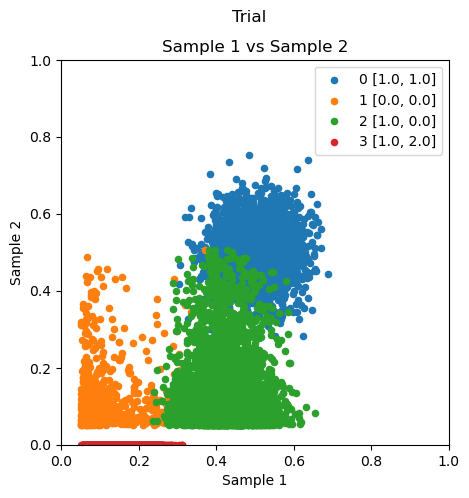

tensor([[0.0500, 0.0500],
        [0.0500, 0.0500],
        [0.0500, 0.0500],
        [0.0500, 0.0500]]) tensor(0.0500)


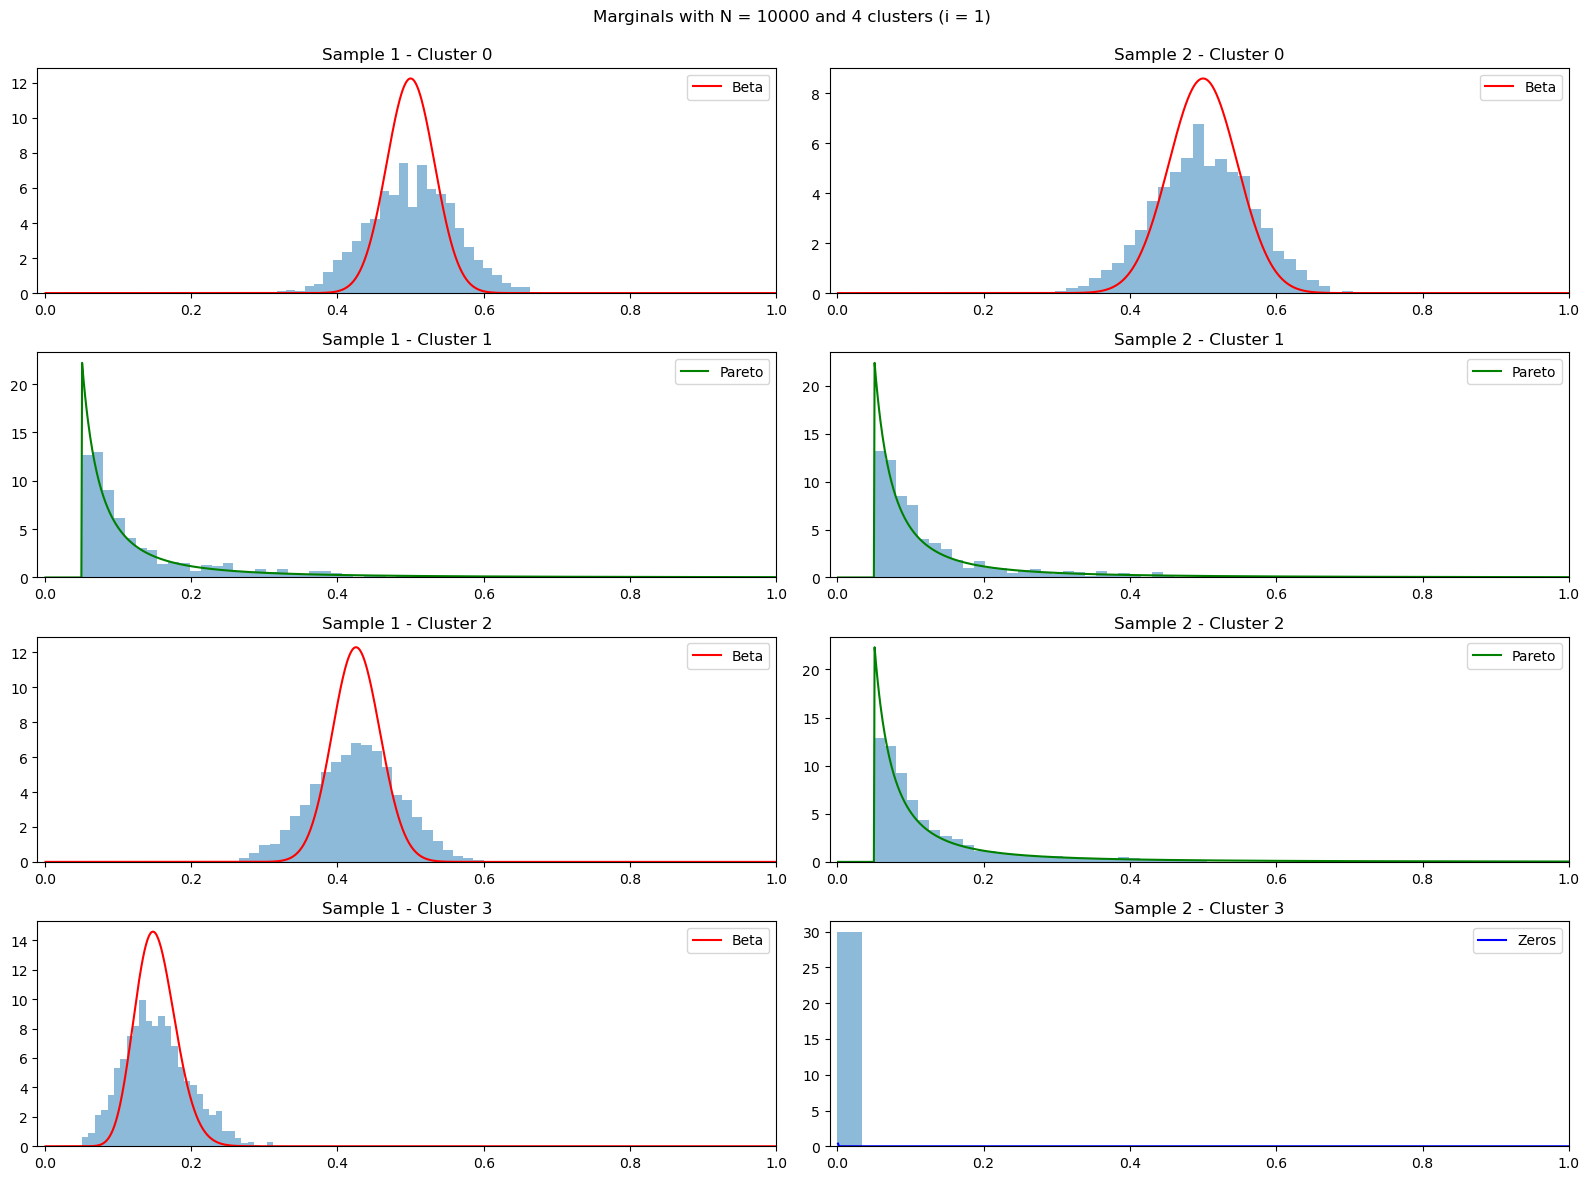

In [8]:
purity = 1
coverage = 100
N = 10000
K = 4
D = 2

seed1 = 40
# pyro.set_rng_seed(seed1)
# torch.manual_seed(seed1)
# np.random.seed(seed1)

# Sample mixing proportions for clusters and multiply by N to obtain the number of data in each cluster
pi = sample_mixing_prop(K) * N
print(pi/N)
print(pi)
# pi = dist.Dirichlet(torch.ones(K)).sample() * N  # Number of data in each cluster
pi = np.round(pi.numpy()).astype('int')

# Adjust proportions to ensure they sum to N
print("np.sum(pi)", np.sum(pi))
if np.sum(pi) < N:
    diff = N - np.sum(pi)
    pi[-1] += diff
elif np.sum(pi) > N:
    diff = np.sum(pi) - N
    pi[-1] -= diff
NV, DP, cluster_labels, type_labels_data, type_labels_cluster, phi_param_data, kappa_param_data, alpha_param_data, phi_param_cluster, kappa_param_cluster, alpha_param_cluster  = generate_data_new_model(N, K, pi, D, purity, coverage)
print(alpha_param_cluster)
pairs = np.triu_indices(D, k=1)  # Generate all unique pairs of samples (i, j)
vaf = NV/DP    
num_pairs = len(pairs[0])  # Number of unique pairs
ncols = min(3, num_pairs)
nrows = (num_pairs + ncols - 1) // ncols  # Calculate the number of rows

fig_width_per_plot = 5
fig_width = ncols * fig_width_per_plot
fig_height = 5 * nrows

fig, axes = plt.subplots(nrows, ncols, figsize=(fig_width, fig_height))
plt.suptitle('Trial')
if num_pairs == 1:
    axes = [axes]
else:
    axes = axes.flatten()

idx = 0
for i, j in zip(*pairs):
    ax = axes[idx]  # Select the appropriate subplot
    x = vaf[:, i].numpy()
    y = vaf[:, j].numpy()

    # ax.scatter(x, y, alpha=0.7)

    for c, cluster in enumerate(np.unique(cluster_labels)):
        mask = (cluster_labels == cluster)  # Mask for current cluster
        ax.scatter(x[mask], 
                    y[mask],
                    label=f'{cluster.astype("int")} {type_labels_cluster[c].tolist()}', s = 20)
    ax.legend(loc='best')
    ax.set_title(f"Sample {i+1} vs Sample {j+1}")
    ax.set_xlabel(f"Sample {i+1}")
    ax.set_ylabel(f"Sample {j+1}")
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    idx += 1

plt.show()
plt.close()

plot_marginals_real(NV, DP, N, K, D, type_labels_cluster, cluster_labels, phi_param_cluster, kappa_param_cluster, alpha_param_cluster, idx)

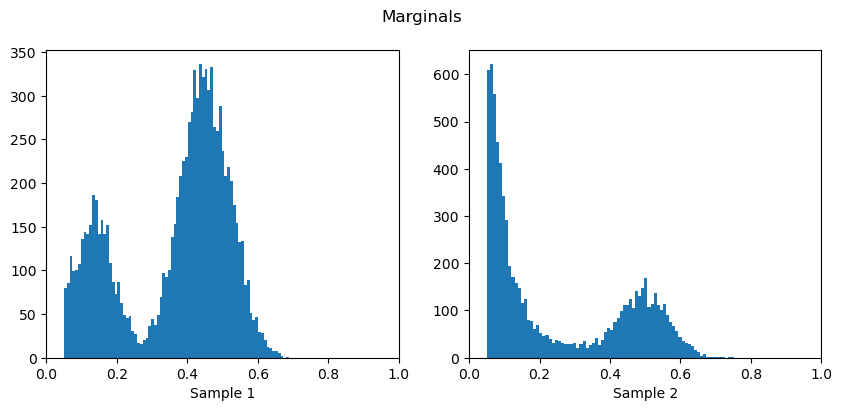

In [9]:
vaf = NV/DP
fig, axes = plt.subplots(1, D, figsize=(5*D, 4))
plt.suptitle("Marginals")

for i in range(D):
    x = vaf[:, i].numpy()
    x = x[x > 0]
    axes[i].hist(x, bins = 80)
    
    axes[i].set_xlabel(f"Sample {i+1}")
    axes[i].set_xlim([0,1])

plt.show()

In [13]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
inertia_list = []

seed = 12

K_range = range(3, 20)

bic_values = []
aic_values = []
data = (NV/DP).numpy()
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=seed, n_init=5).fit(data)
    centers = torch.tensor(kmeans.cluster_centers_)
    inertia = kmeans.inertia_
    # print('K = ', k, ': ', inertia)
    inertia_list.append(inertia)
    # print(k)
    gmm = GaussianMixture(n_components=k, random_state=seed).fit(data)
    bic = gmm.bic(data)
    aic = gmm.aic(data)
    bic_values.append(bic)
    aic_values.append(aic)
    print('K = ', k, ': ', bic, aic)

k_min_inertia = K_range[np.argmin(inertia_list)]
k_min_bic = K_range[np.argmin(bic_values)]
k_min_aic = K_range[np.argmin(aic_values)]

print(f"K min inertia: {k_min_inertia}")
print(f"K min BIC: {k_min_bic}")
print(f"K min AIC: {k_min_aic}")

K =  3 :  -35597.887236705035 -35720.46302302863
K =  4 :  -51852.503026207385 -52018.340854762835
K =  5 :  -53470.95323746519 -53680.0531082525
K =  6 :  -53792.47486124613 -54044.8367742653
K =  7 :  -54274.723594910756 -54570.34755016178
K =  8 :  -53859.59343978718 -54198.47943727006
K =  9 :  -54359.00654799408 -54741.15458770882
K =  10 :  -54338.232120045344 -54763.64220199194
K =  11 :  -54409.821867471954 -54878.49399165041
K =  12 :  -54229.93943006385 -54741.873596474165
K =  13 :  -54289.72308781618 -54844.91929645834
K =  14 :  -53983.45776486583 -54581.91601573985
K =  15 :  -53920.448925256664 -54562.16921836254
K =  16 :  -54221.06104323746 -54906.043378575196
K =  17 :  -54173.866214241185 -54902.11059181078
K =  18 :  -54182.392620492705 -54953.899040294156
K =  19 :  -54117.723649124724 -54932.49211115803
K min inertia: 19
K min BIC: 11
K min AIC: 18


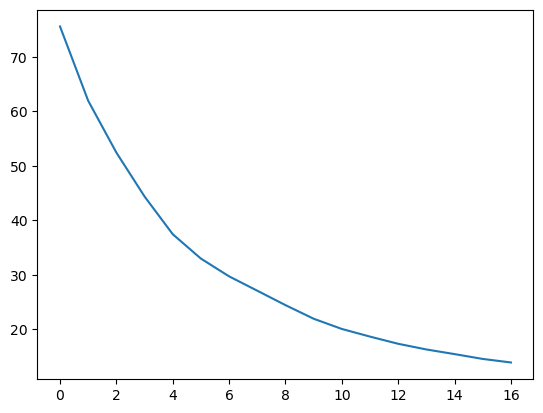

In [11]:
plt.plot(inertia_list)

In [53]:
mean = 0
std_dev = 0.08
D = NV.shape[1]
dist.Normal(mean, std_dev).sample([3, D])

tensor([[-0.0782,  0.0310],
        [-0.0691, -0.1269],
        [-0.0004, -0.0343]])

No GPU available.
RUN WITH K = 3 AND SEED = 40
Minimum detected VAF: tensor(0.0500)


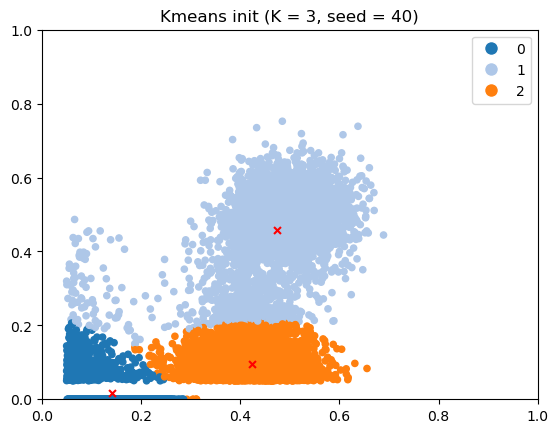

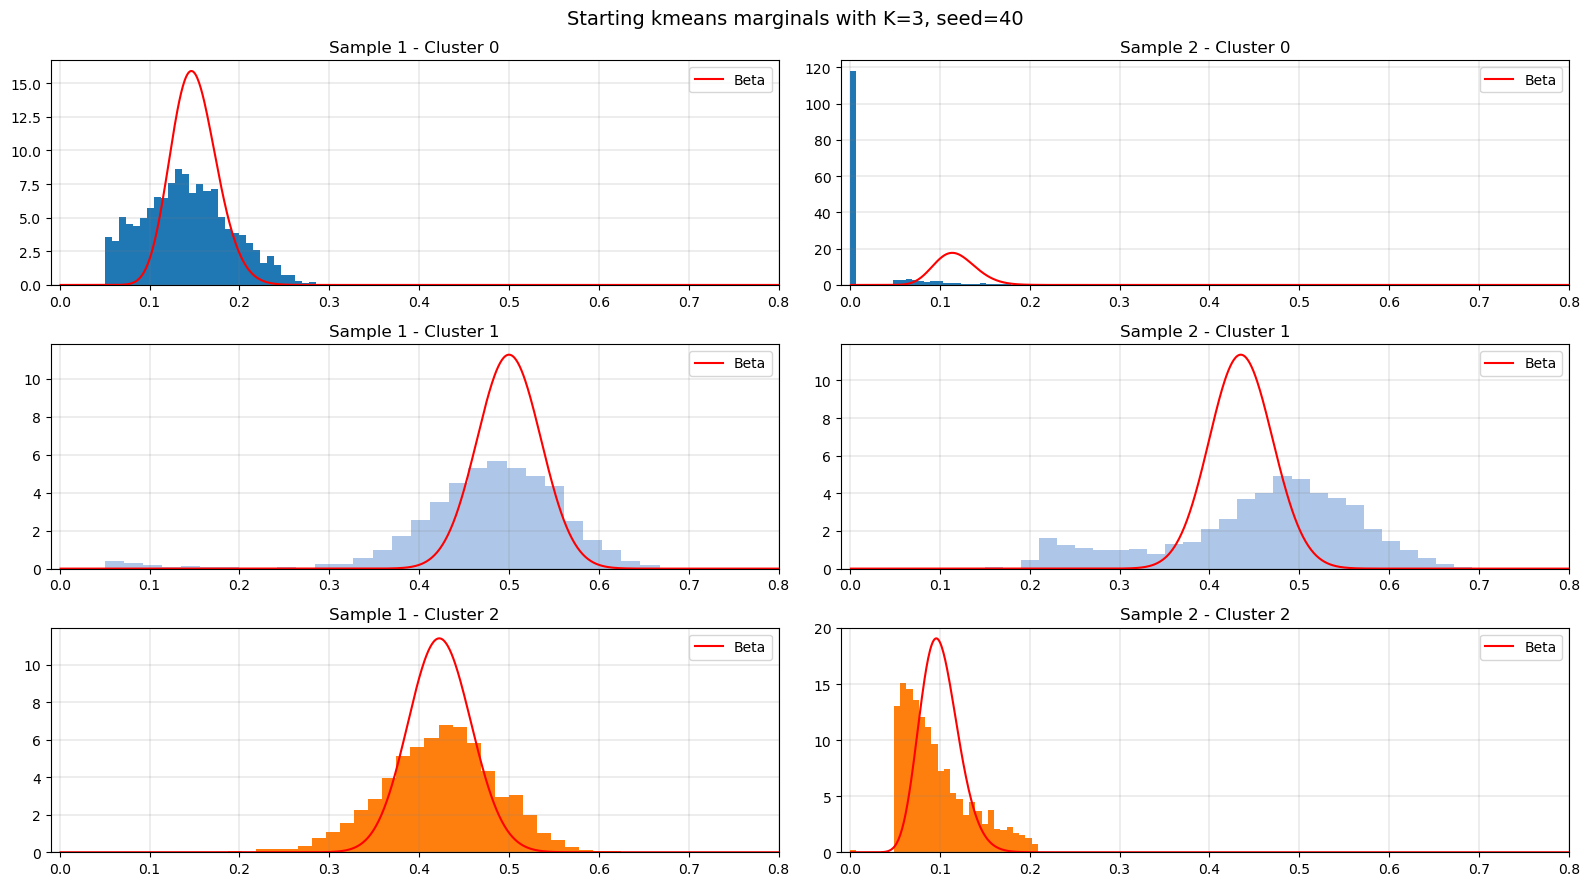

Iteration 0: Loss = 765897445.8137332
Iteration 50: Loss = 708475269.4225551
Iteration 100: Loss = 697504164.0243587
Iteration 150: Loss = 693940336.4874215
Iteration 200: Loss = 692011969.2749522
Iteration 250: Loss = 690757531.8866266
Iteration 300: Loss = 689800662.5113686
Iteration 350: Loss = 689063851.7670623


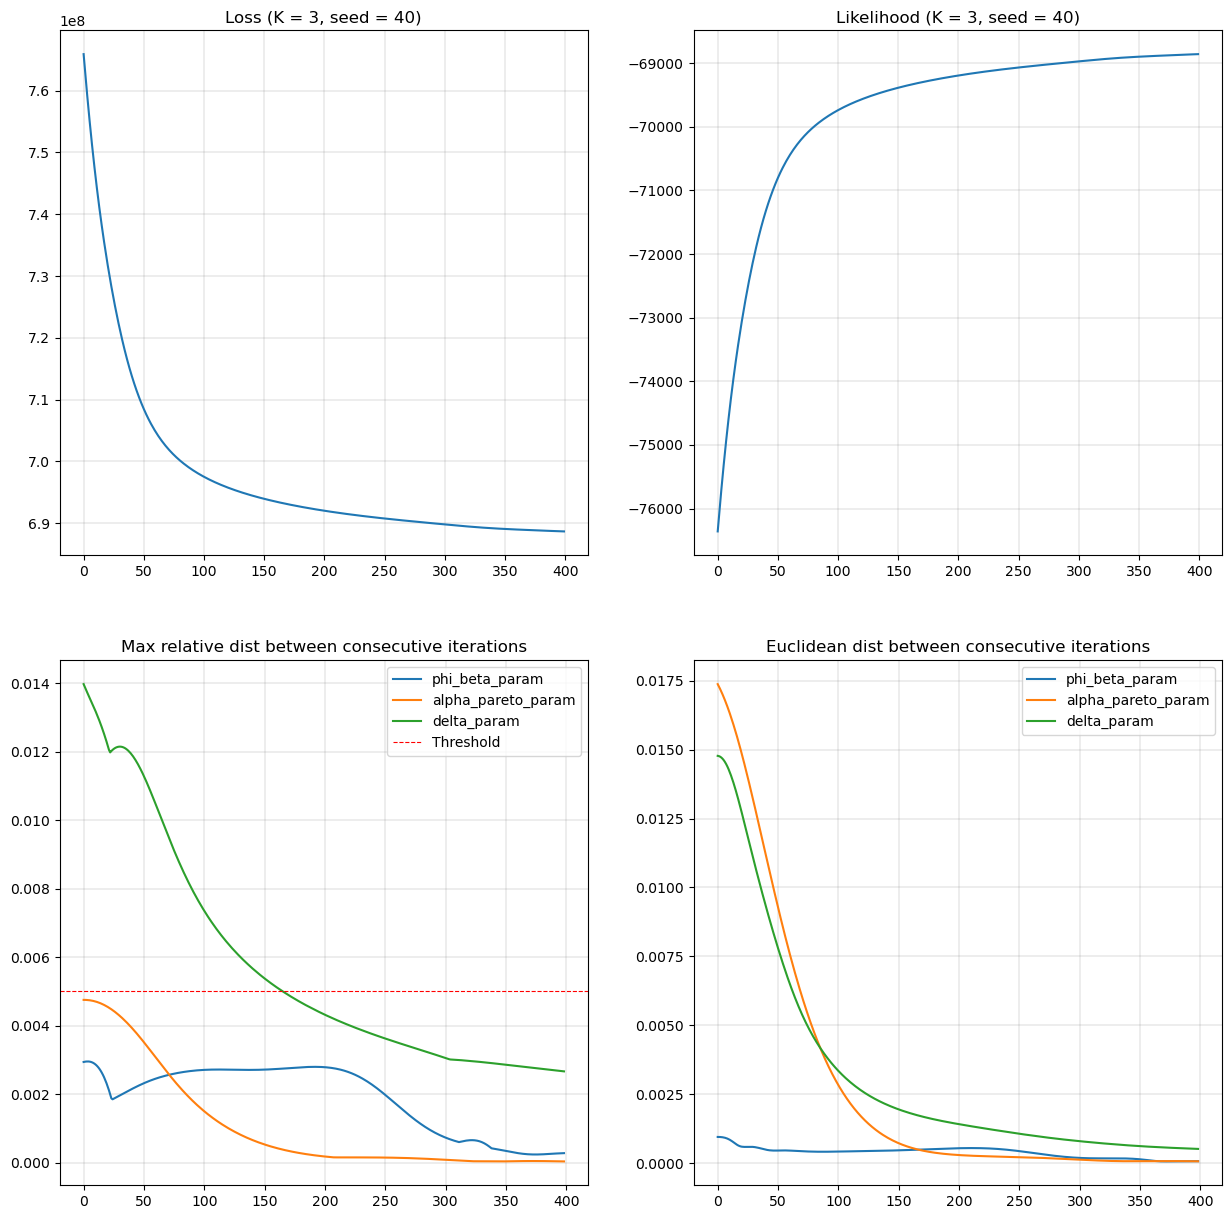

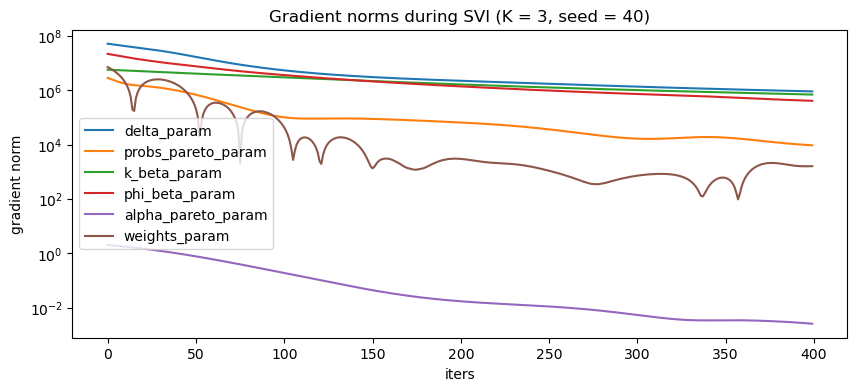

Inference lk:  -68857.92896298484
Final lk (integr):  tensor(-78062.4297, grad_fn=<SumBackward0>)
n_params:  45
n:  tensor(10000)
lk:  tensor(-78062.4297, grad_fn=<SumBackward0>)
bic: 156539.328125 



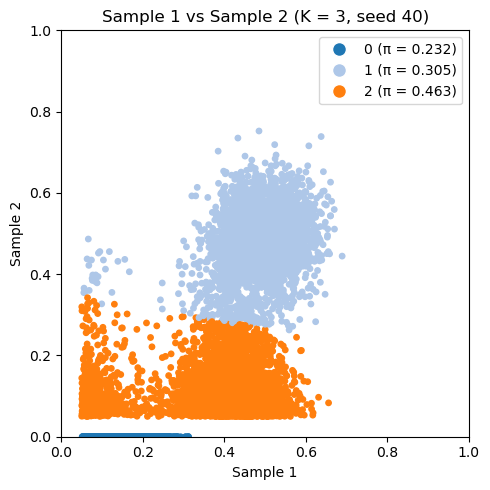

Time taken for K = 3 and seed = 40: 11.537 seconds
RUN WITH K = 3 AND SEED = 41
Minimum detected VAF: tensor(0.0500)


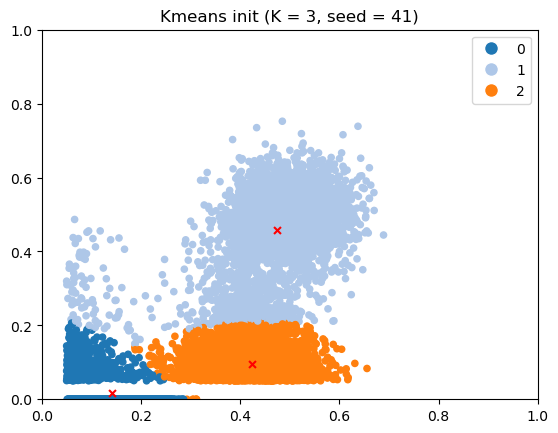

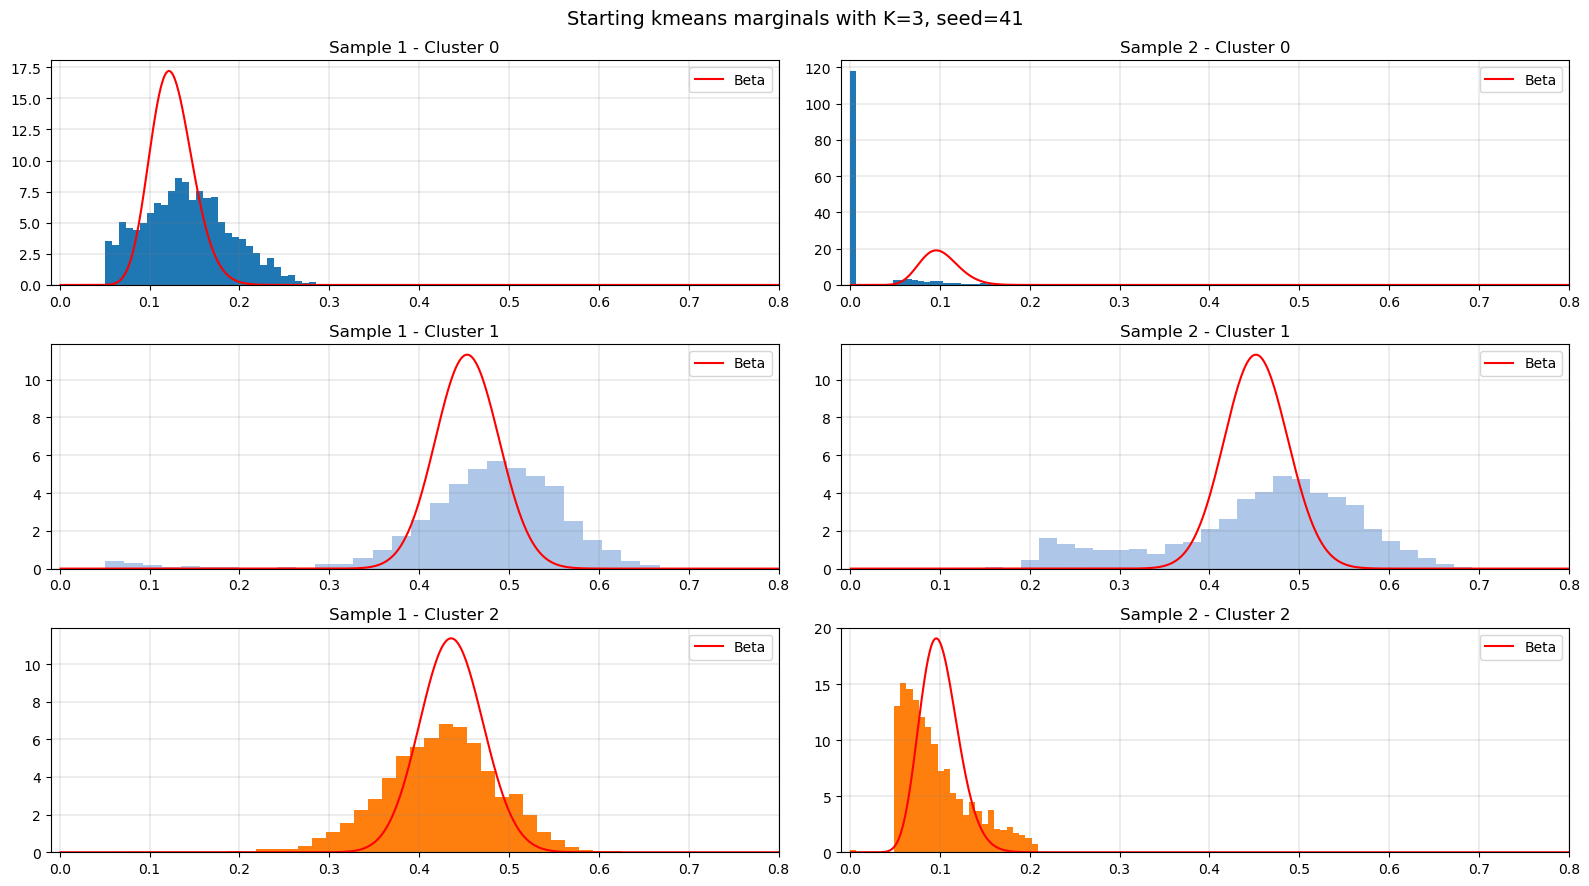

Iteration 0: Loss = 773969573.3445475
Iteration 50: Loss = 709686970.0455048
Iteration 100: Loss = 697750424.6436517
Iteration 150: Loss = 694218140.1320243
Iteration 200: Loss = 692340891.8123783
Iteration 250: Loss = 691136442.6865923
Iteration 300: Loss = 690221920.1628804
Iteration 350: Loss = 689514257.2403362
Iteration 400: Loss = 689006235.644071
Iteration 450: Loss = 688549339.21155
Iteration 500: Loss = 688270952.7849855
Iteration 550: Loss = 688068415.6864468
Iteration 600: Loss = 687902794.8104402
Iteration 650: Loss = 687761440.4897517


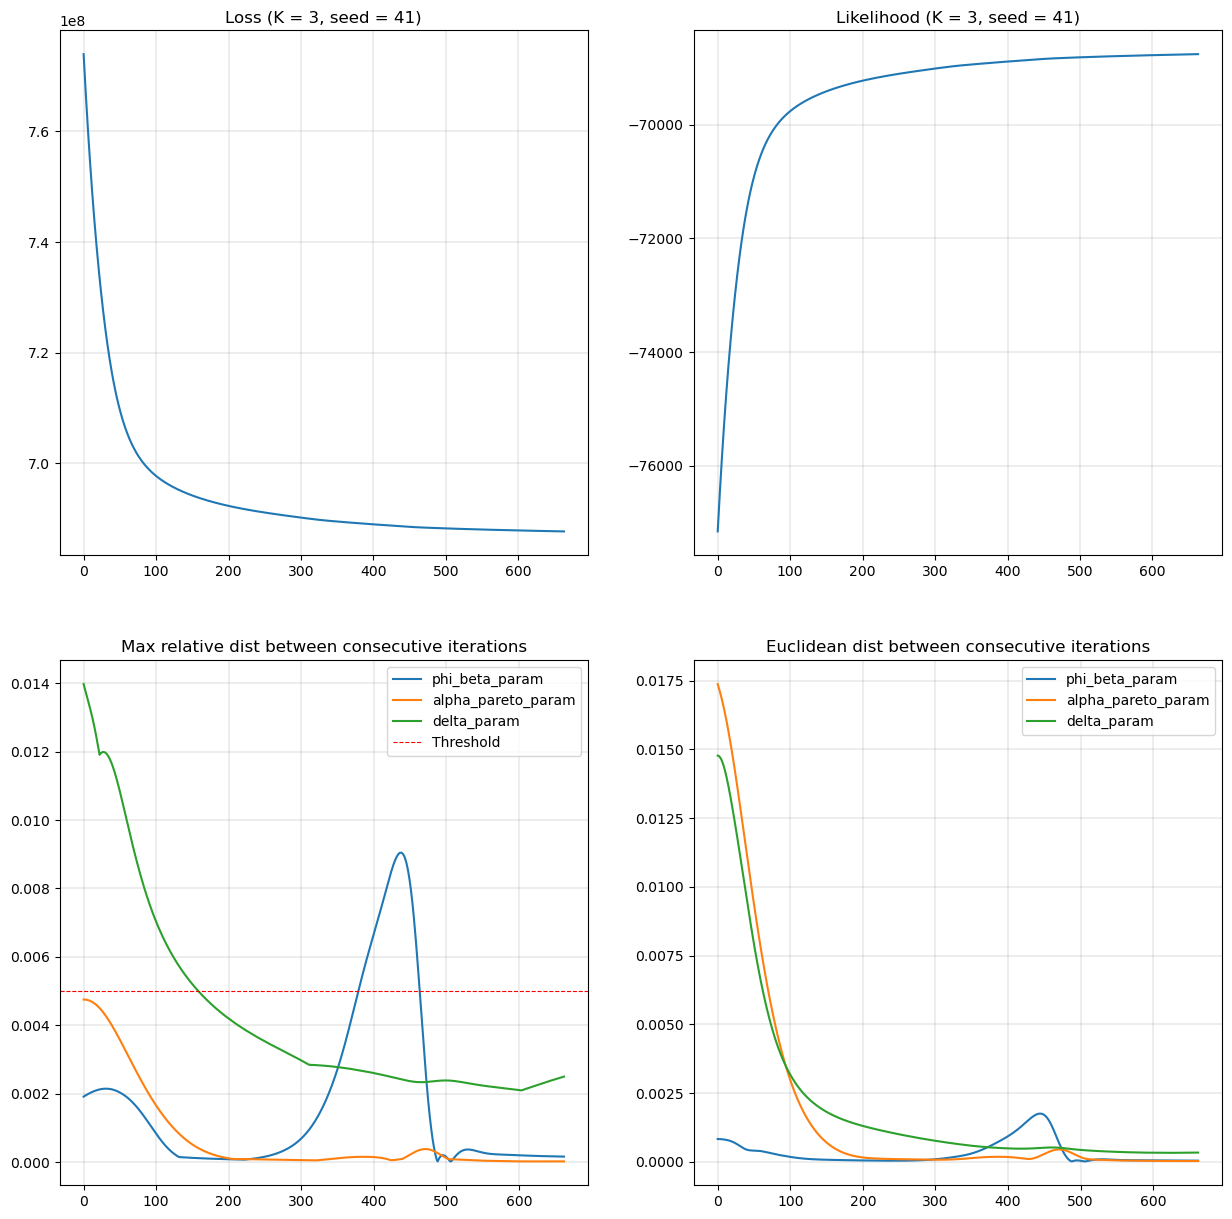

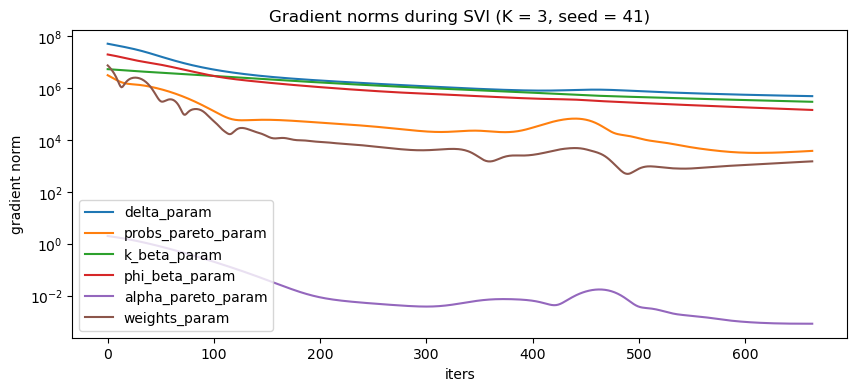

Inference lk:  -68759.6810429671
Final lk (integr):  tensor(-77928.0547, grad_fn=<SumBackward0>)
n_params:  45
n:  tensor(10000)
lk:  tensor(-77928.0547, grad_fn=<SumBackward0>)
bic: 156270.578125 



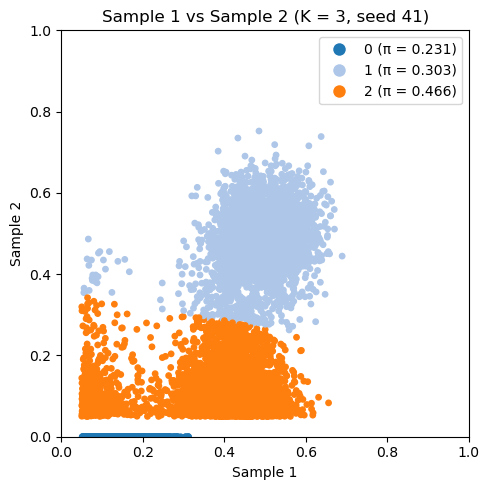

Time taken for K = 3 and seed = 41: 16.696 seconds


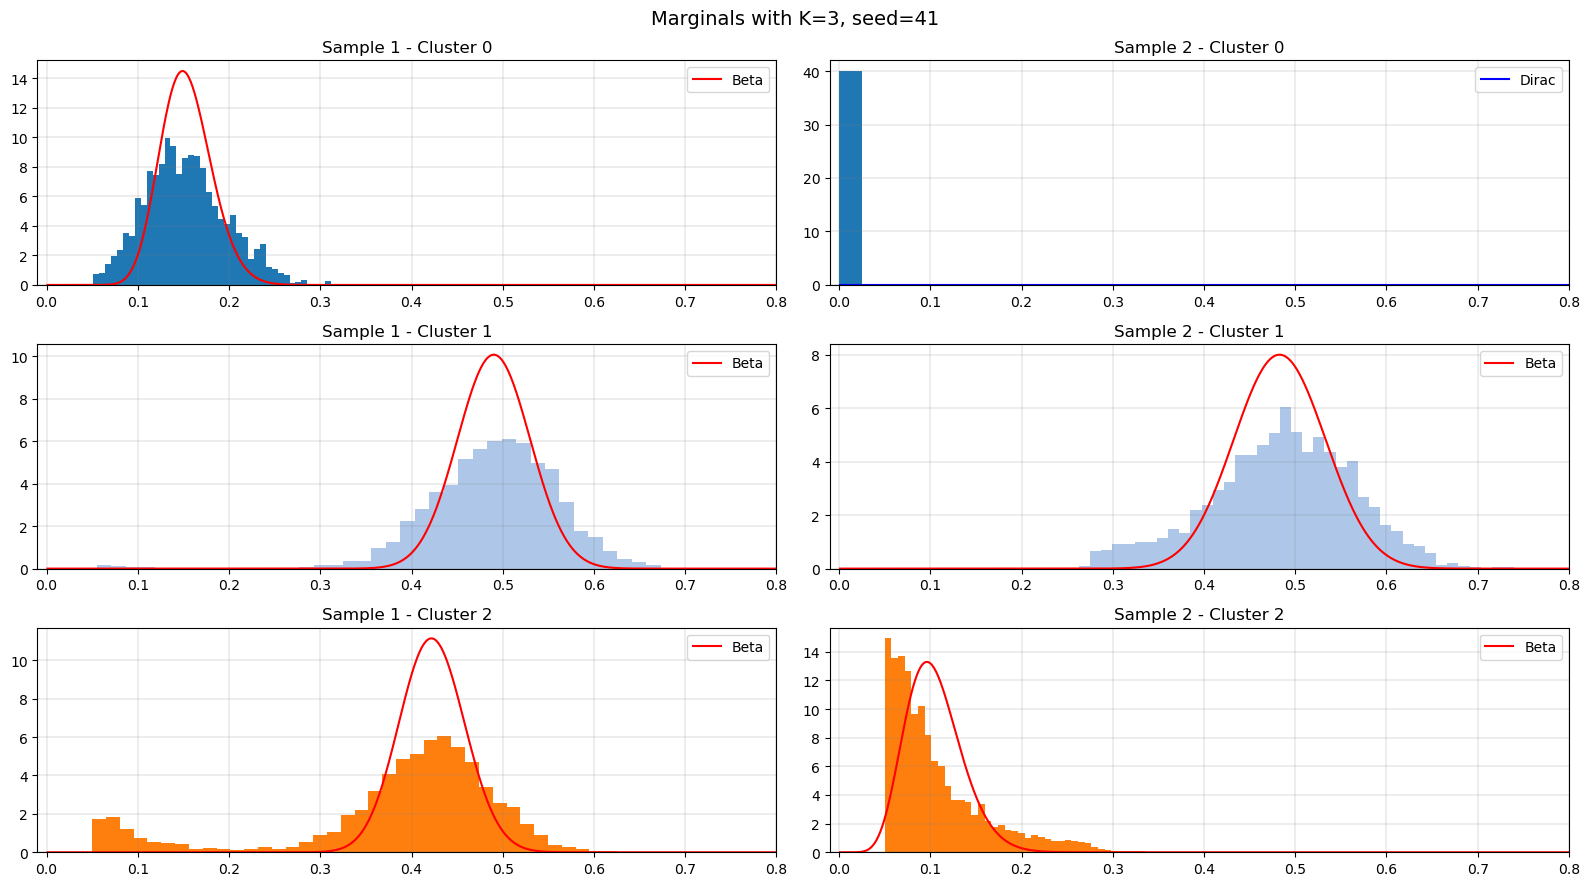

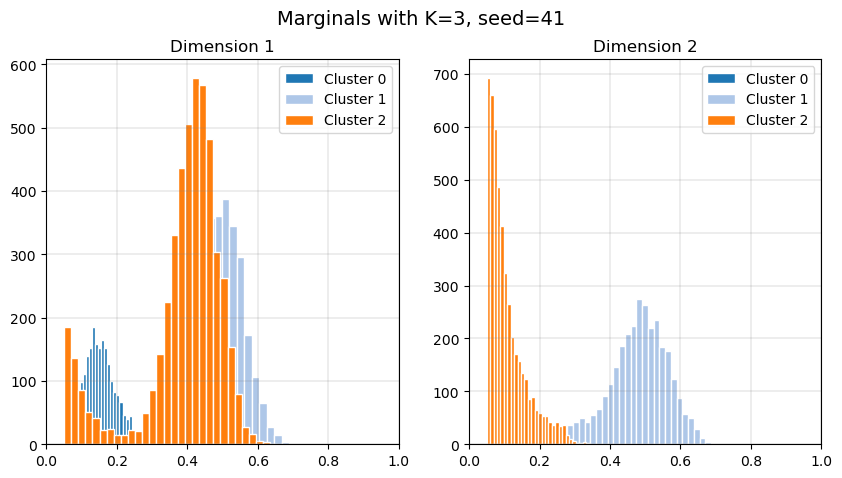

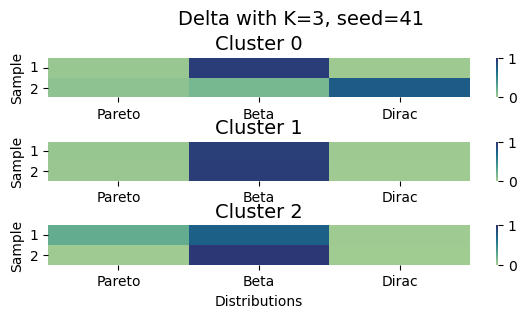

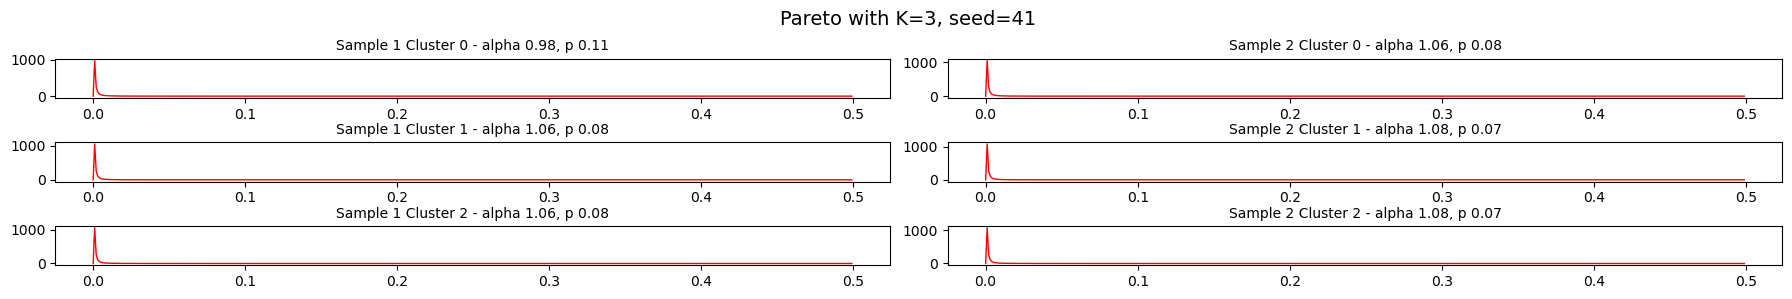

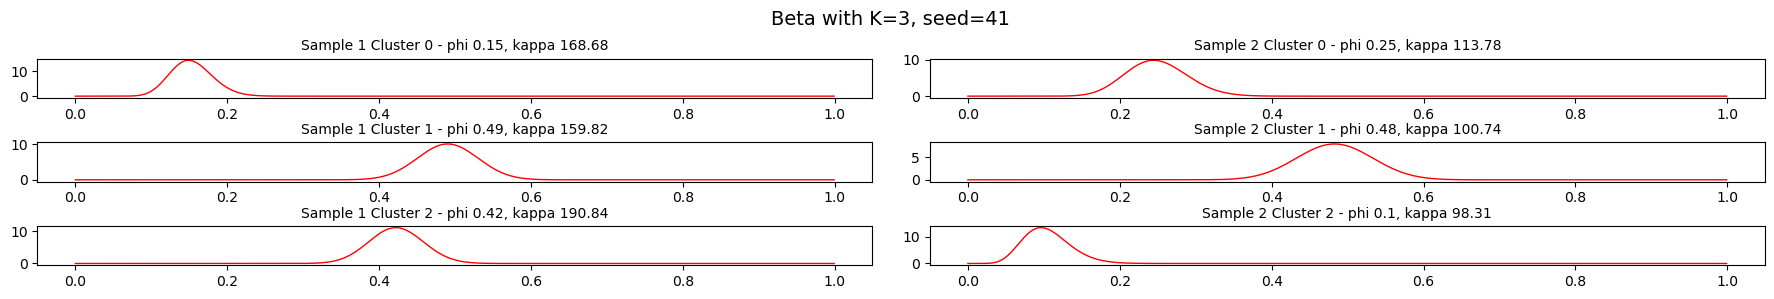

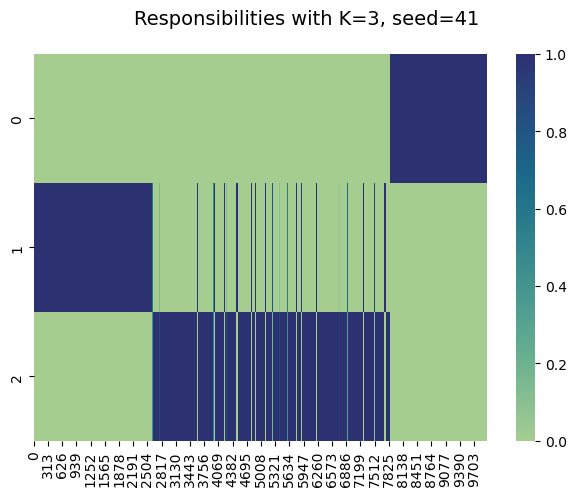

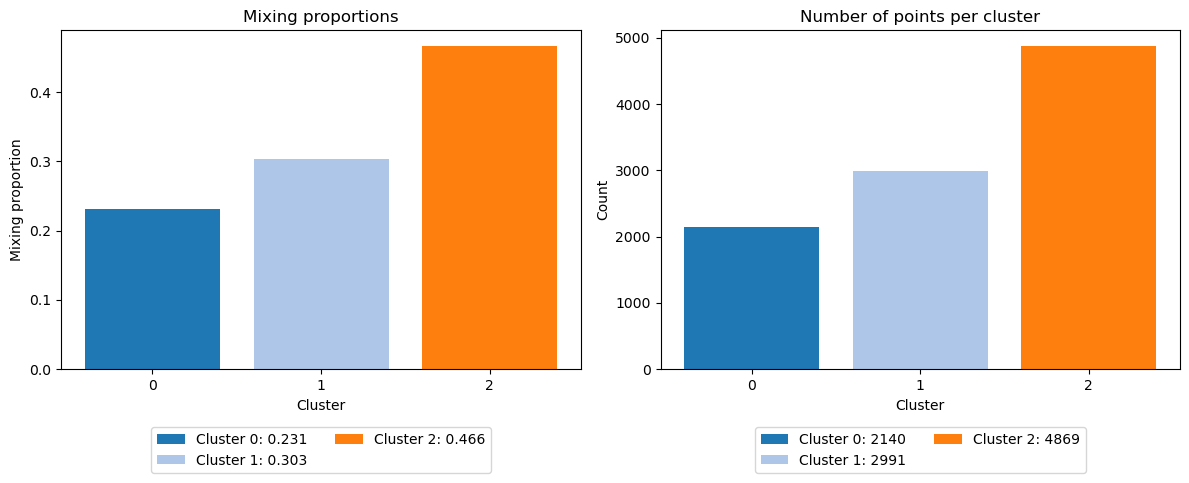

RUN WITH K = 4 AND SEED = 40
Minimum detected VAF: tensor(0.0500)


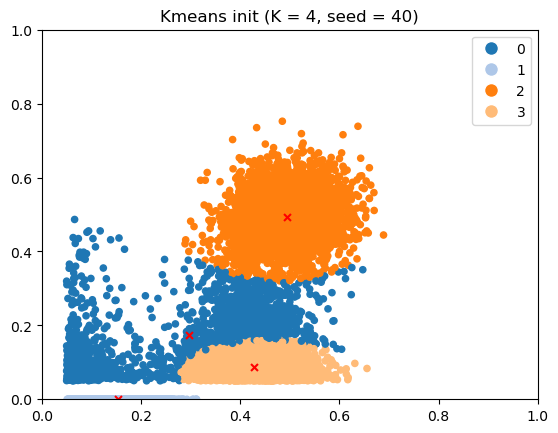

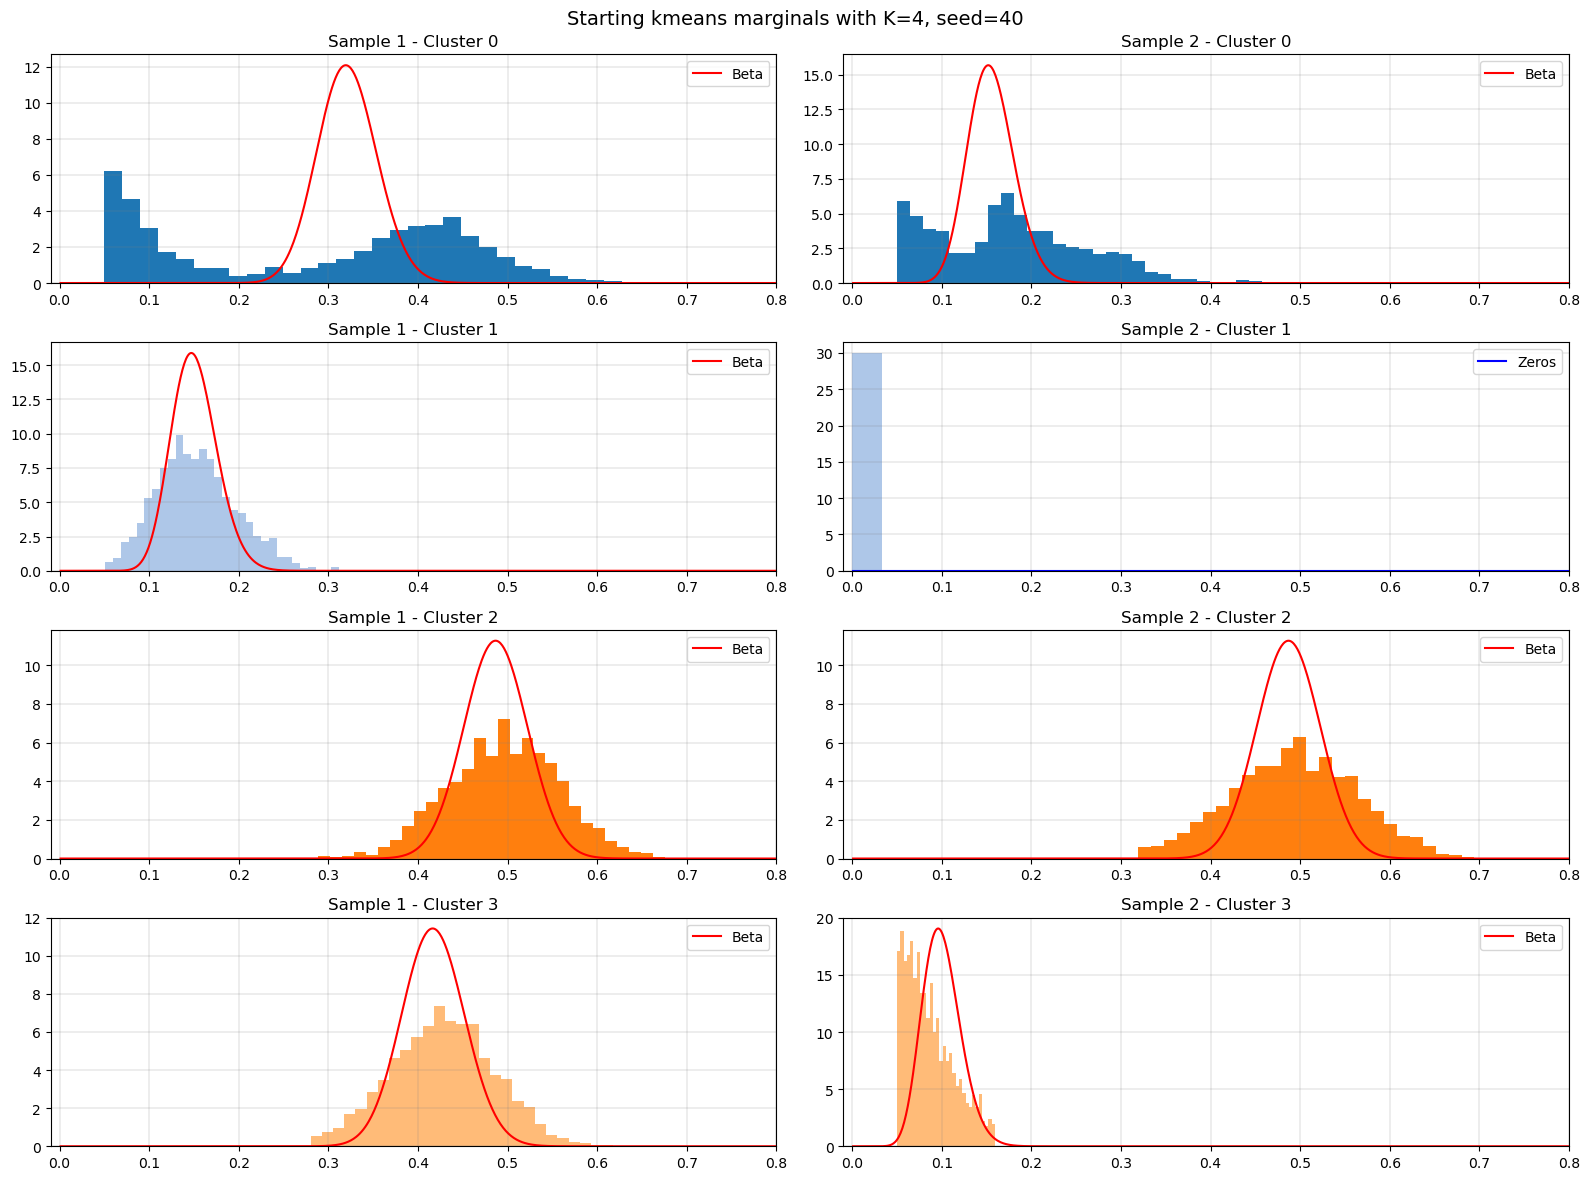

Iteration 0: Loss = 739354614.801034
Iteration 50: Loss = 695308281.4377208
Iteration 100: Loss = 687605903.7611701
Iteration 150: Loss = 684552269.0010616
Iteration 200: Loss = 682989338.4093719
Iteration 250: Loss = 682238132.5375401
Iteration 300: Loss = 681781471.7849847
Iteration 350: Loss = 681466992.2971312
Iteration 400: Loss = 681237191.7727058
Iteration 450: Loss = 681062467.4881477
Iteration 500: Loss = 680925493.4092317


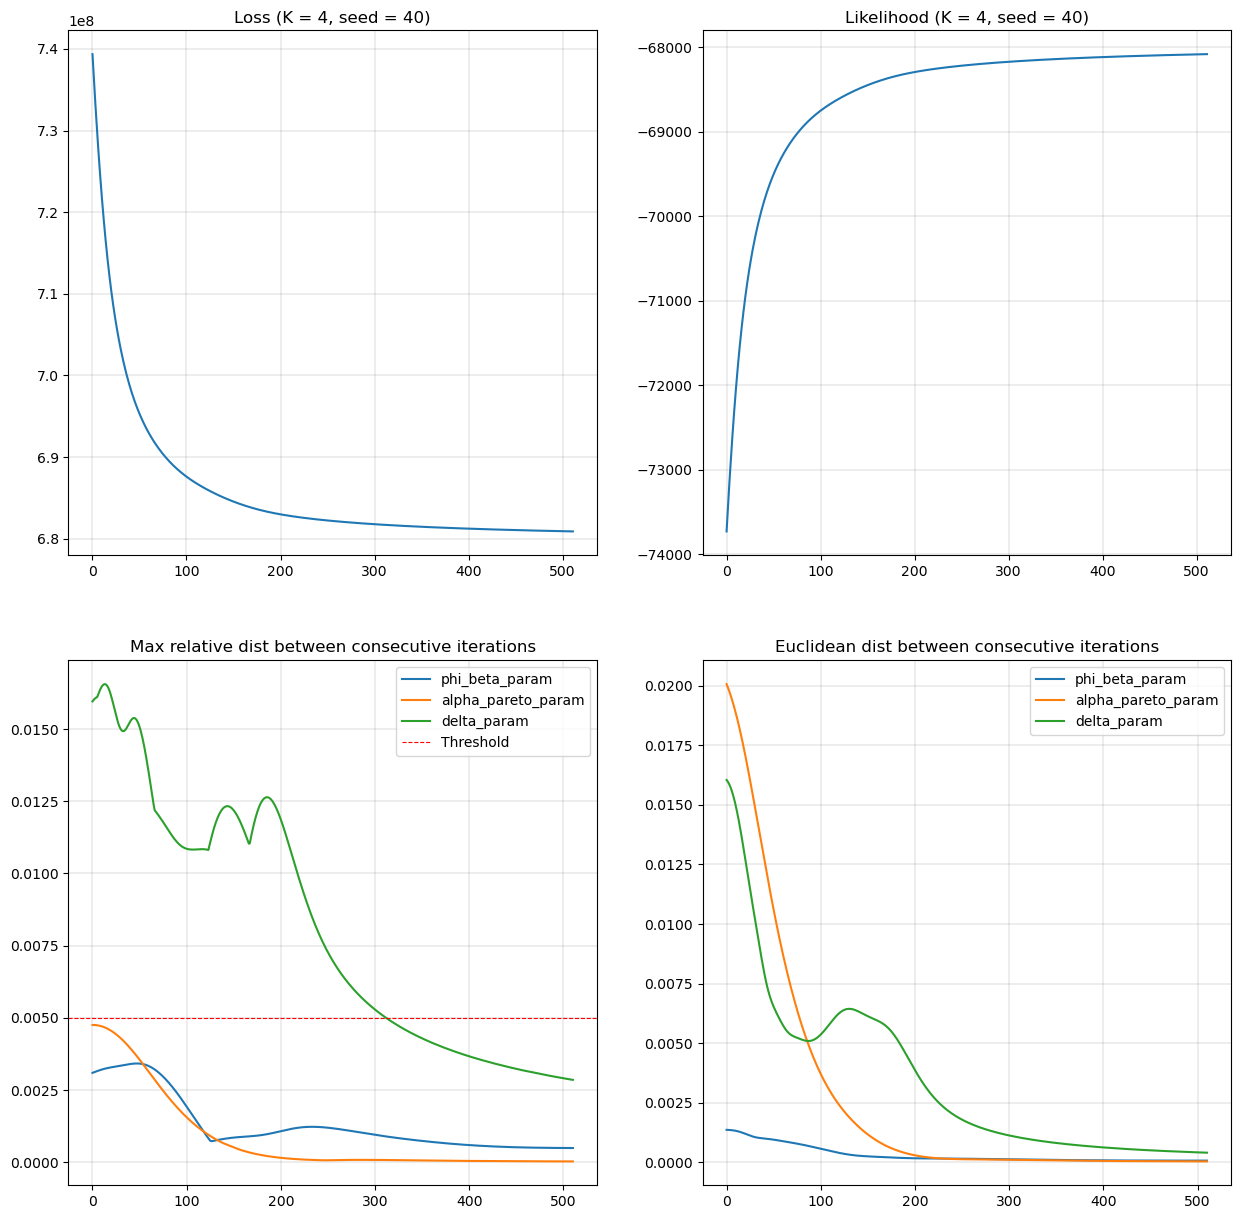

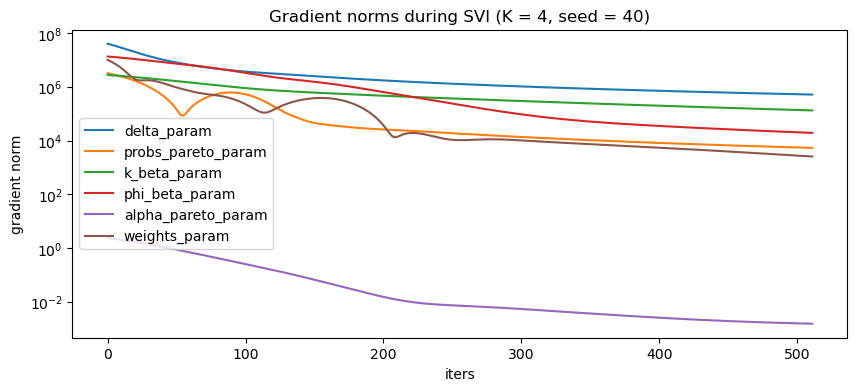

Inference lk:  -68081.68547640441
Final lk (integr):  tensor(-78167.3906, grad_fn=<SumBackward0>)
n_params:  60
n:  tensor(10000)
lk:  tensor(-78167.3906, grad_fn=<SumBackward0>)
bic: 156887.40625 



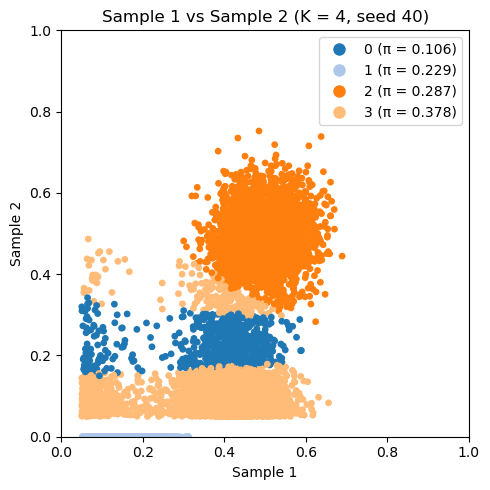

Time taken for K = 4 and seed = 40: 16.369 seconds
RUN WITH K = 4 AND SEED = 41
Minimum detected VAF: tensor(0.0500)


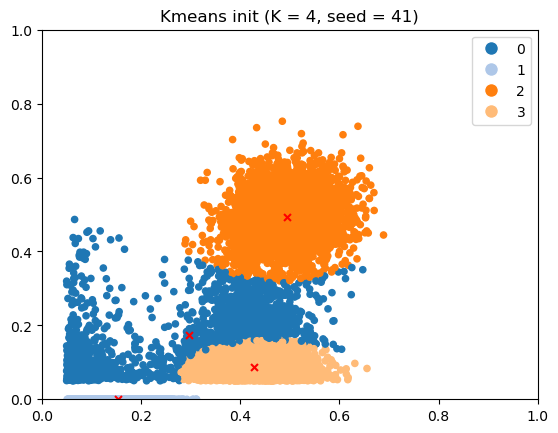

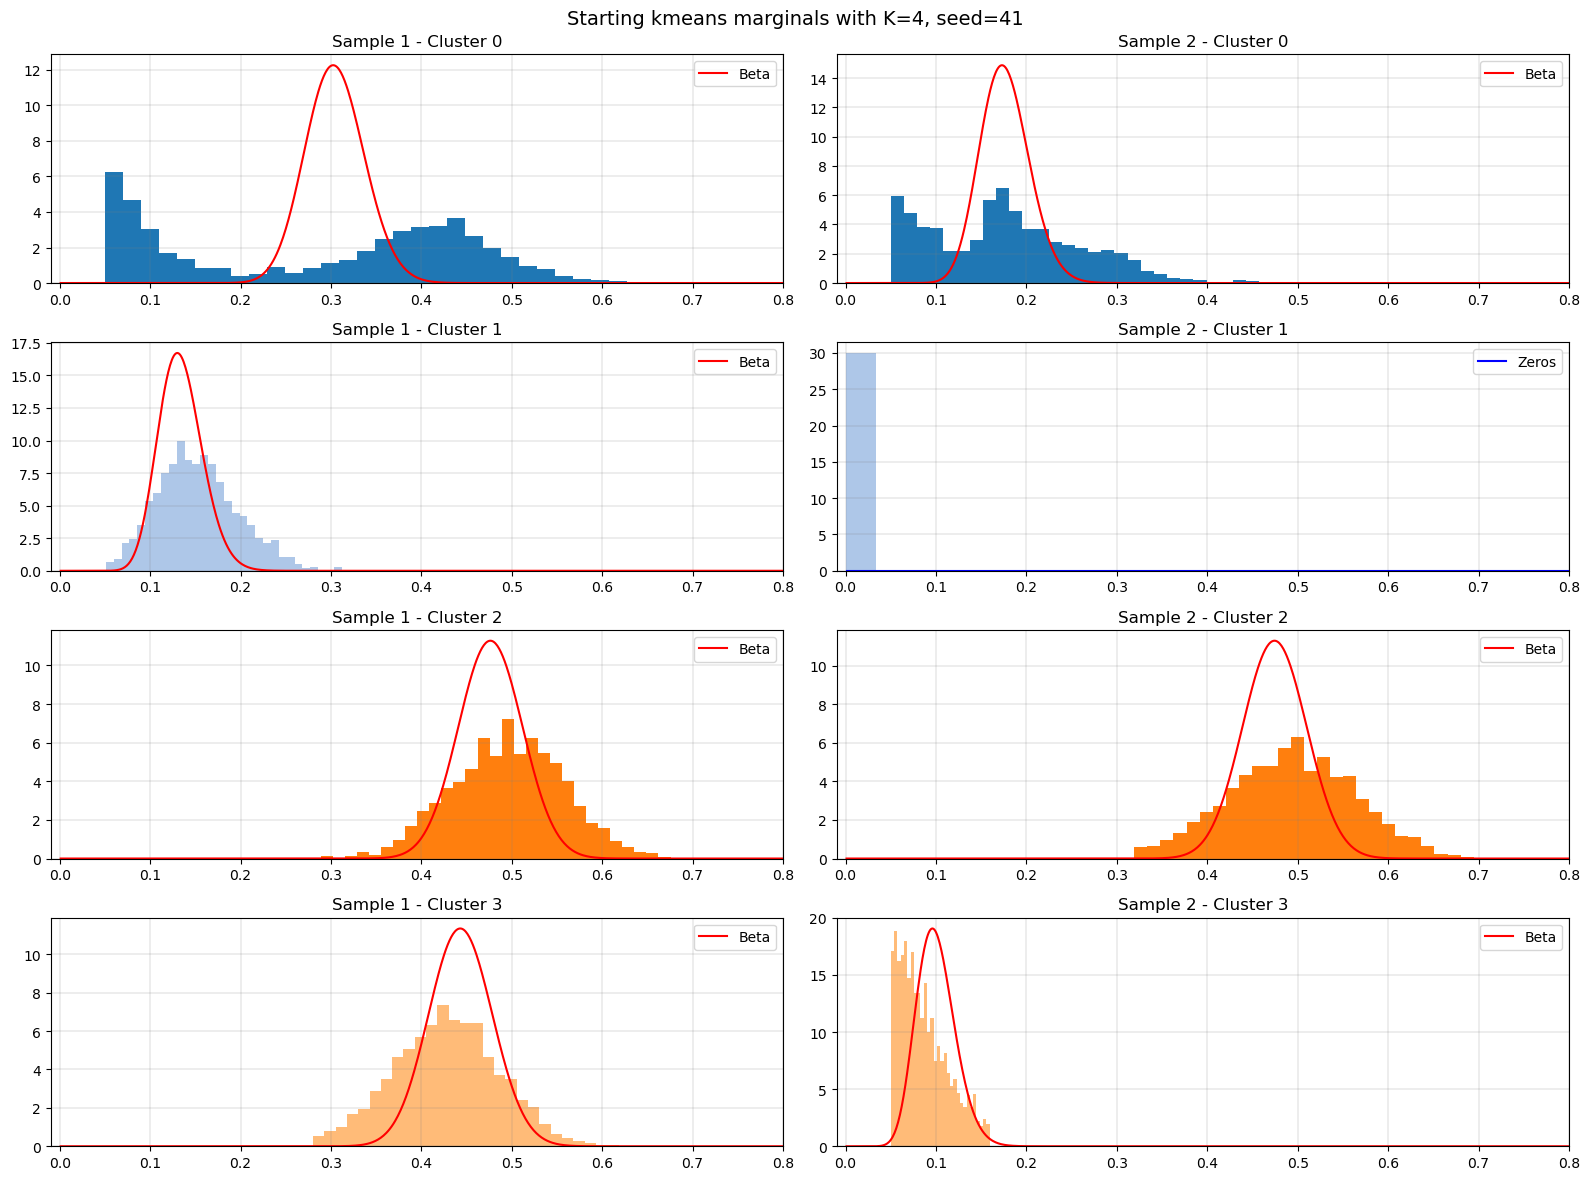

Iteration 0: Loss = 743359364.4804168
Iteration 50: Loss = 695115315.7318788
Iteration 100: Loss = 687686214.0733237
Iteration 150: Loss = 685155873.2164209
Iteration 200: Loss = 683800518.402822
Iteration 250: Loss = 682991378.0369636
Iteration 300: Loss = 682491472.2330043
Iteration 350: Loss = 682160023.273605
Iteration 400: Loss = 681925155.6572118
Iteration 450: Loss = 681750422.9923998
Iteration 500: Loss = 681615528.0397123


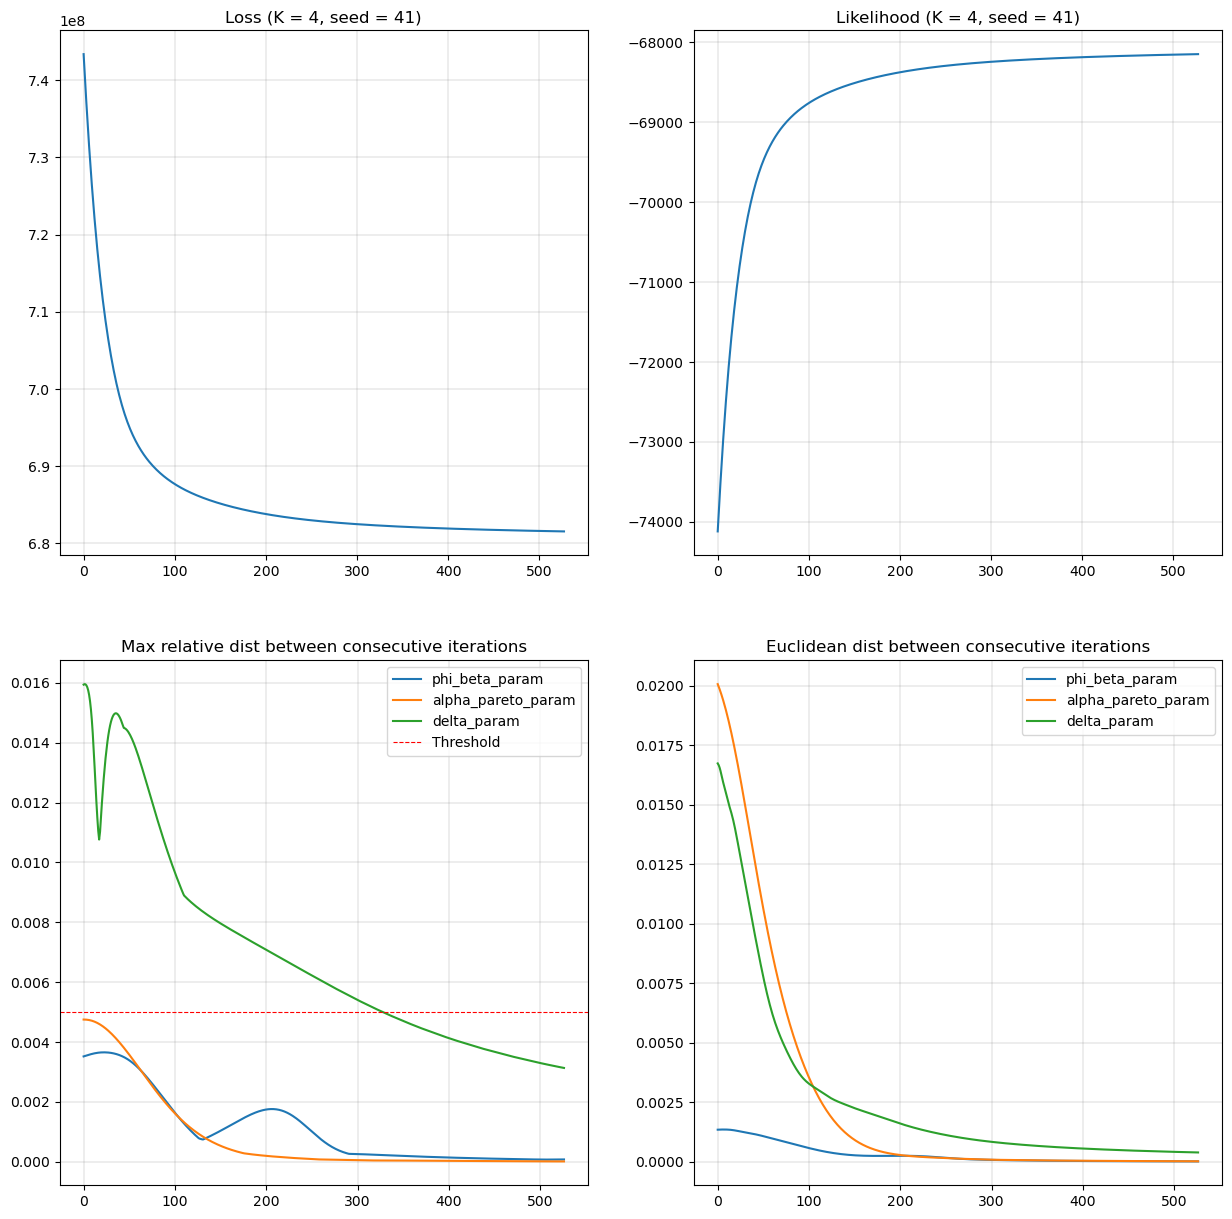

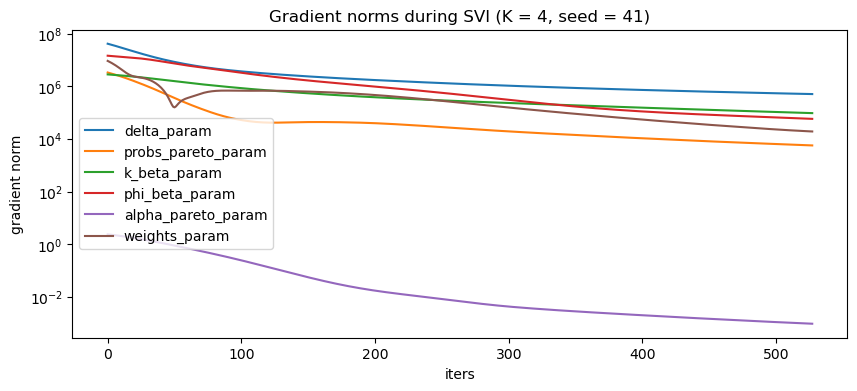

Inference lk:  -68147.82985430778
Final lk (integr):  tensor(-76660.2500, grad_fn=<SumBackward0>)
n_params:  60
n:  tensor(10000)
lk:  tensor(-76660.2500, grad_fn=<SumBackward0>)
bic: 153873.125 



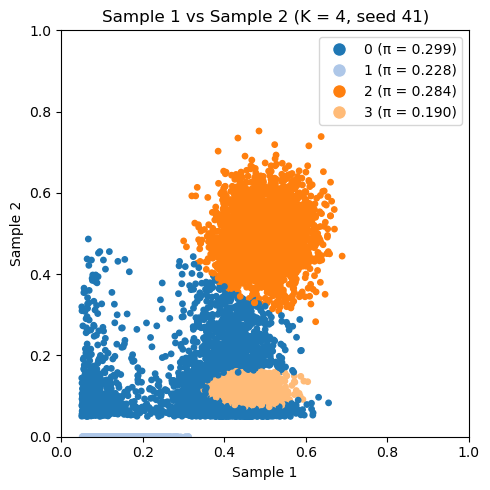

Time taken for K = 4 and seed = 41: 16.551 seconds


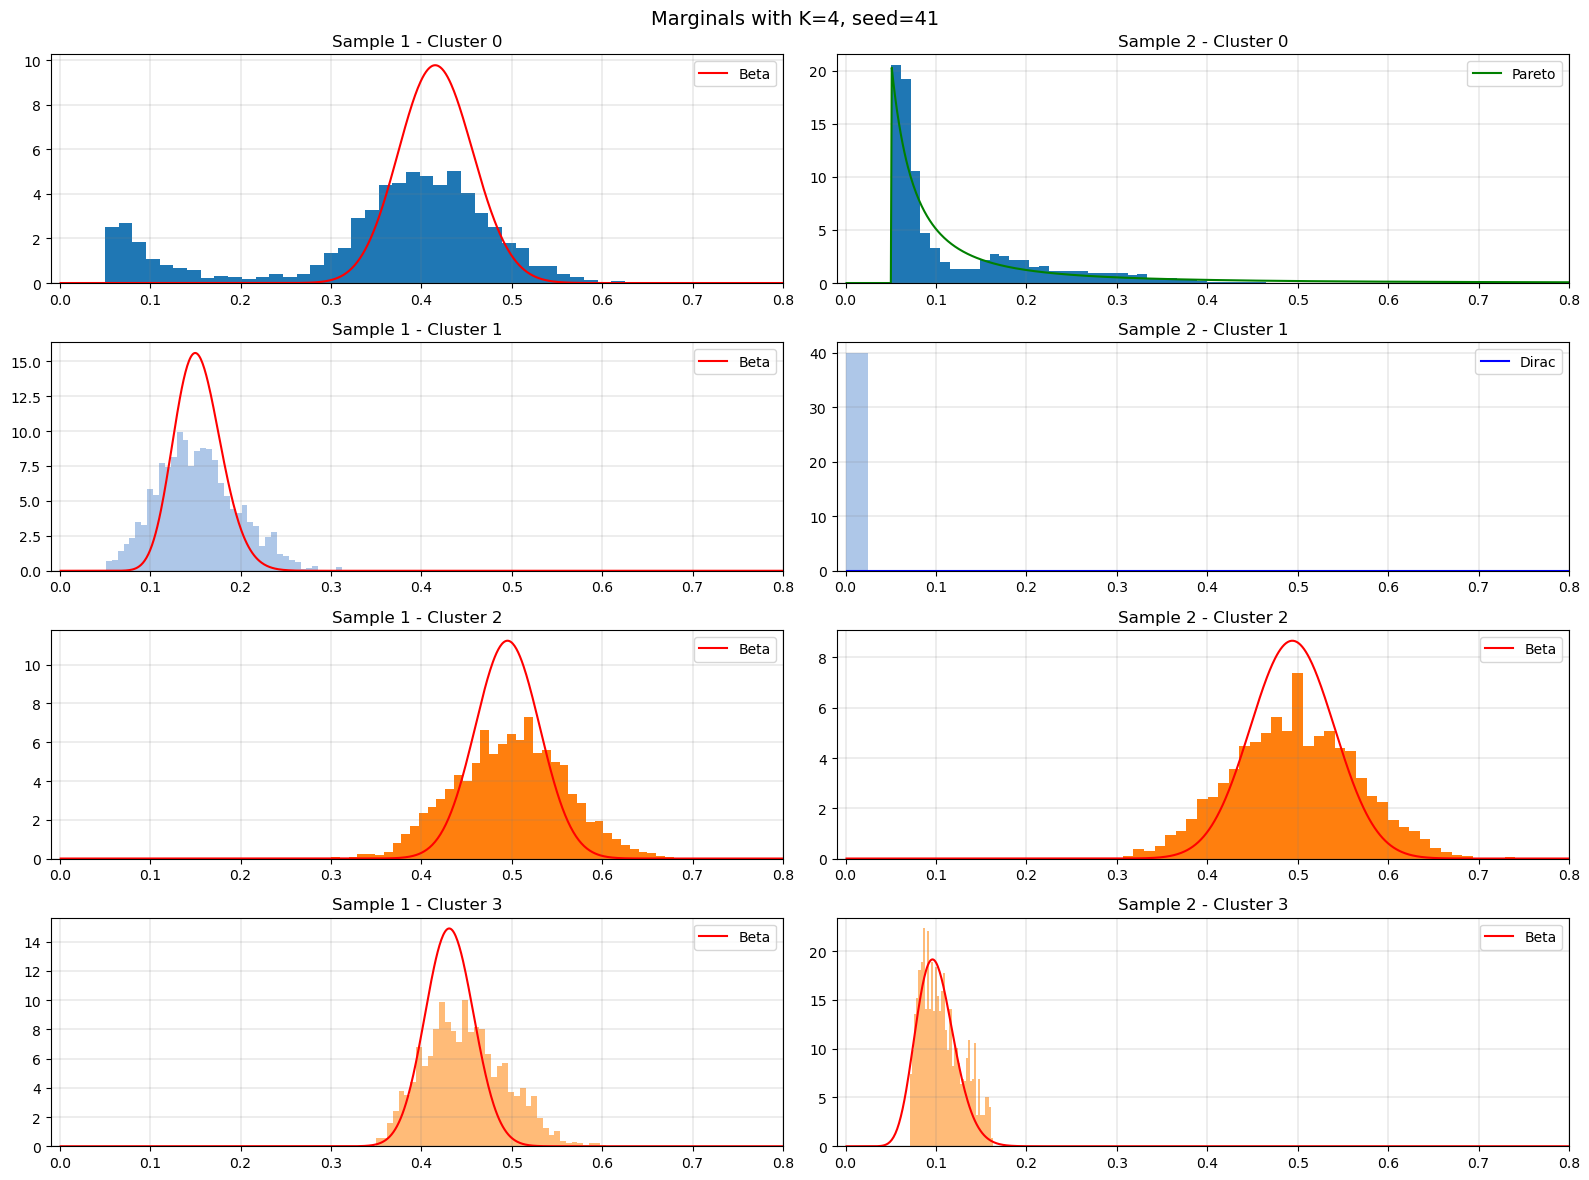

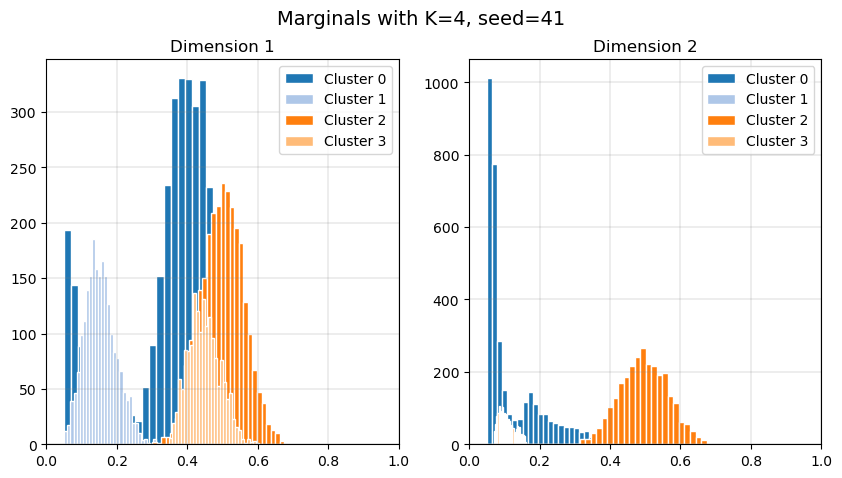

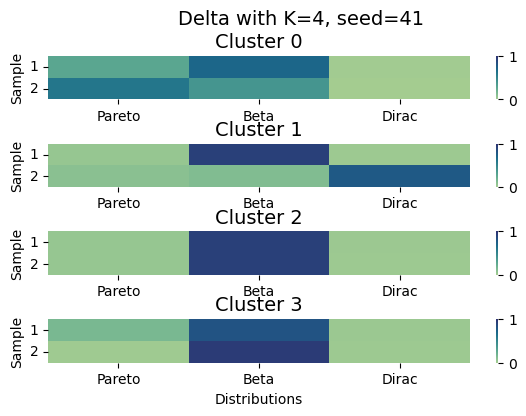

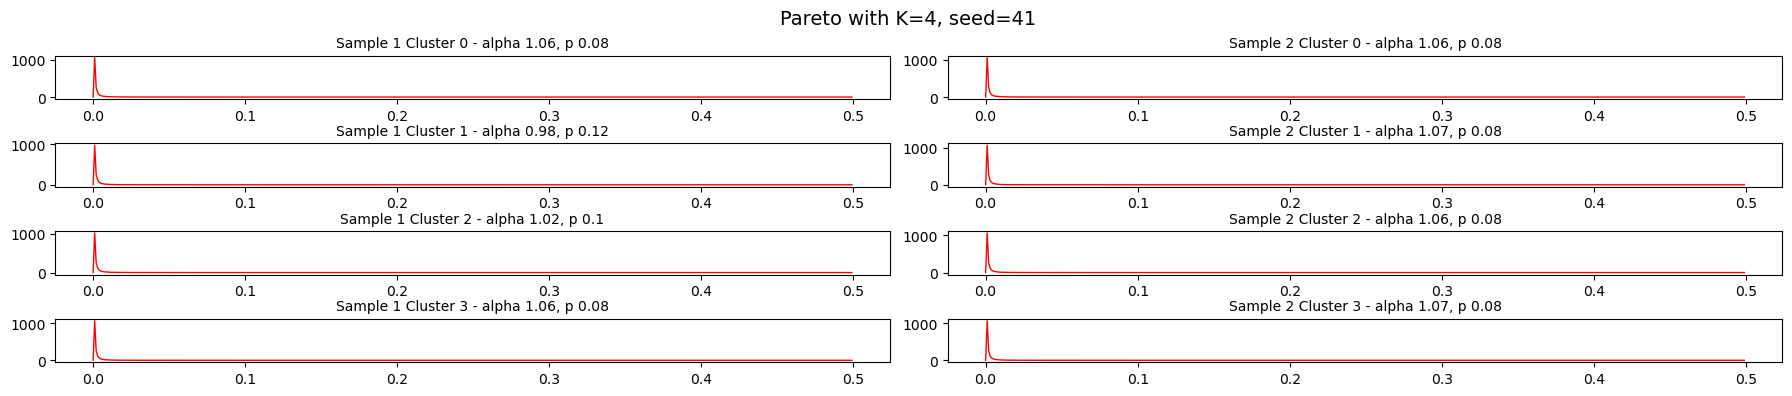

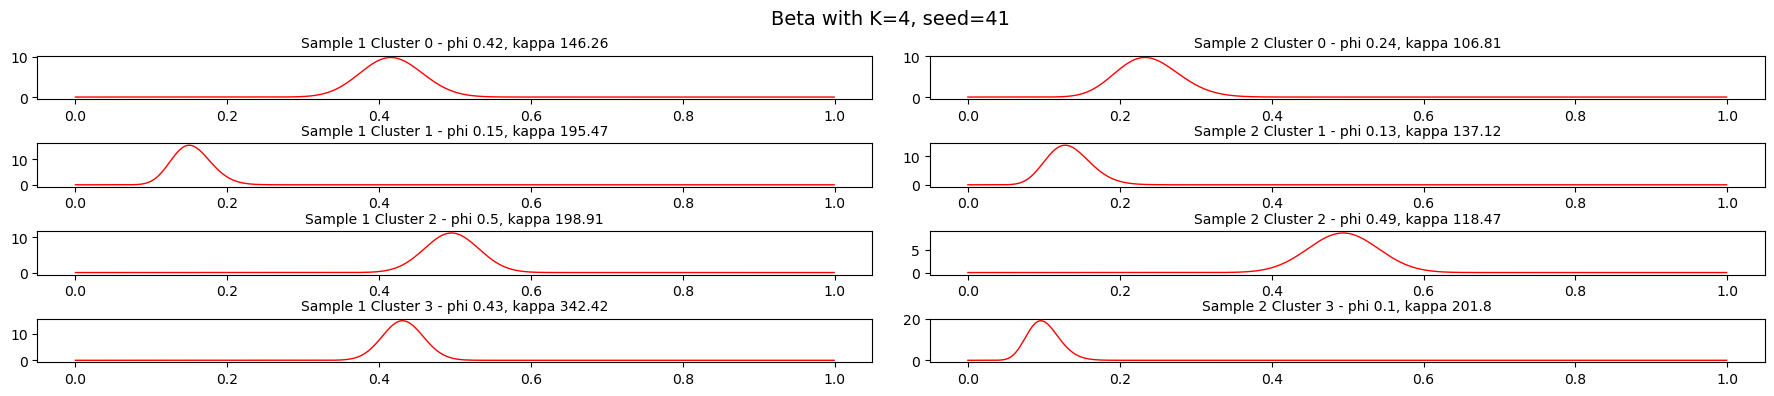

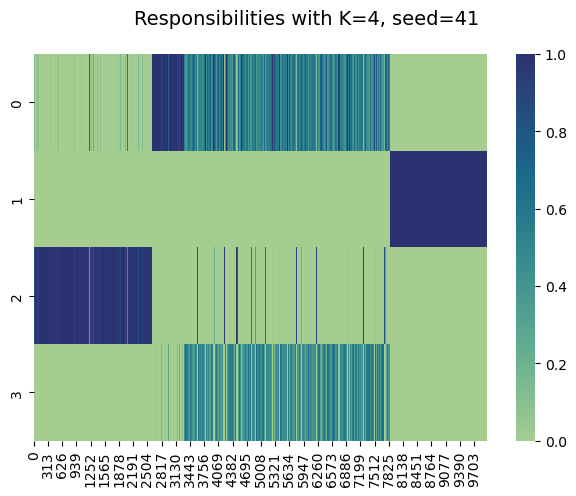

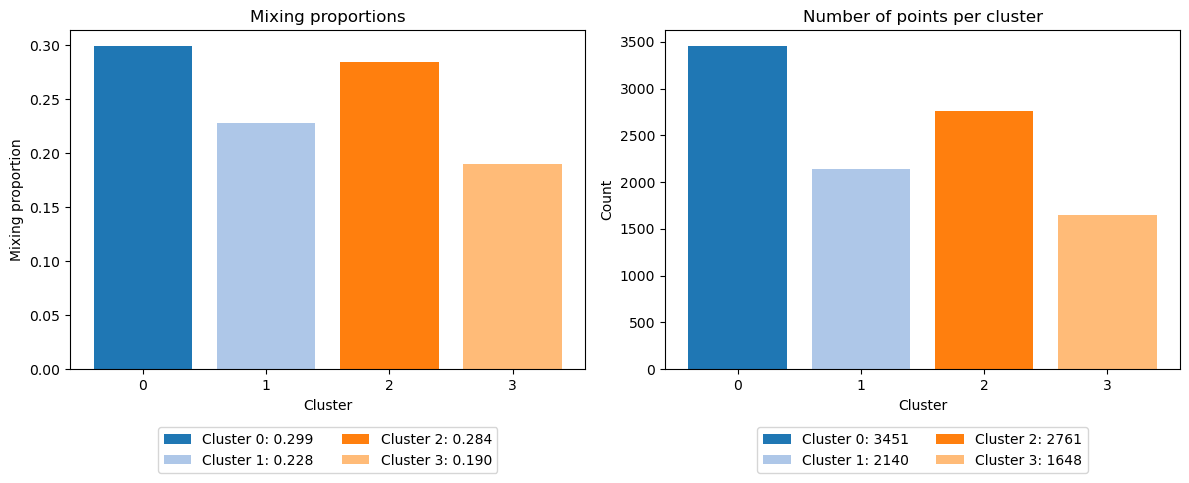

RUN WITH K = 5 AND SEED = 40
Minimum detected VAF: tensor(0.0500)


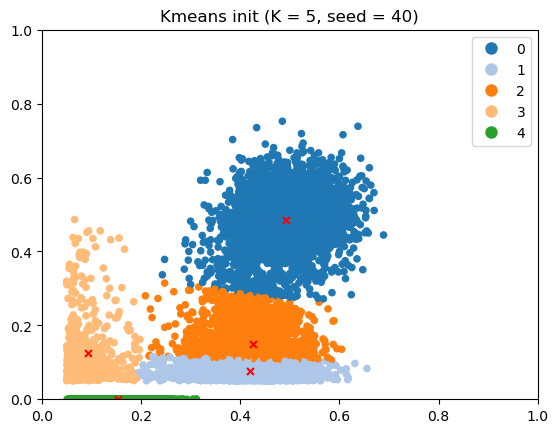

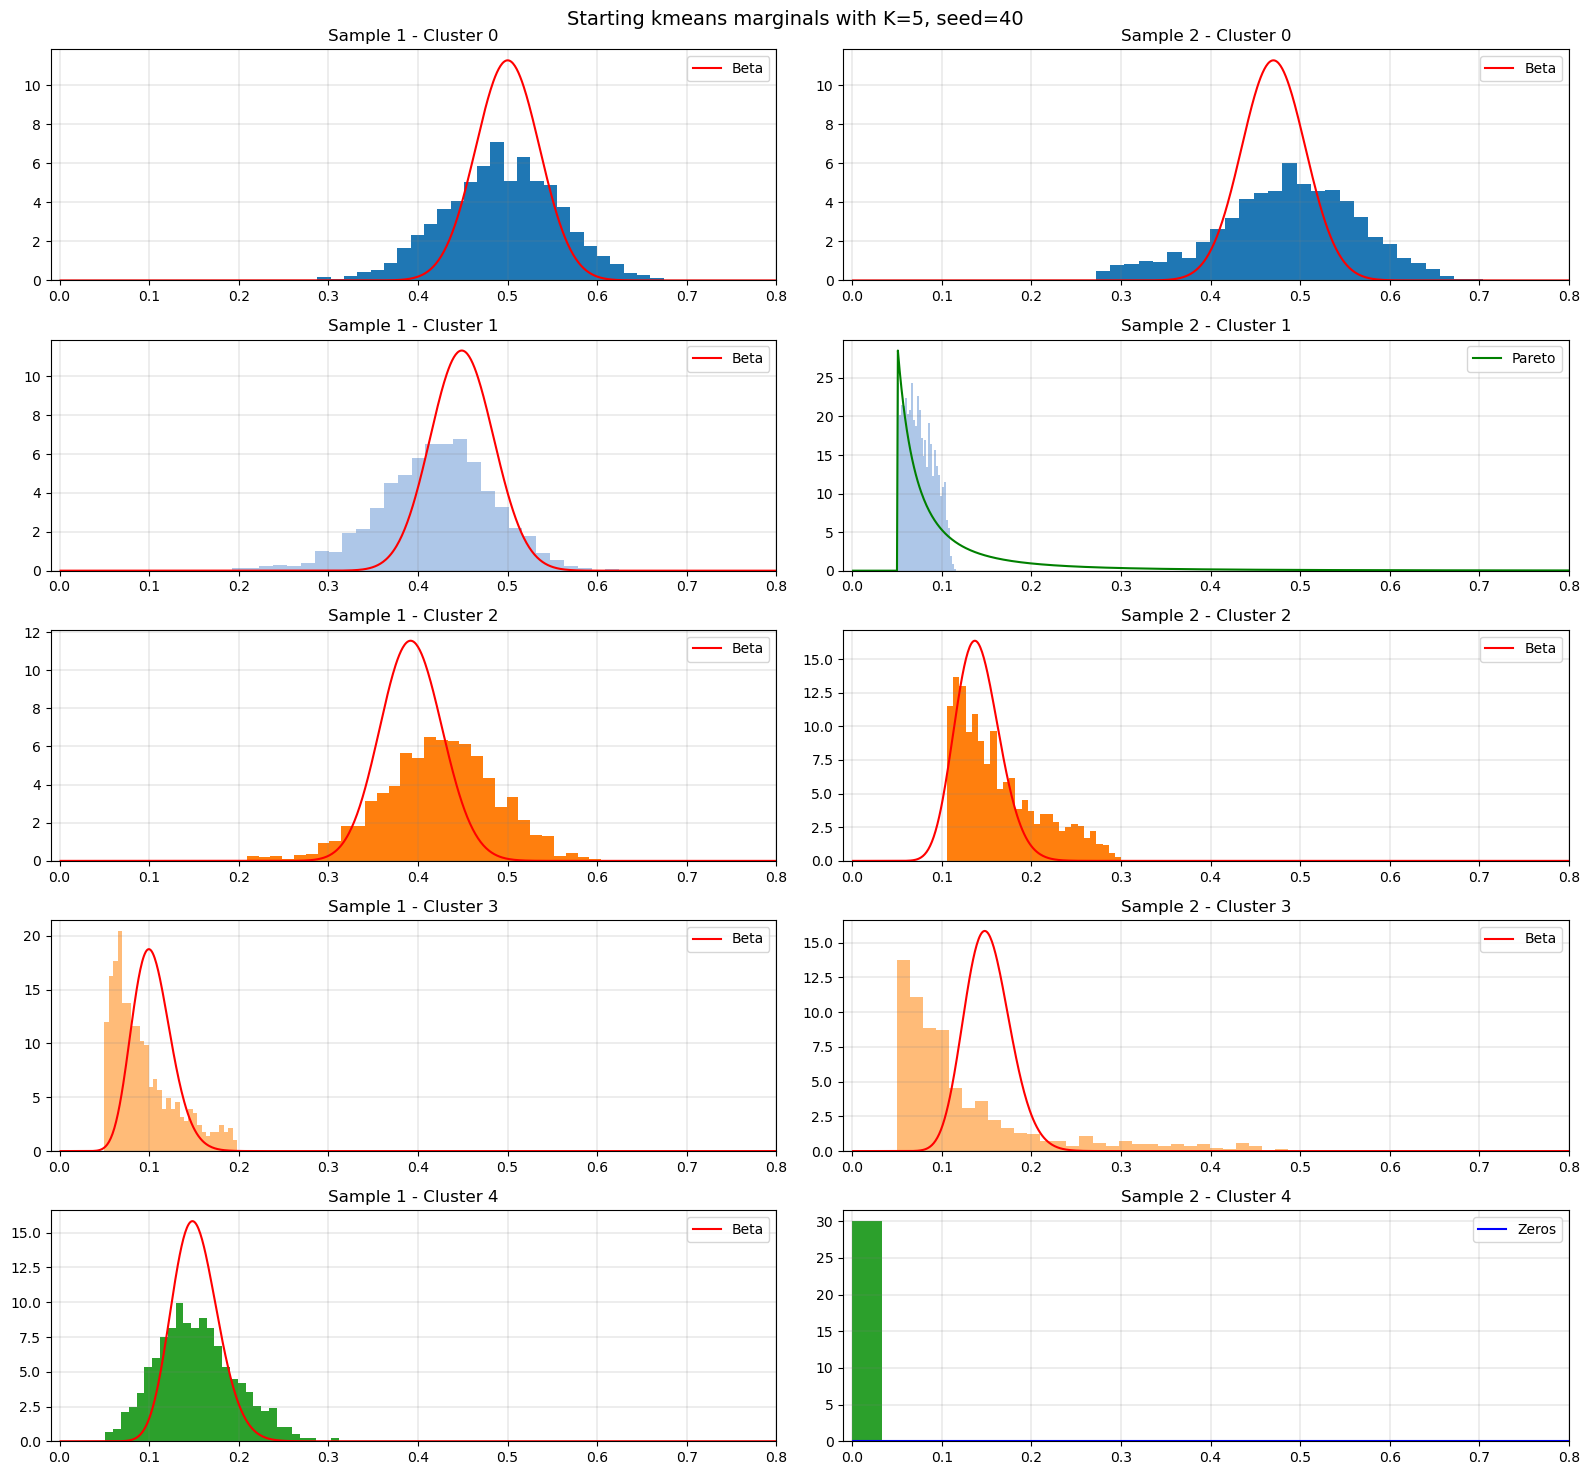

Iteration 0: Loss = 740381658.7035216
Iteration 50: Loss = 693933771.2402253
Iteration 100: Loss = 686637760.1224961
Iteration 150: Loss = 683925583.8515078
Iteration 200: Loss = 682709992.3870876
Iteration 250: Loss = 682025282.5175924
Iteration 300: Loss = 681543707.3531022
Iteration 350: Loss = 681172572.191778
Iteration 400: Loss = 680914084.6887873


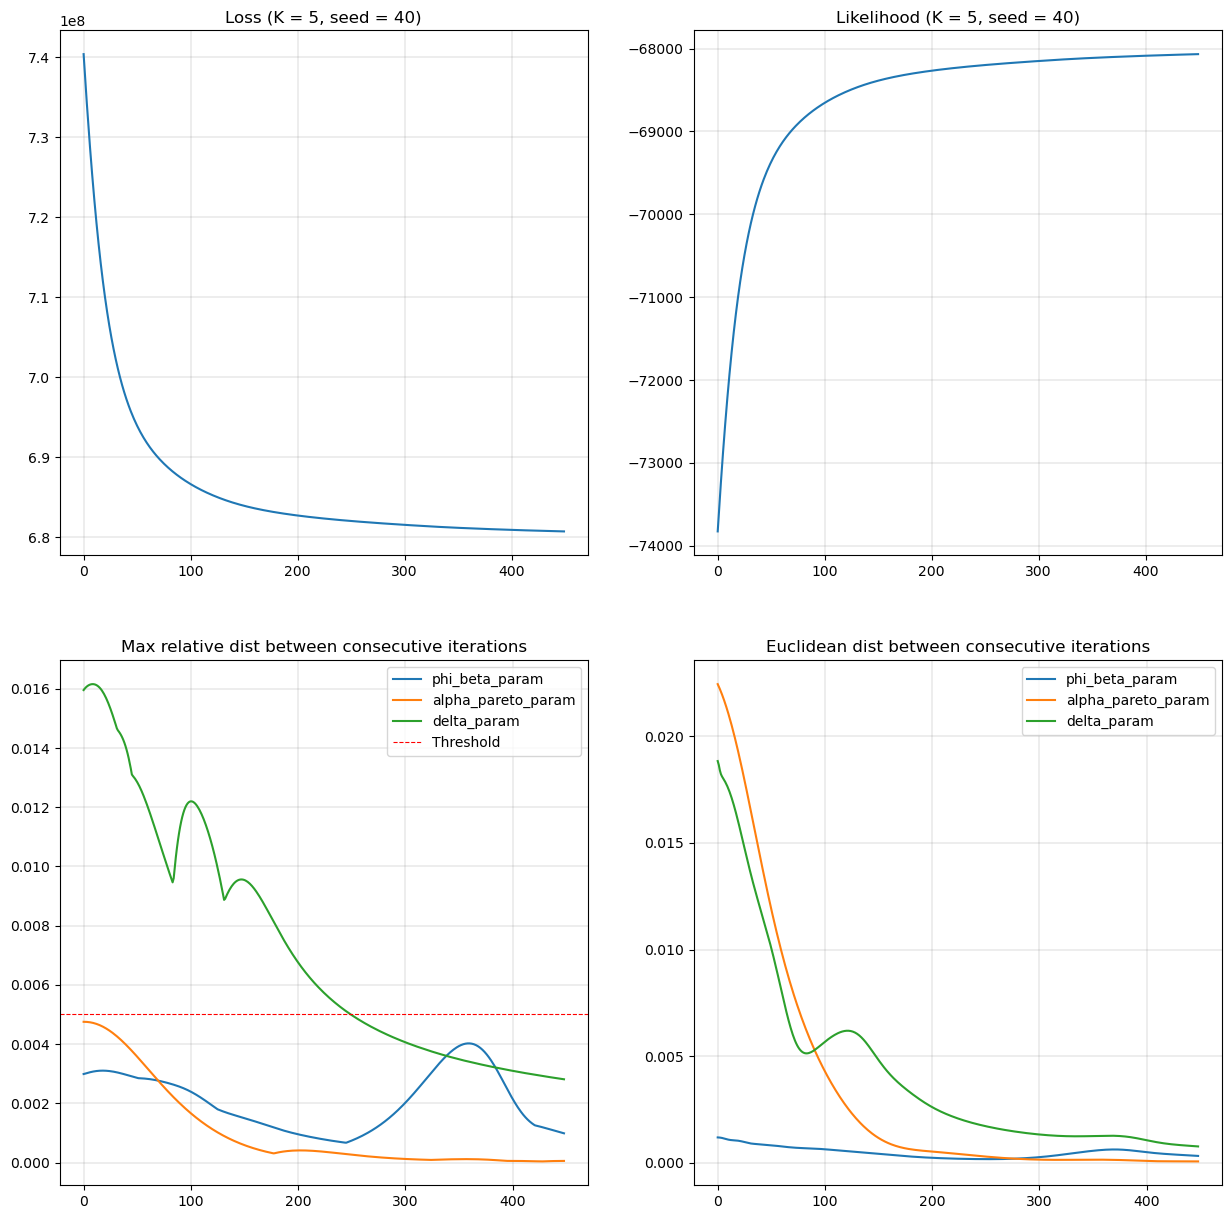

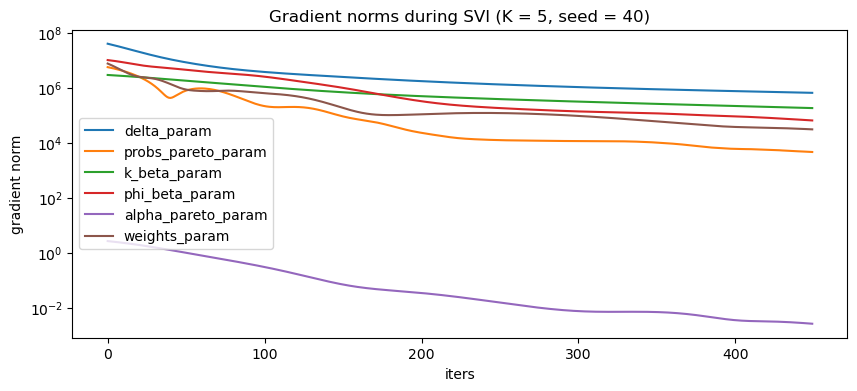

Inference lk:  -68066.3691916458
Final lk (integr):  tensor(-69001.6875, grad_fn=<SumBackward0>)
n_params:  75
n:  tensor(10000)
lk:  tensor(-69001.6875, grad_fn=<SumBackward0>)
bic: 138694.15625 



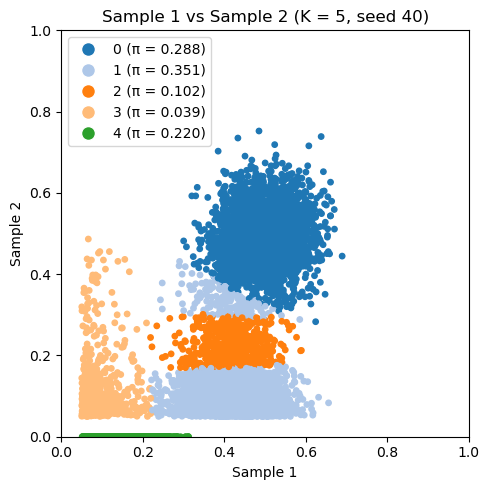

Time taken for K = 5 and seed = 40: 17.909 seconds
RUN WITH K = 5 AND SEED = 41
Minimum detected VAF: tensor(0.0500)


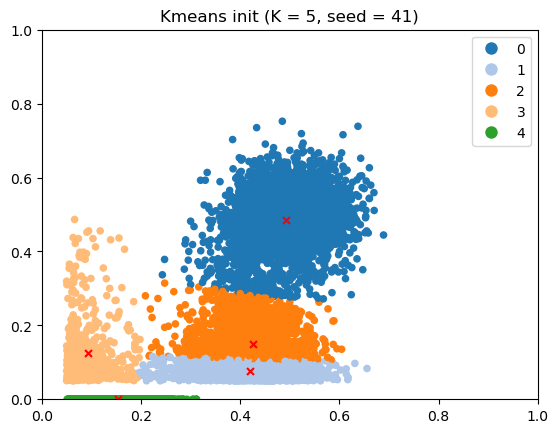

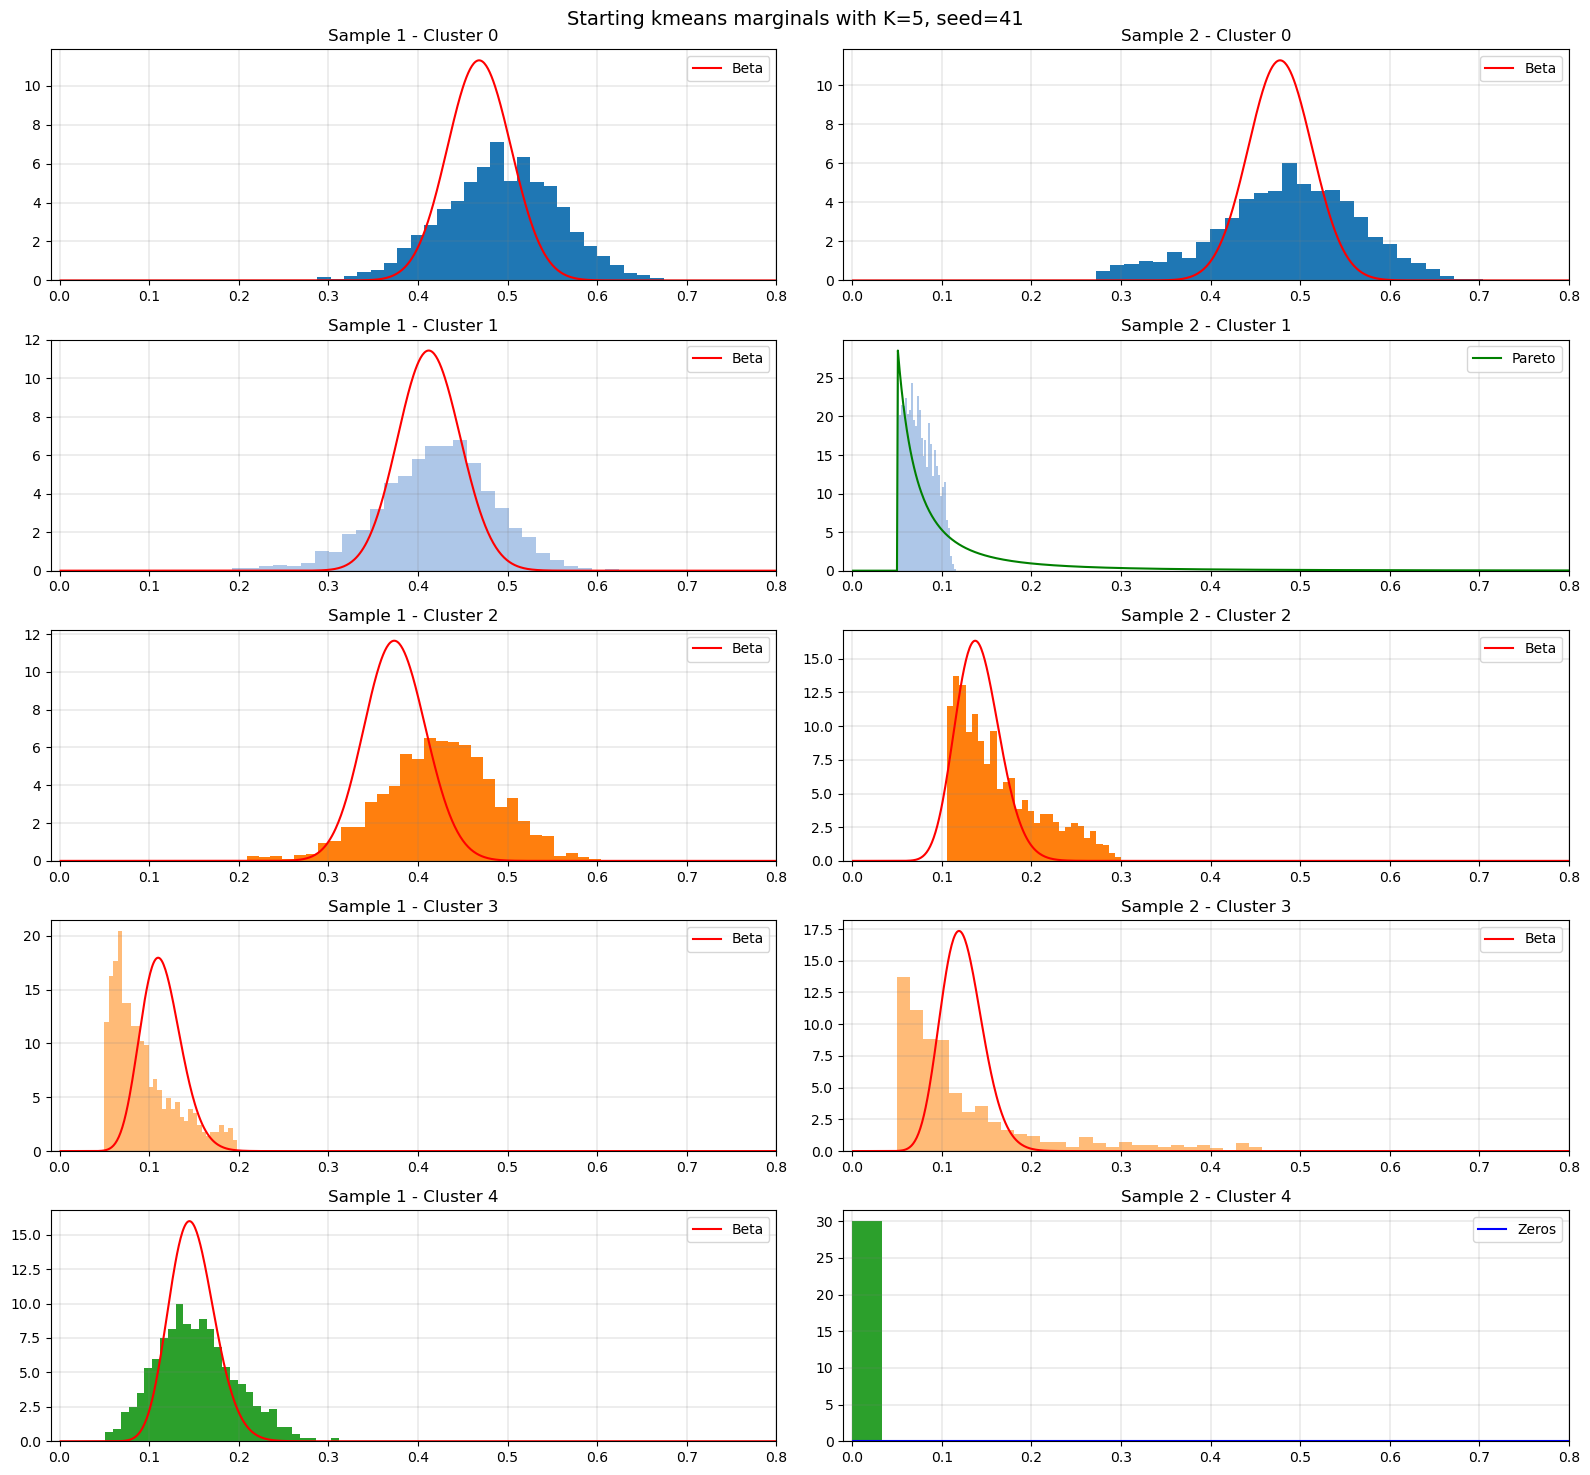

Iteration 0: Loss = 741966385.1685051
Iteration 50: Loss = 694331301.7853805
Iteration 100: Loss = 686597786.6179208
Iteration 150: Loss = 684041619.7341608
Iteration 200: Loss = 682856368.3600452
Iteration 250: Loss = 682138609.1957477
Iteration 300: Loss = 681653601.5046532
Iteration 350: Loss = 681307925.6466652
Iteration 400: Loss = 681045073.9293164


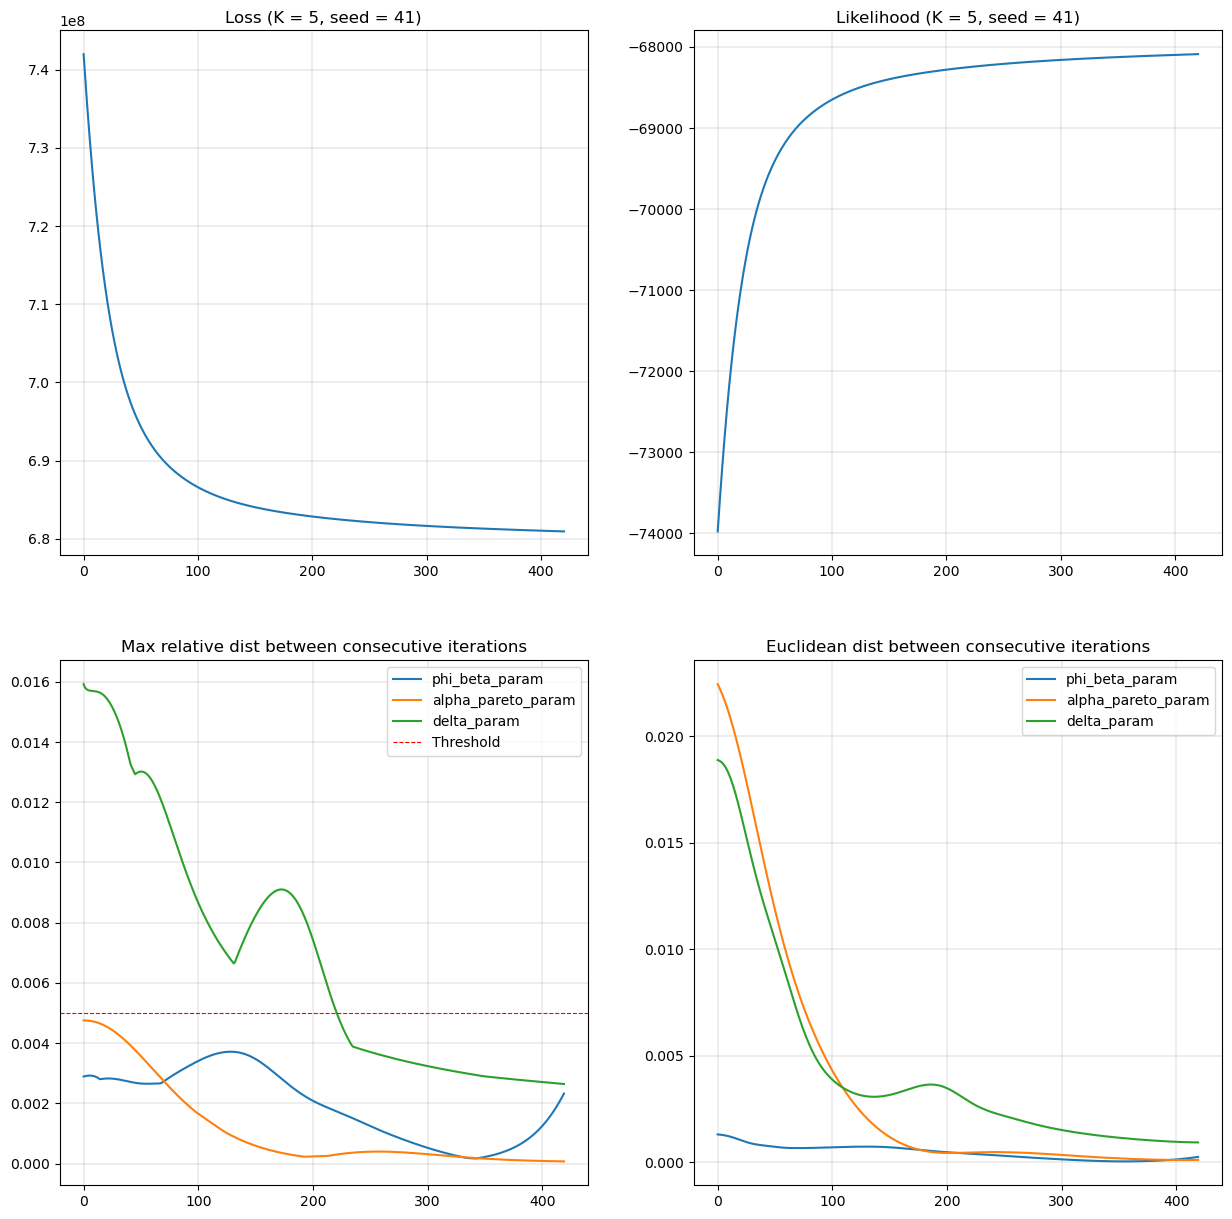

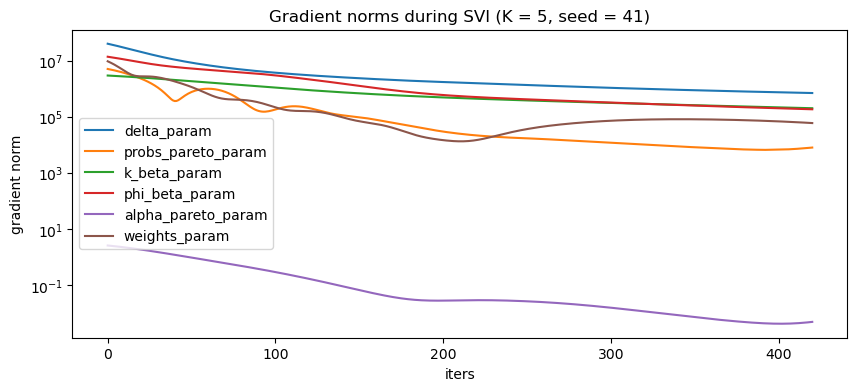

Inference lk:  -68089.16597891376
Final lk (integr):  tensor(-69025.3438, grad_fn=<SumBackward0>)
n_params:  75
n:  tensor(10000)
lk:  tensor(-69025.3438, grad_fn=<SumBackward0>)
bic: 138741.46875 



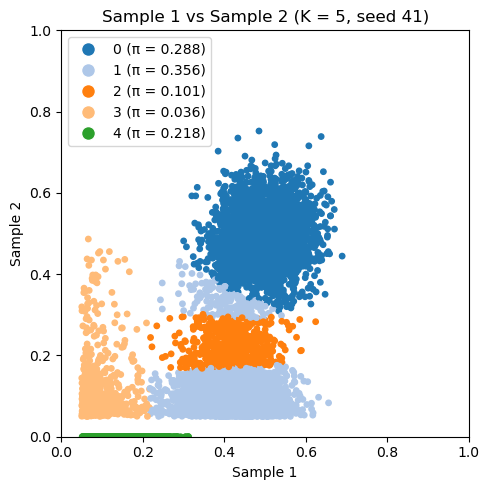

Time taken for K = 5 and seed = 41: 17.109 seconds


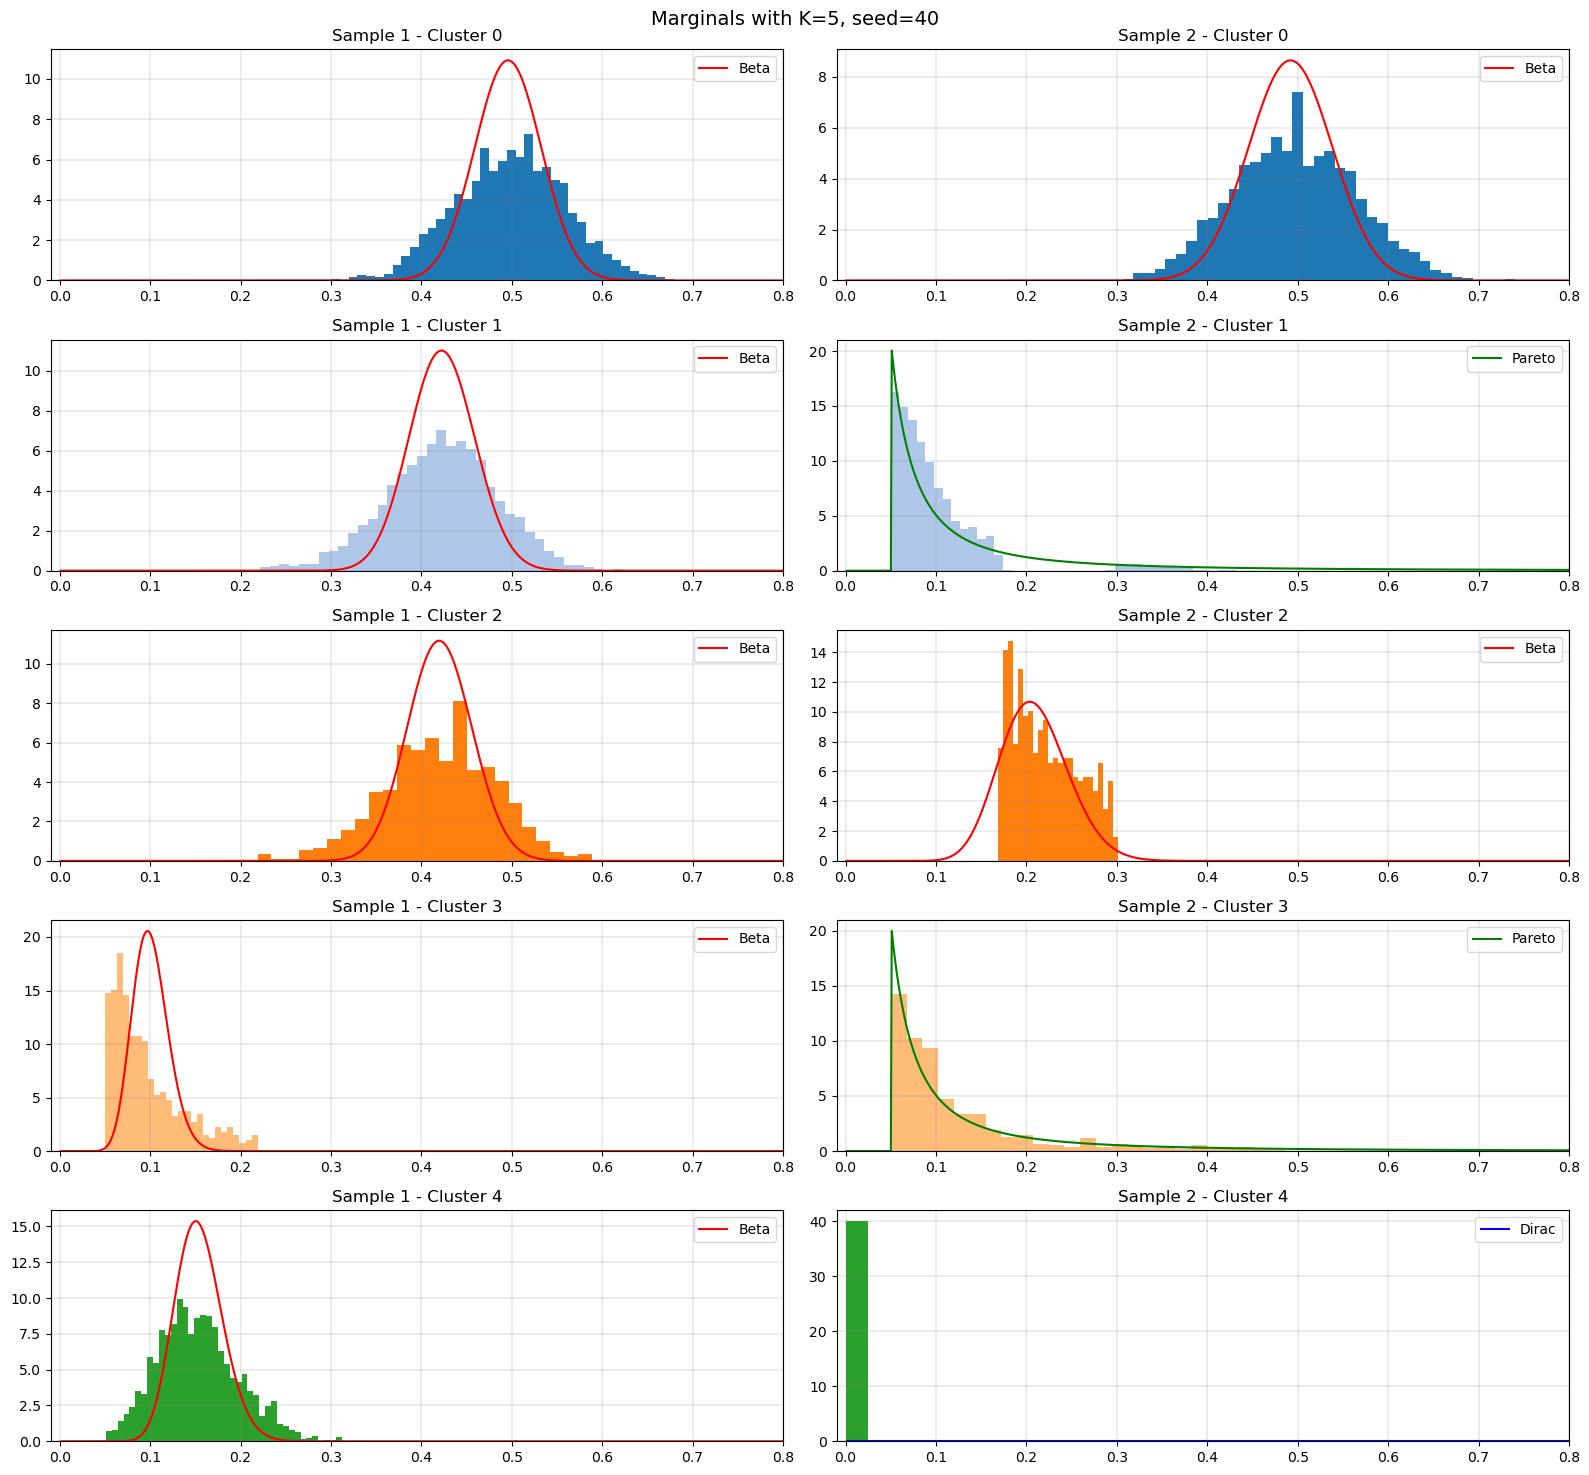

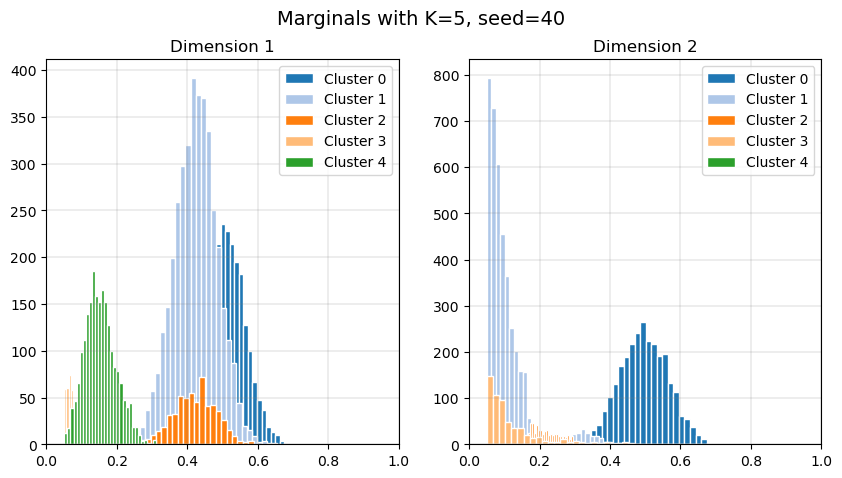

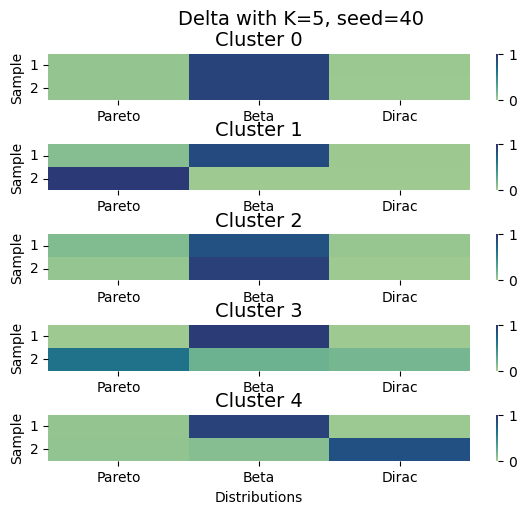

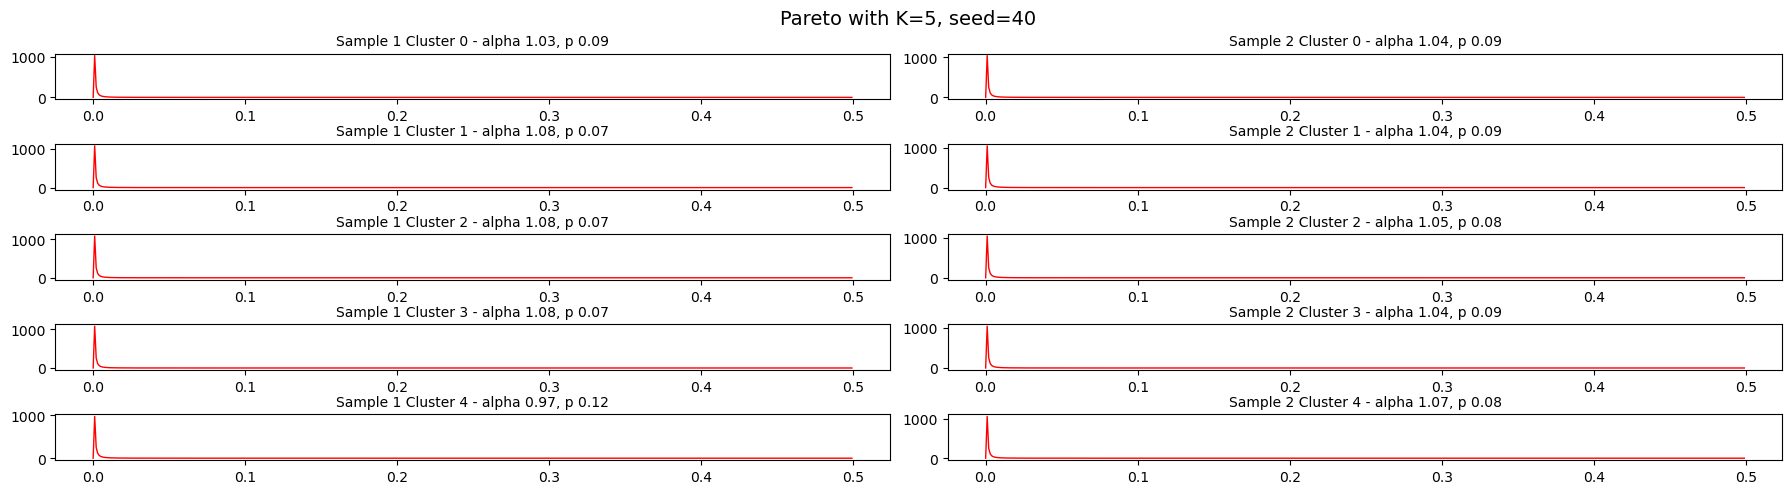

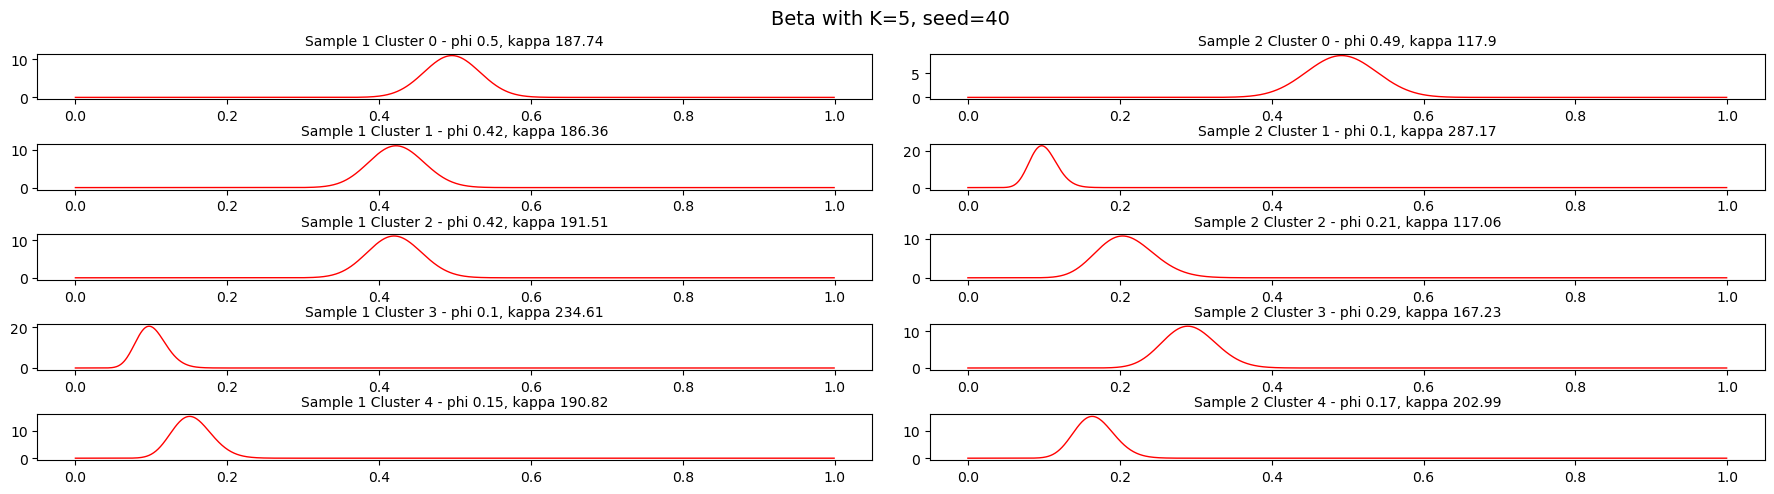

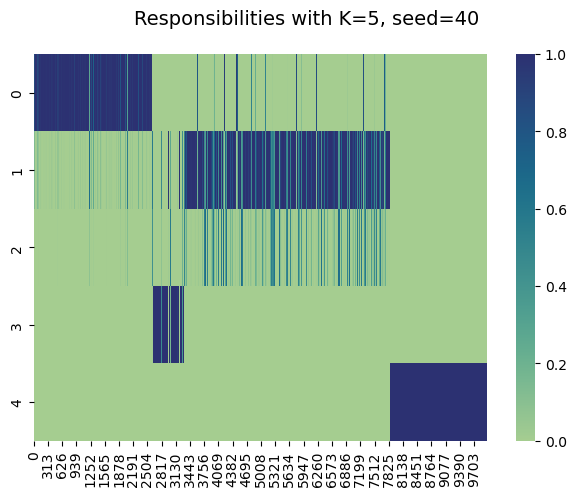

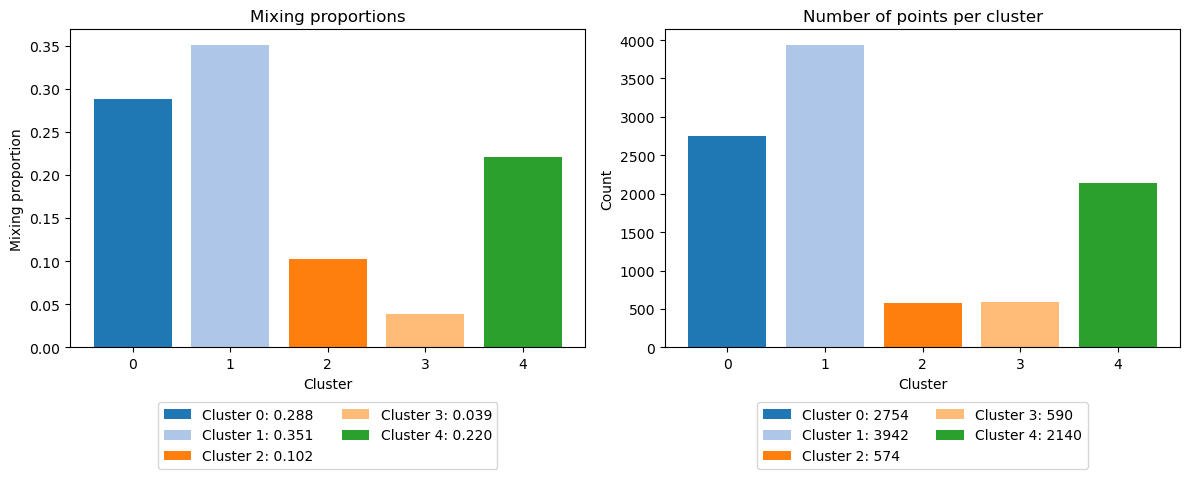

RUN WITH K = 6 AND SEED = 40
Minimum detected VAF: tensor(0.0500)


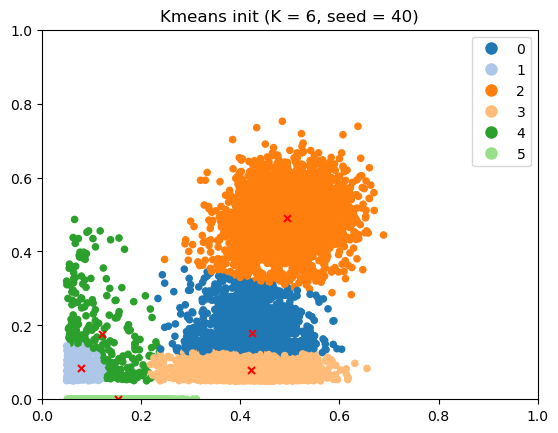

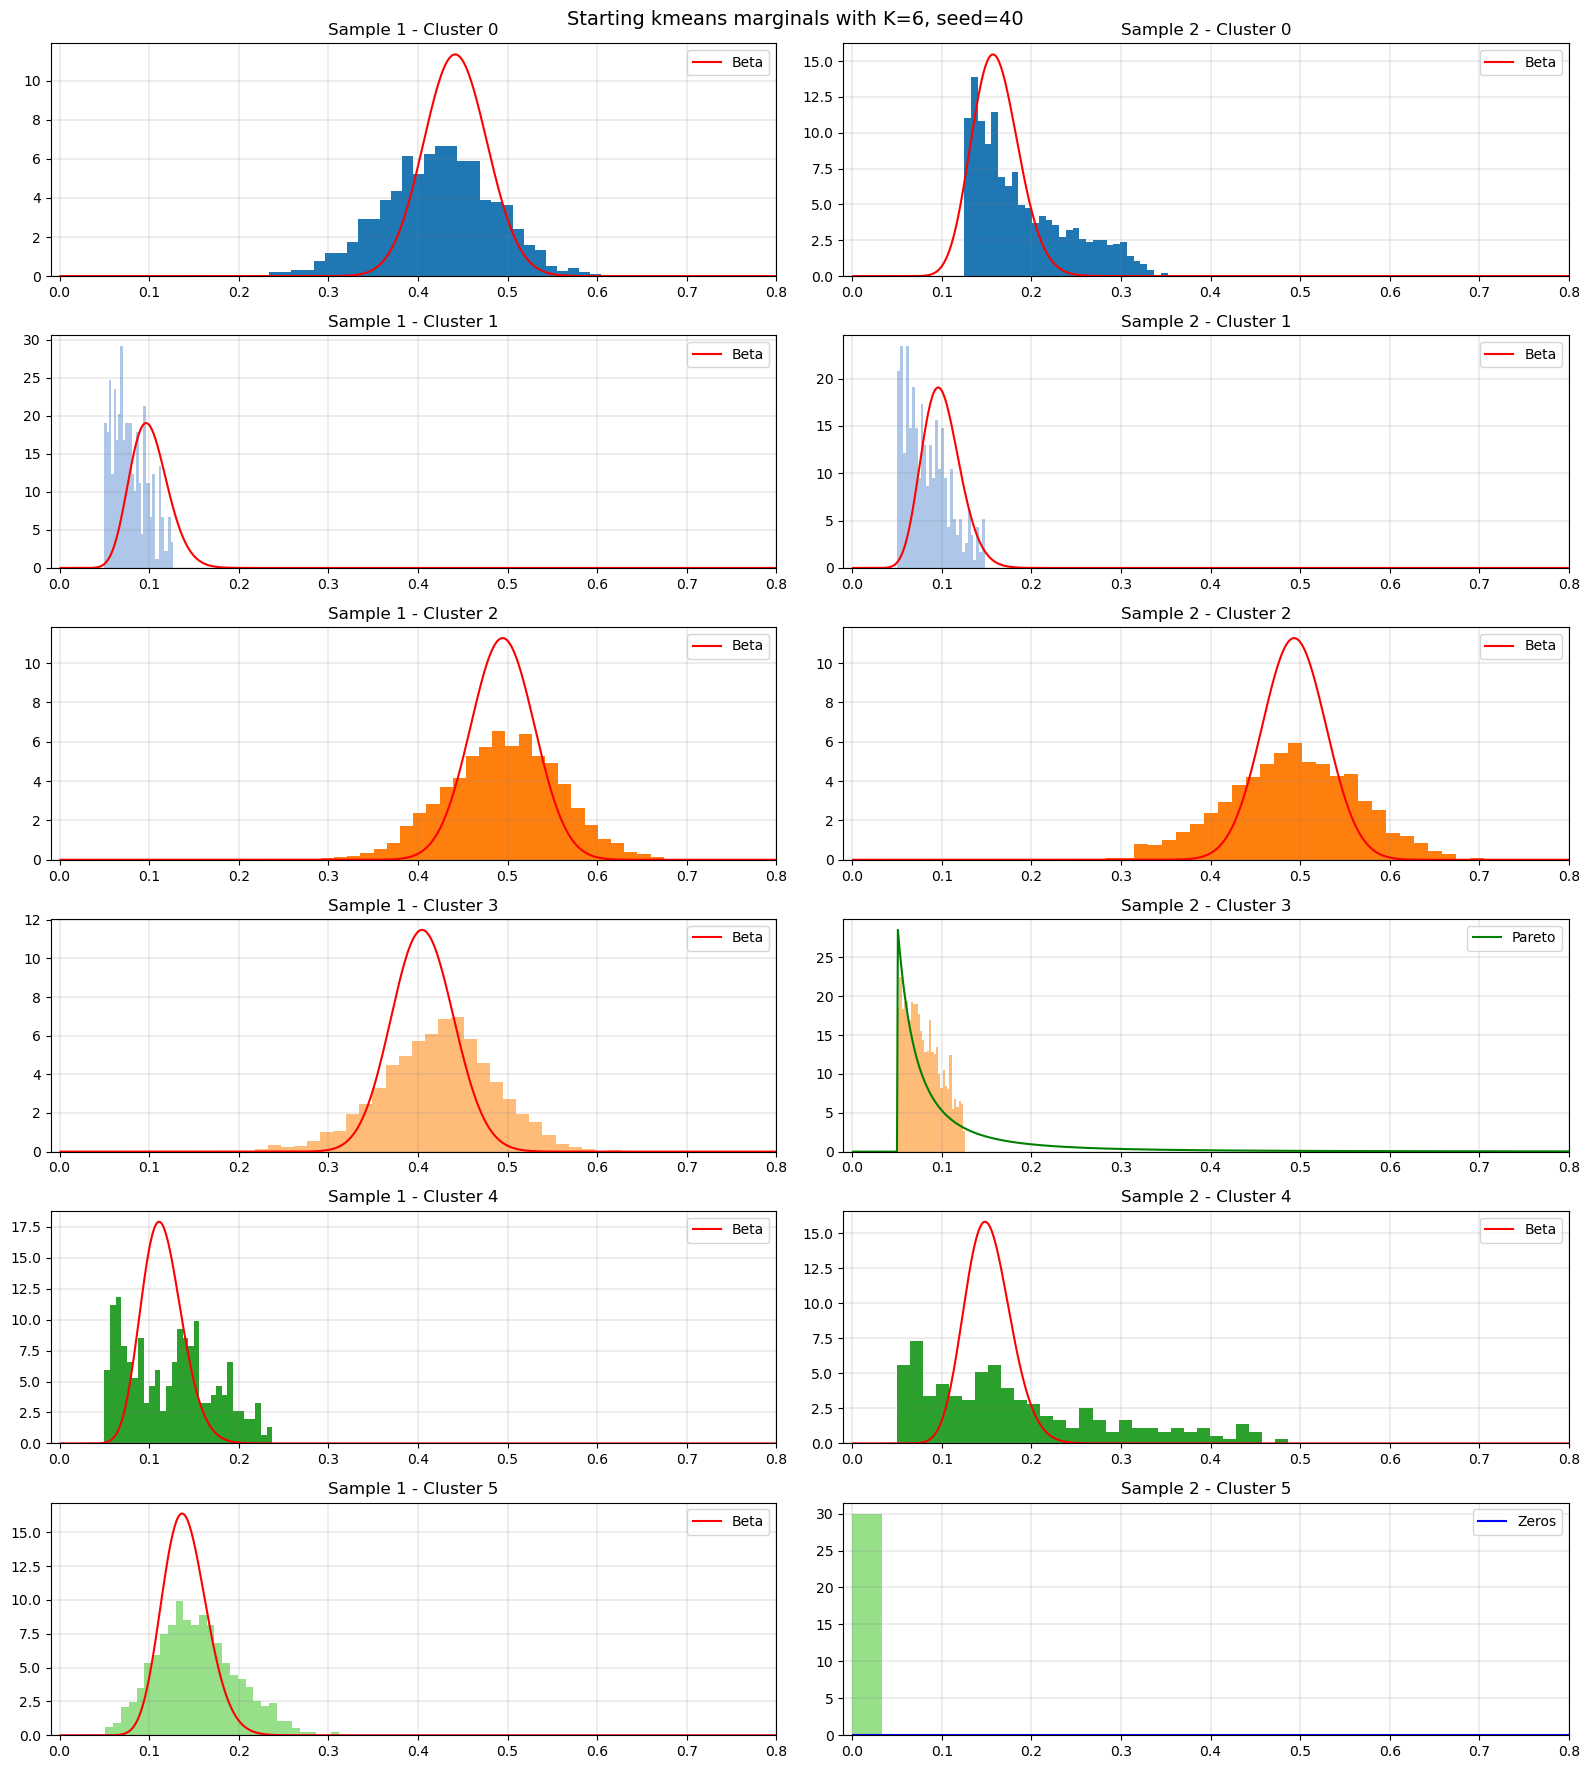

Iteration 0: Loss = 737178556.6646519
Iteration 50: Loss = 691339843.6229864
Iteration 100: Loss = 685362230.7871838
Iteration 150: Loss = 683459017.793228
Iteration 200: Loss = 682484877.6329213
Iteration 250: Loss = 681880279.7527868
Iteration 300: Loss = 681466543.9384307
Iteration 350: Loss = 681166478.8630486
Iteration 400: Loss = 680936041.6894202


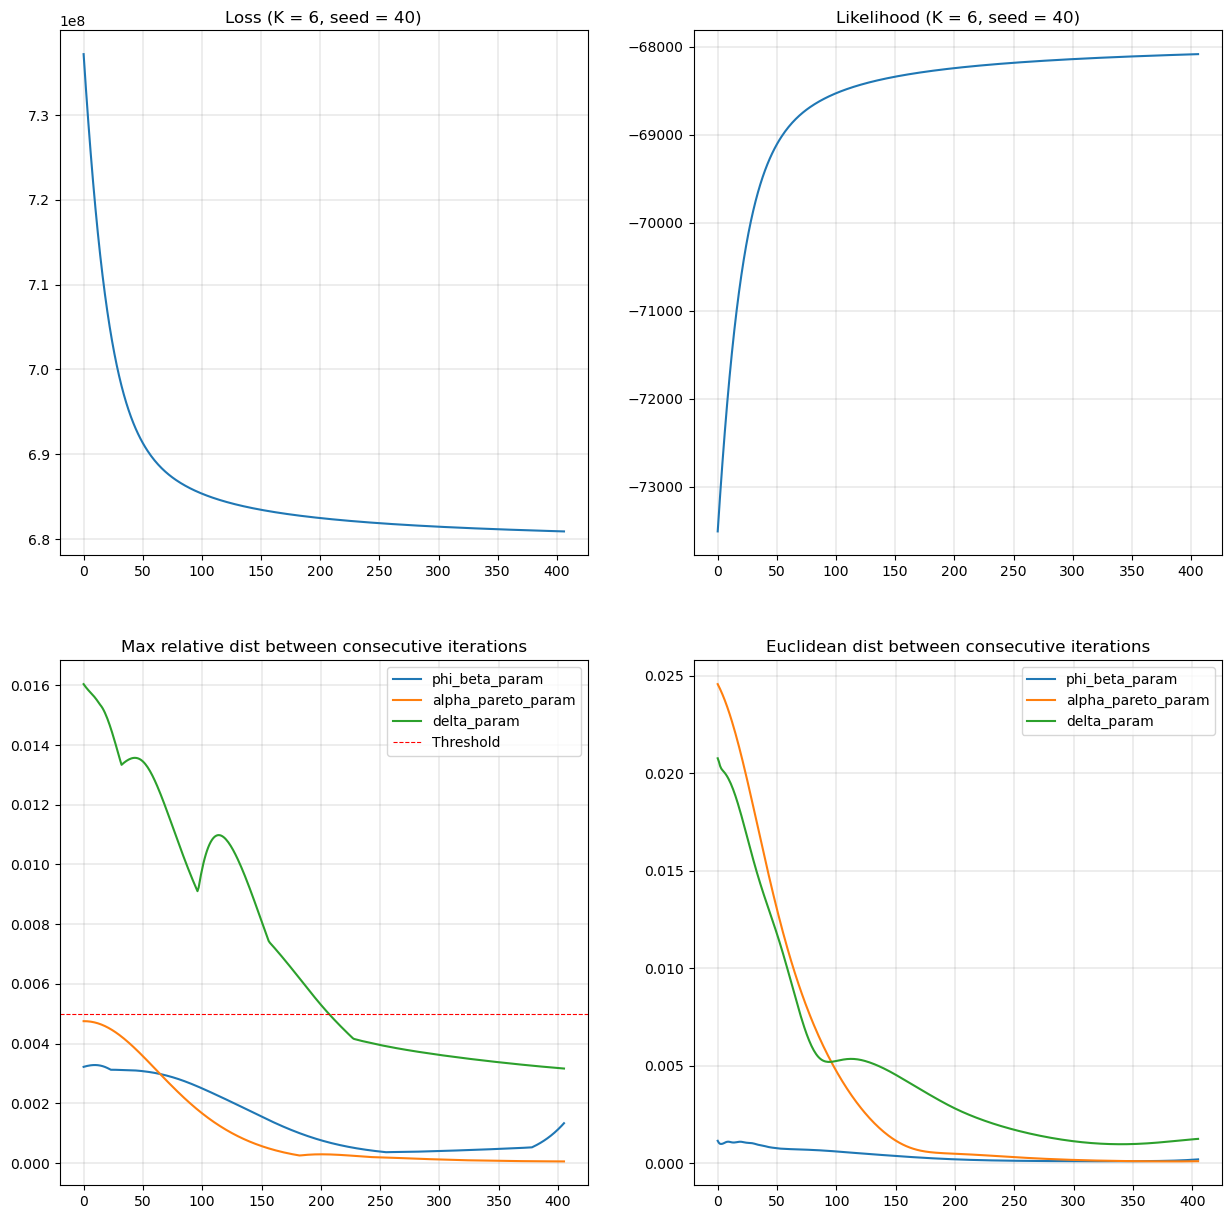

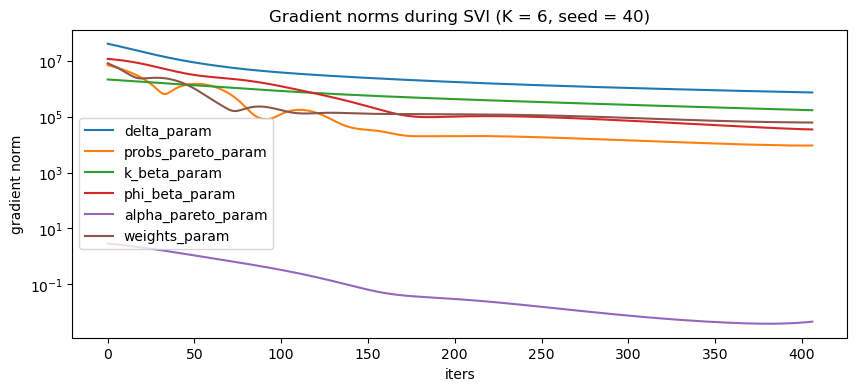

Inference lk:  -68084.48778790733
Final lk (integr):  tensor(-69069.1250, grad_fn=<SumBackward0>)
n_params:  90
n:  tensor(10000)
lk:  tensor(-69069.1250, grad_fn=<SumBackward0>)
bic: 138967.1875 



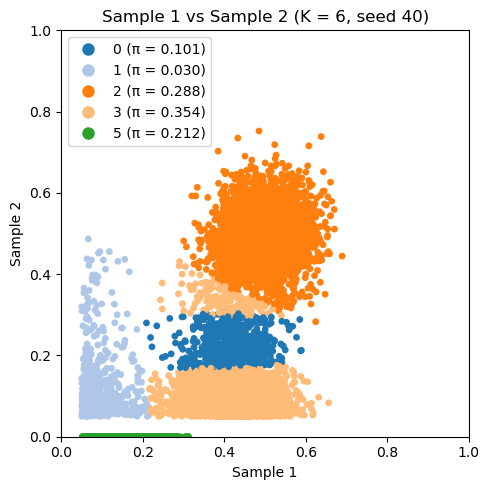

Time taken for K = 6 and seed = 40: 18.628 seconds
RUN WITH K = 6 AND SEED = 41
Minimum detected VAF: tensor(0.0500)


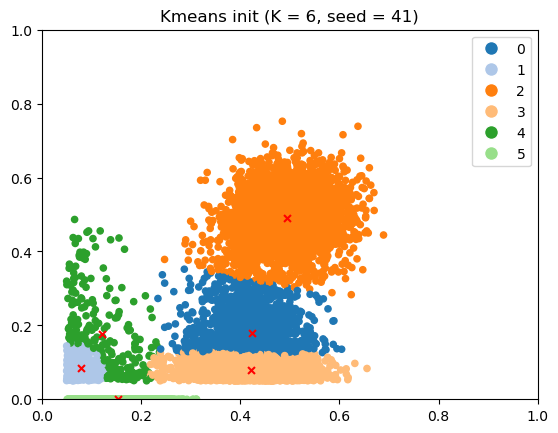

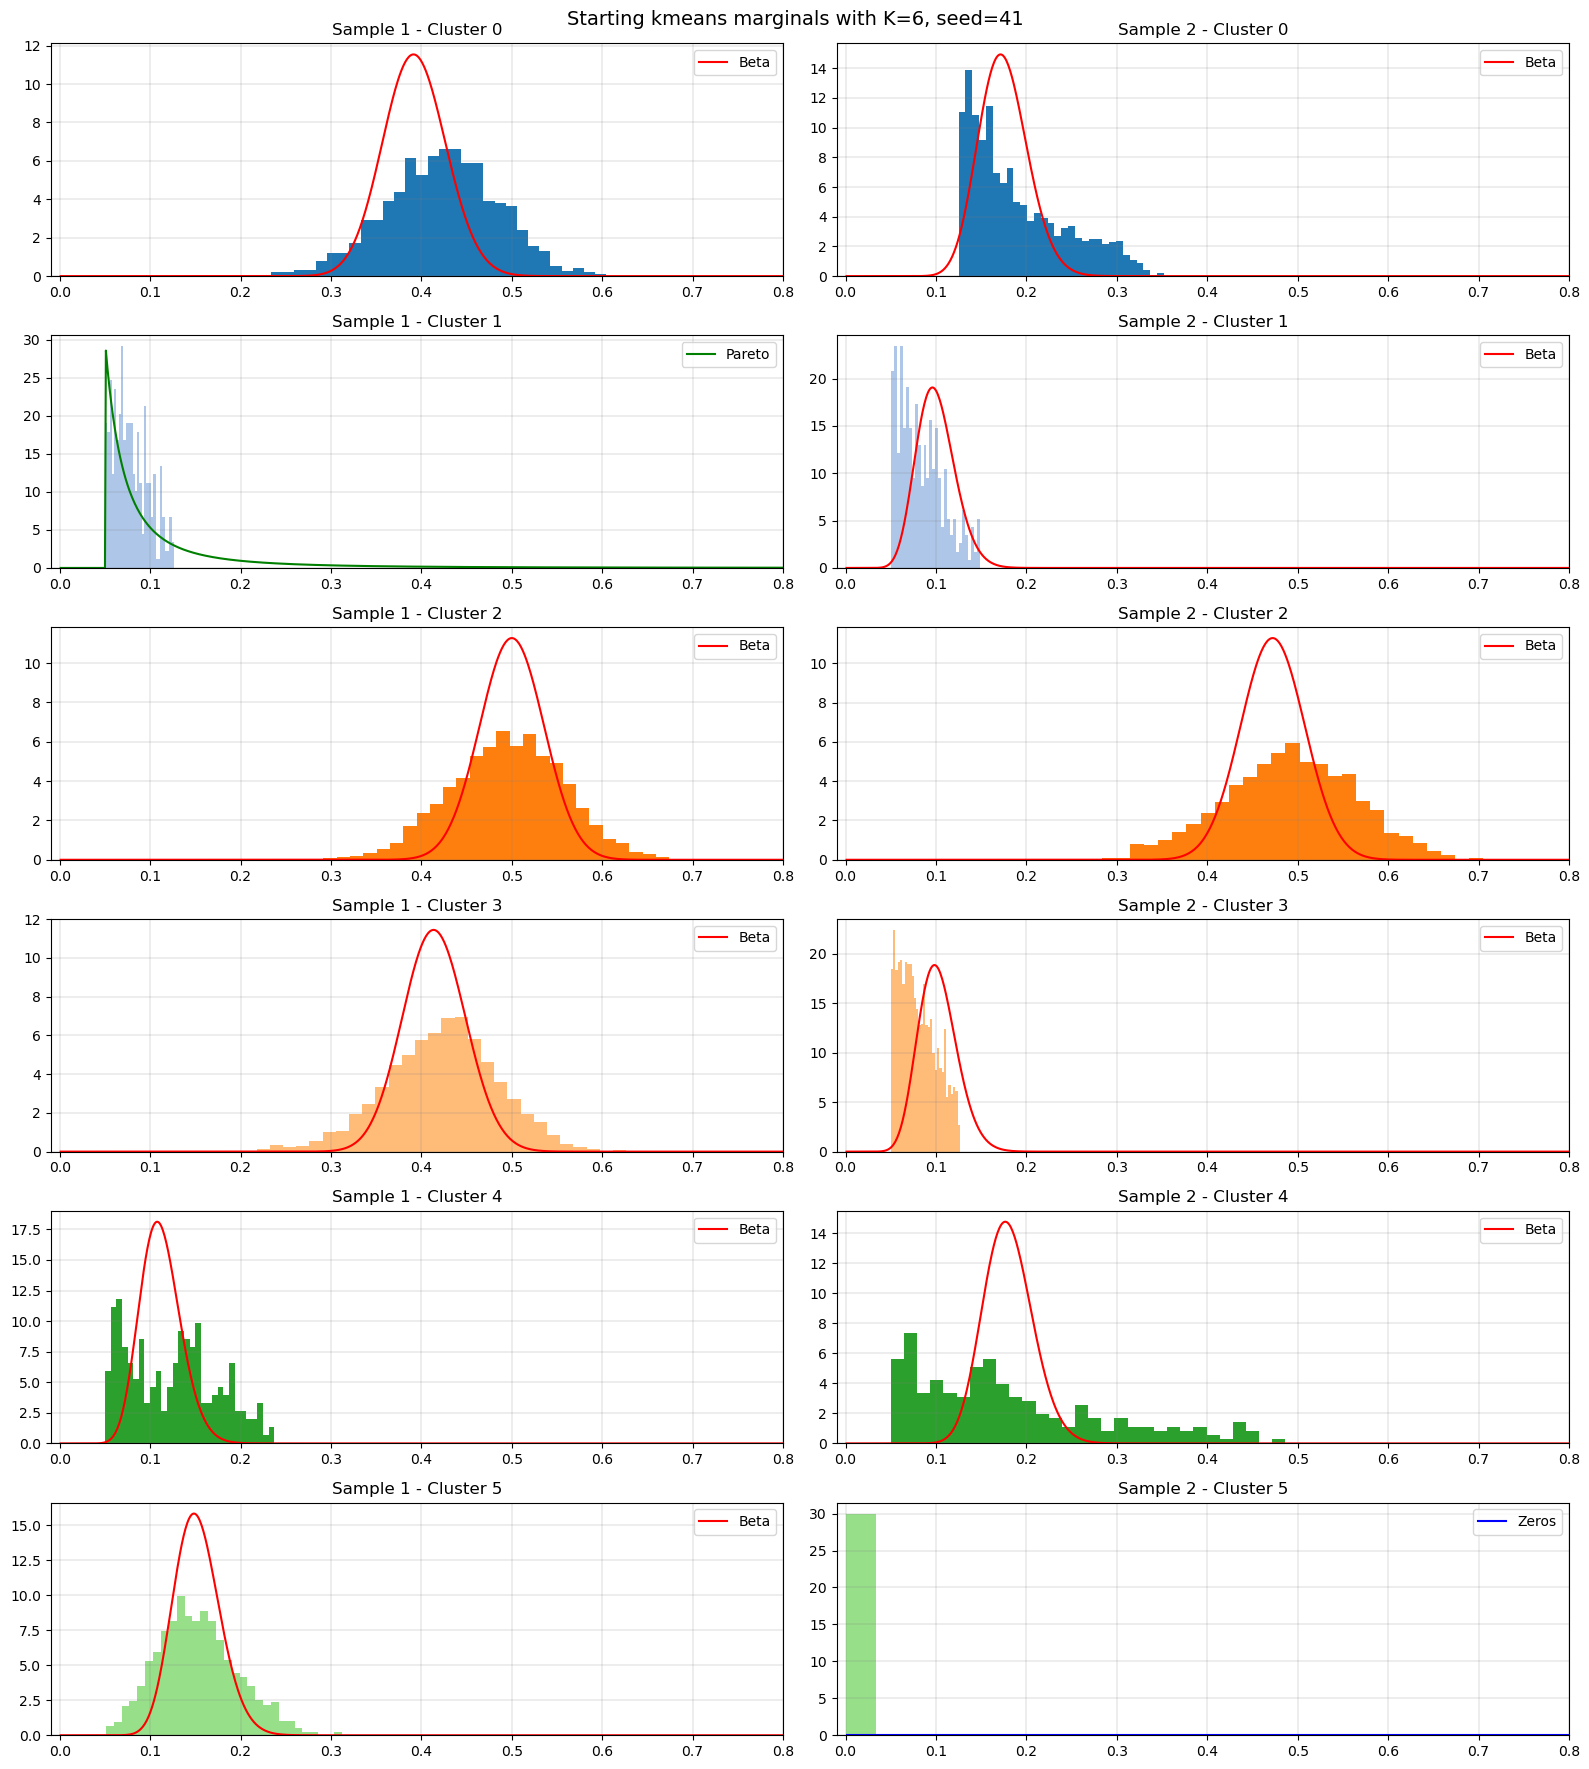

Iteration 0: Loss = 735186581.0689605
Iteration 50: Loss = 692690131.7771331
Iteration 100: Loss = 686611866.4230952
Iteration 150: Loss = 684126850.1831933
Iteration 200: Loss = 682938982.4178325
Iteration 250: Loss = 682251439.2298912
Iteration 300: Loss = 681782369.2444851
Iteration 350: Loss = 681438142.433892
Iteration 400: Loss = 681172438.8612009
Iteration 450: Loss = 680903942.9571787


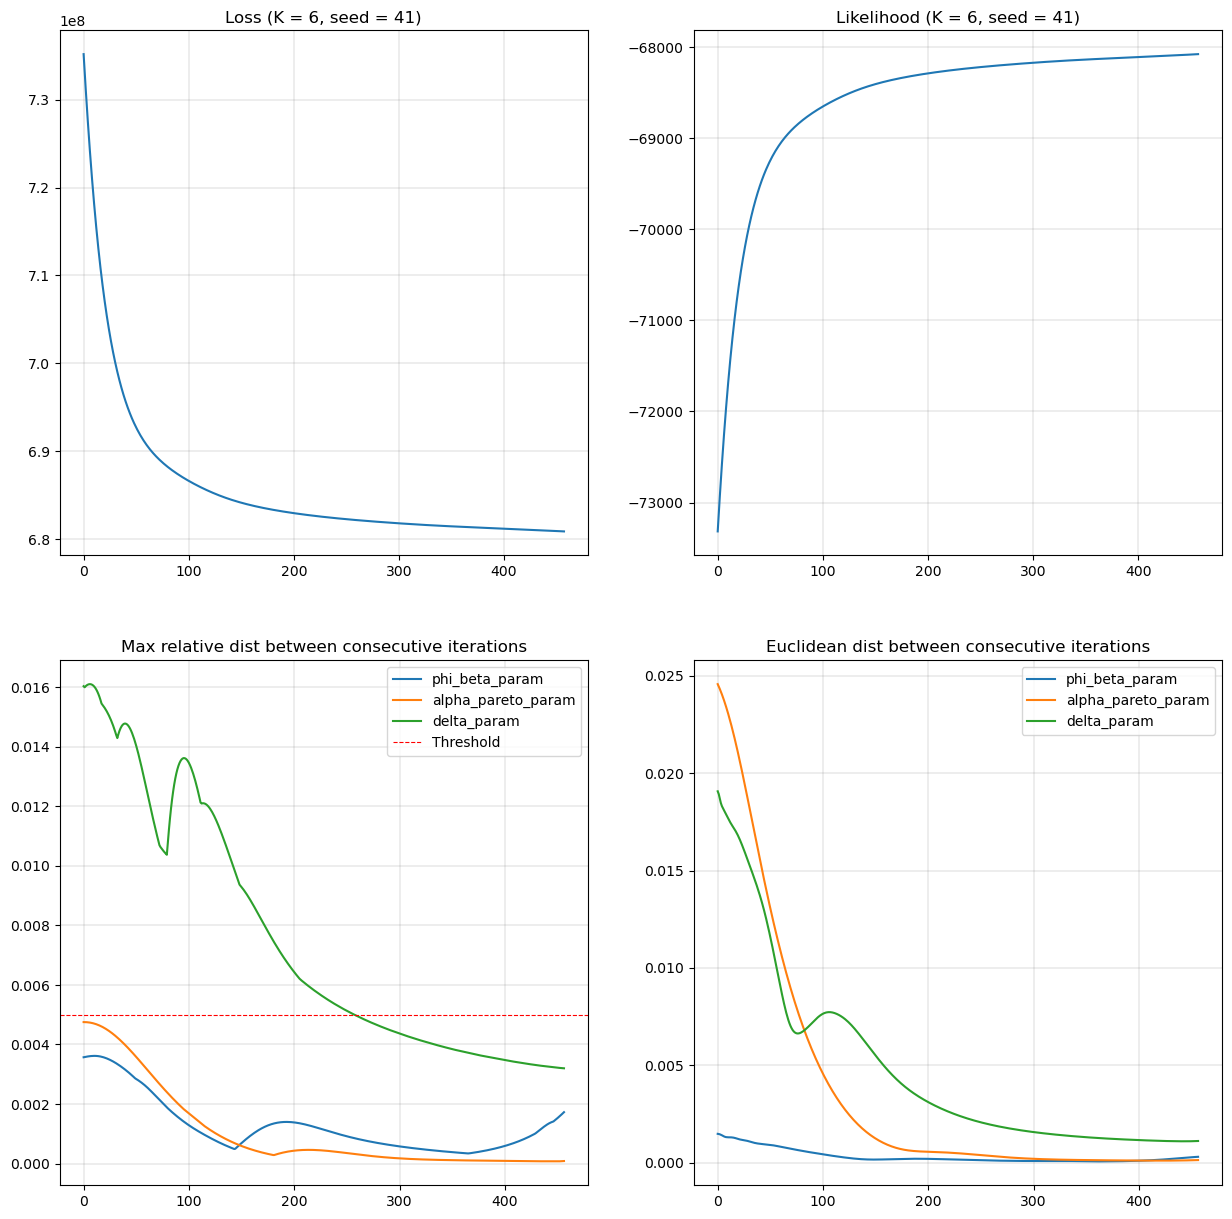

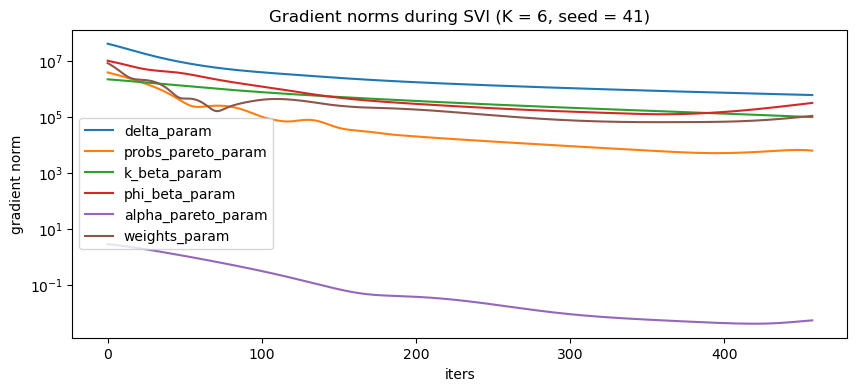

Inference lk:  -68078.1124609331
Final lk (integr):  tensor(-68632.6406, grad_fn=<SumBackward0>)
n_params:  90
n:  tensor(10000)
lk:  tensor(-68632.6406, grad_fn=<SumBackward0>)
bic: 138094.21875 



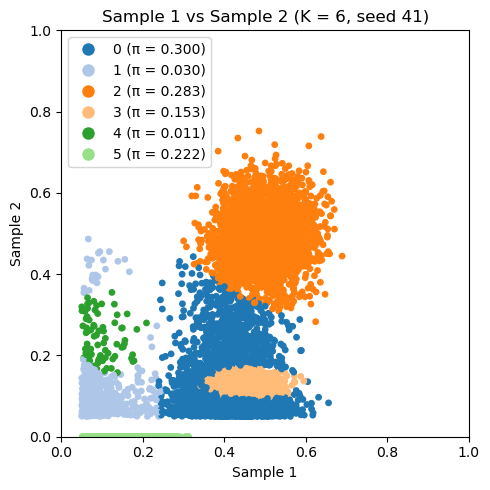

Time taken for K = 6 and seed = 41: 21.364 seconds


/Users/elenarivaroli/miniconda3/envs/mobster/lib/python3.11/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


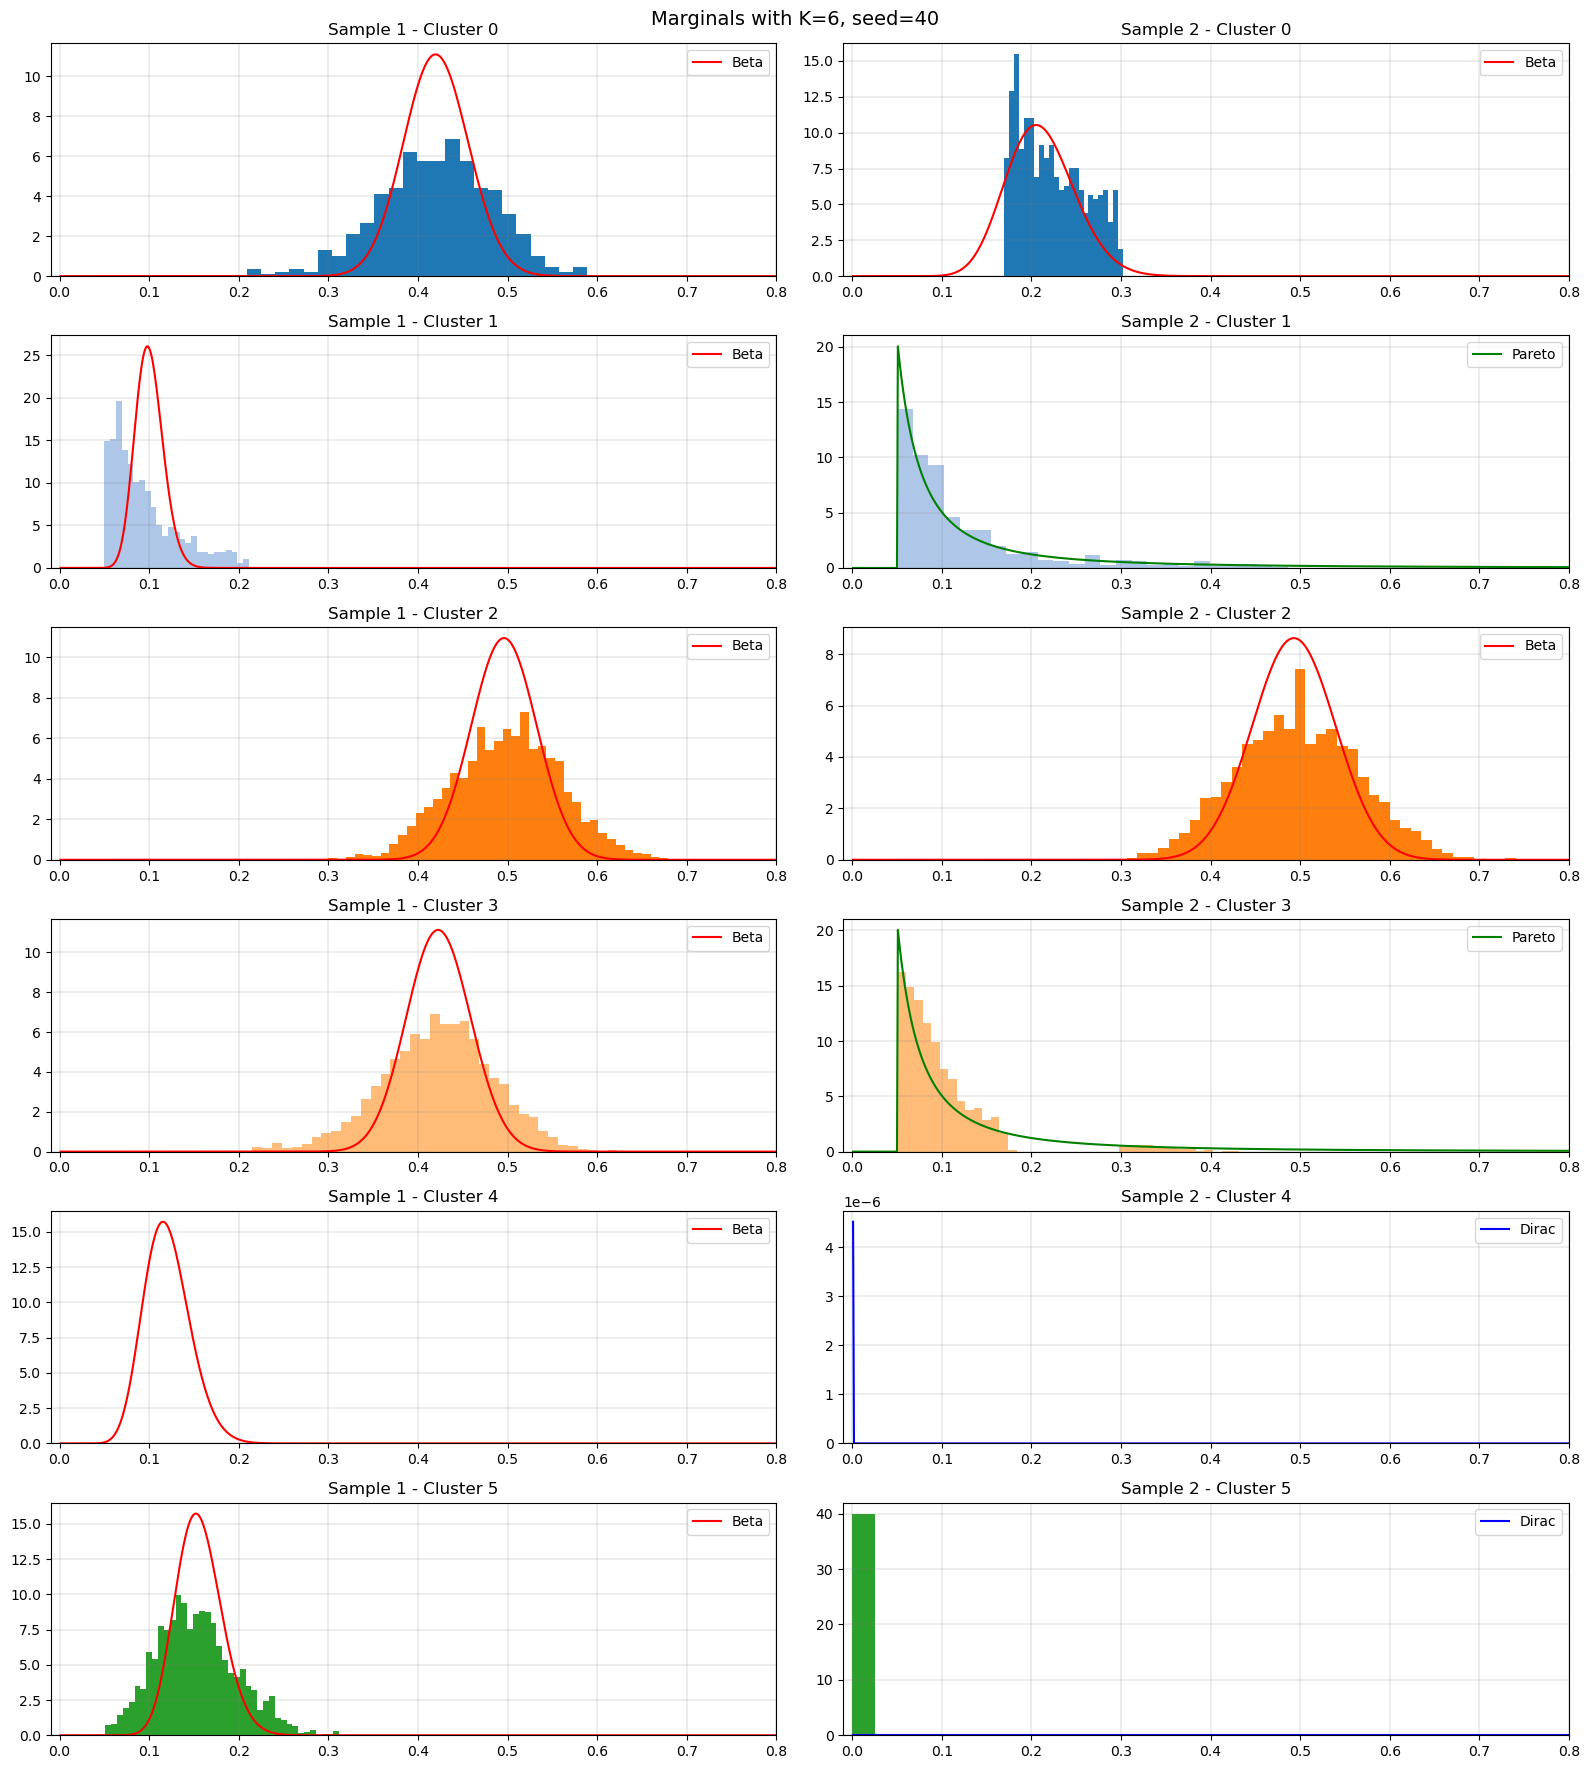

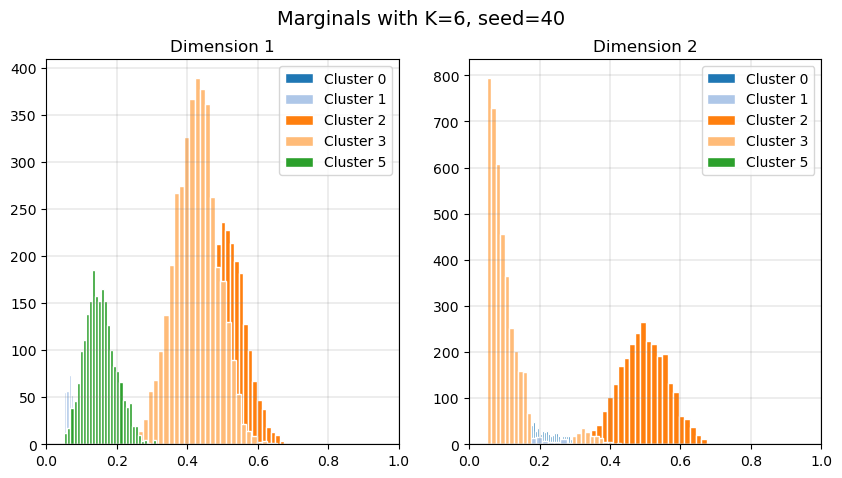

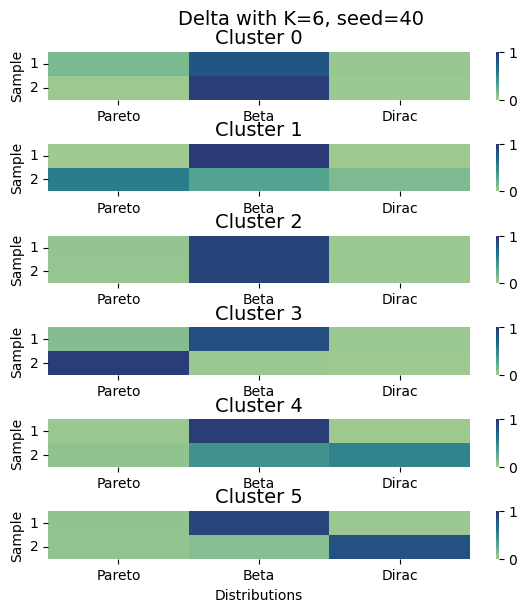

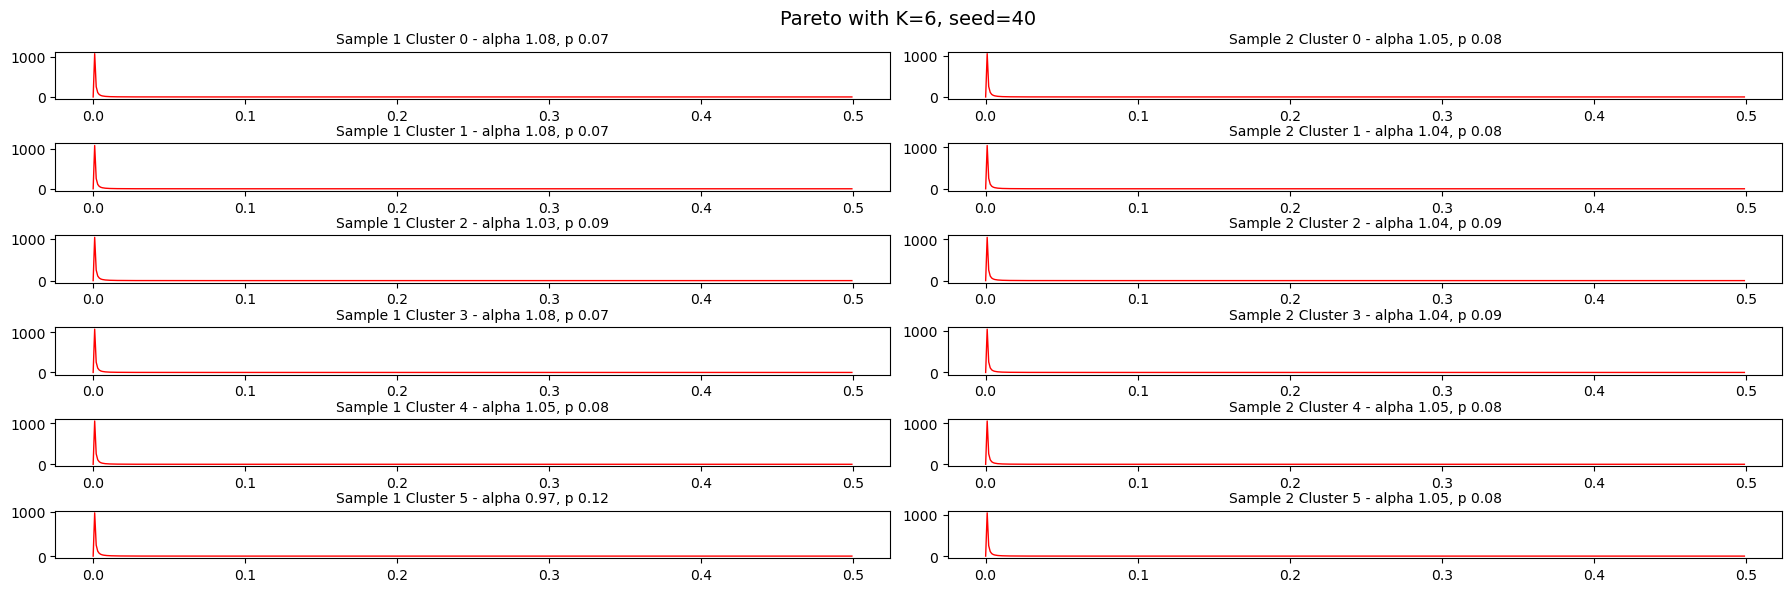

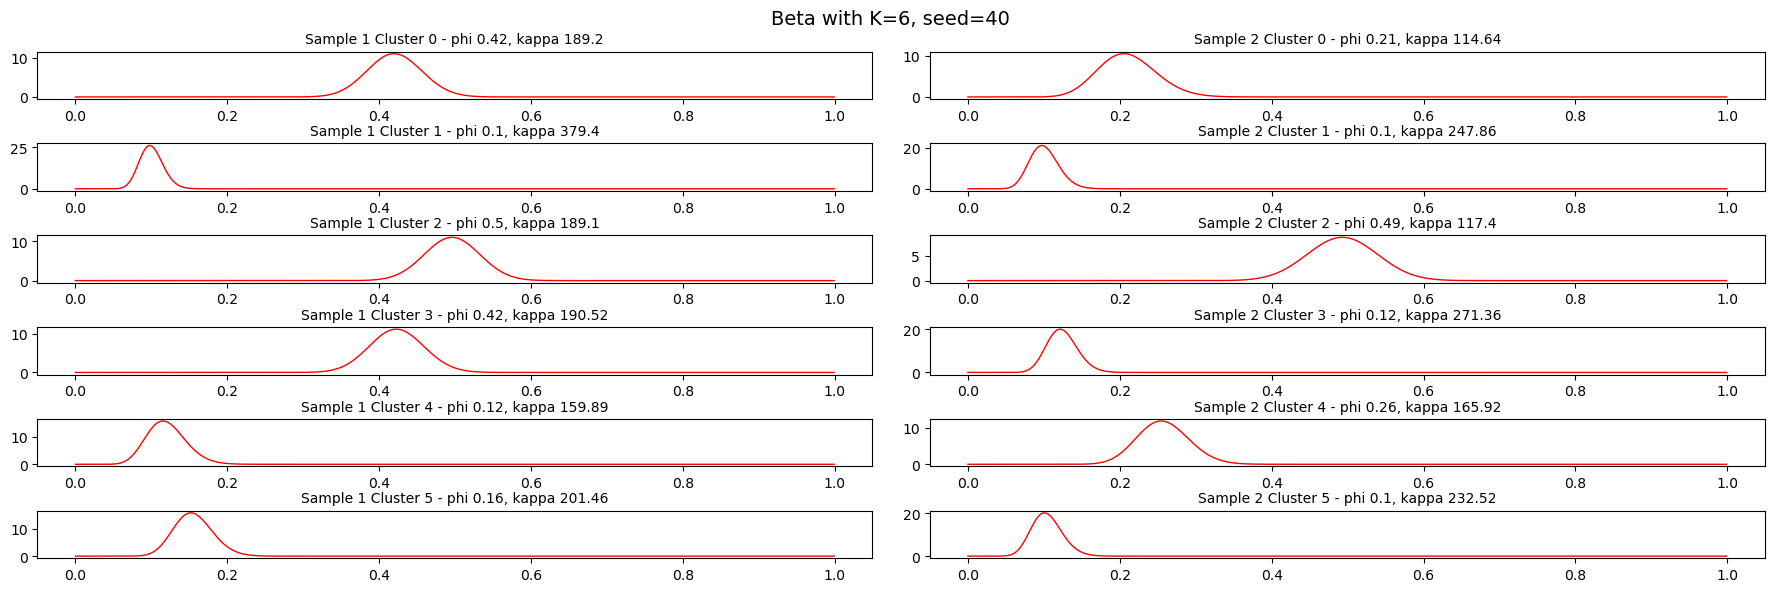

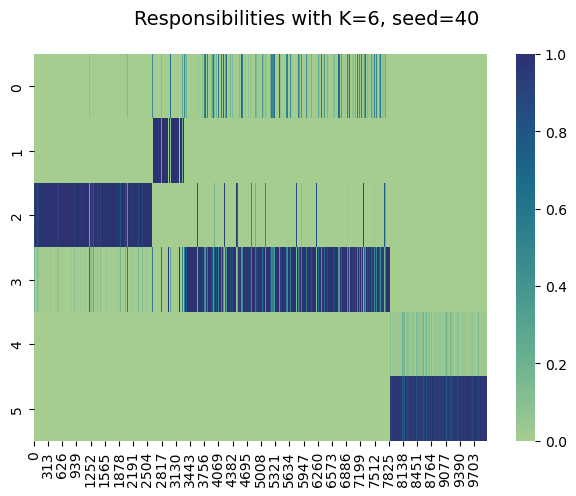

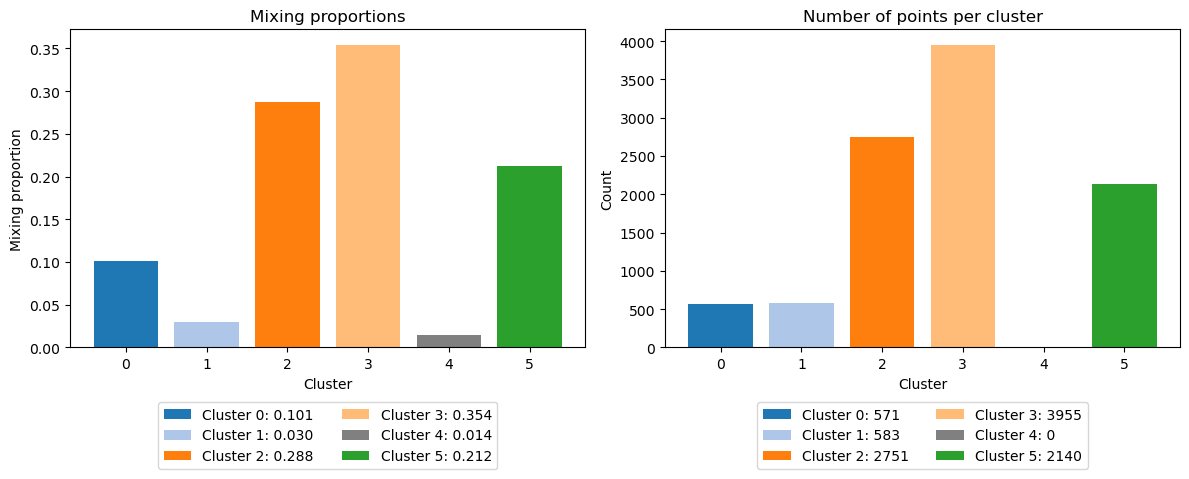

Selected number of clusters is 5 with seed 40


In [12]:
K_list = [3,4,5,6]
seed_list = [40,41]
mb_list, best_K, best_seed = model_mobster_mv.fit(NV, DP, num_iter = 2000, K = K_list, seed = seed_list, lr = 0.01)#, choice_init_centers = 'kmeans')

In [100]:
def get_a_beta(phi, kappa):
    return phi * (kappa)

def get_b_beta(phi, kappa):
    return (1-phi) * (kappa)

In [98]:
def beta_lk(mb,idx,  d, a_beta, b_beta):
    """
    Compute beta-binomial likelihood for a single dimension of a single cluster.
    """
    betabin = dist.BetaBinomial(a_beta, b_beta, total_count=mb.DP[idx,d]).log_prob(mb.NV[idx,d])
    return betabin # simply does log(weights) + log(density)

def expon_lk(mb, idx,  d):
    """
    Compute exponential likelihood for a single dimension of a single cluster.
    """
    exp = dist.Exponential(mb.rate_expon).log_prob(mb.NV[idx,d])
    return exp # simply does log(weights) + log(density)

def pareto_binomial_pmf_samp(mb, NV, DP, alpha):
    binom = dist.Binomial(total_count=DP, probs=0.12).log_prob(NV)
    return binom  # Convert the result to a list

def pareto_lk_samp(mb, idx, d, alpha):
    paretobin = pareto_binomial_pmf_samp(mb, NV=mb.NV[idx, d], DP=mb.DP[idx, d], alpha=alpha)
    return paretobin # tensor of len N (if D = 1, only N)

In [111]:
mb = mb_list[1]
s = 1
c = 2
d = s -1
vaf = NV[:,d]/DP[:,d]
labels = mb.params['cluster_assignments']
delta = mb.params['delta_param']
alpha = mb.params['alpha_pareto_param'][c,d]
print(alpha)
phi = mb.params['phi_beta_param'][c,d]
# phi = 0.12
# print(phi)
kappa = mb.params['k_beta_param'][c,d]
a_beta = get_a_beta(phi, kappa)
b_beta = get_b_beta(phi, kappa)
idx = np.where((labels == c) )[0]
# idx = np.where((labels == c) & (vaf.numpy() < 0.3))[0]
print("Pareto integr: ", pareto_lk(mb, idx, d, alpha).sum())
print("Pareto samp: ", pareto_lk_samp(mb, idx, d, alpha).sum())
print("Beta: ",beta_lk(mb, idx,  d, a_beta, b_beta).sum())


tensor(0.9346, grad_fn=<SelectBackward0>)
Pareto integr:  tensor(-2024.5214)
Pareto samp:  tensor(-2009.0540)
Beta:  tensor(-1774.8040, grad_fn=<SumBackward0>)


In [34]:
def beta_lk(data, phi,kappa):
    """
    Compute log probabilities of beta for a single dimension of a single cluster.
    """
    a_beta = get_a_beta(phi,kappa)
    b_beta = get_b_beta(phi,kappa)
    beta = dist.Beta(a_beta, b_beta).log_prob(data)
    return beta

def pareto_lk(data, alpha, pareto_L, pareto_H):
    """
    Compute log probabilities of pareto for a single dimension of a single cluster.
    """
    pareto = BoundedPareto(pareto_L, alpha, pareto_H).log_prob(data)
    return pareto

start = 0.05
end = 0.5
step = 0.001
vaf_range = torch.arange(start, end, step)
pareto_L = torch.tensor(0.05)
pareto_H = torch.tensor(0.5)
pareto_ = []
beta_ = []
for i in vaf_range:
    pareto_.append(pareto_lk(i, alpha, pareto_L, pareto_H).detach().numpy())
    beta_.append(beta_lk(i, phi, kappa).detach().numpy())


In [23]:
for i in range(len(vaf_range)):
    if beta_[i]>pareto_[i]:
        print(vaf_range[i])
        break

tensor(0.0830)


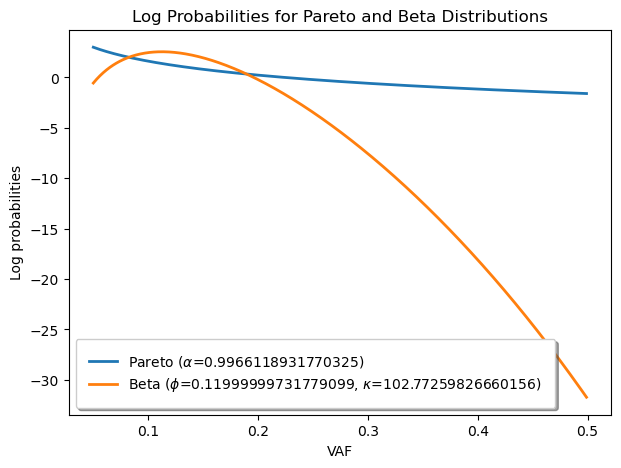

In [24]:
plt.figure(figsize=(7, 5))
plt.plot(vaf_range, pareto_, label=f'Pareto ($\\alpha$={alpha})', linestyle='-', linewidth=2)
plt.plot(vaf_range, beta_, label=f'Beta ($\\phi$={phi}, $\\kappa$={kappa})', linestyle='-', linewidth=2)

plt.xlabel('VAF')
plt.ylabel('Log probabilities')
plt.title('Log Probabilities for Pareto and Beta Distributions')
plt.legend(loc ='best',fontsize=10, frameon=True, shadow=True, borderpad=1)
# plt.grid()
# plt.ylim([-150,10])

plt.show()

In [140]:
delta

tensor([[[0.4564, 0.3746, 0.1690],
         [0.3582, 0.4626, 0.1792]],

        [[0.2505, 0.5501, 0.1994],
         [0.2705, 0.5309, 0.1986]],

        [[0.4192, 0.4115, 0.1693],
         [0.3977, 0.4344, 0.1678]]], grad_fn=<DivBackward0>)

### Negative binomial for DP

In [40]:
sets = [55, 57, 59, 62]
s_number = 7

data = pd.read_csv("./data/real_data/Set7_mutations.csv")

# data = pd.read_csv("./data/real_data/Set6_mutations.csv")

# sets = [42, 44, 45, 46, 47, 48]
# s_number = 6

NV_list = []
DP_list = []

for s in sets:
    NV = torch.tensor(data[f'Set{s_number}_{s}.NV'].to_numpy())
    DP = torch.tensor(data[f'Set{s_number}_{s}.DP'].to_numpy())
    
    NV_list.append(NV.view(-1, 1))  # Ensure correct shape
    DP_list.append(DP.view(-1, 1))  # Ensure correct shape
NV = torch.cat(NV_list, dim=1)
DP = torch.cat(DP_list, dim=1)

In [62]:
data = DP[:,2].numpy()

3577

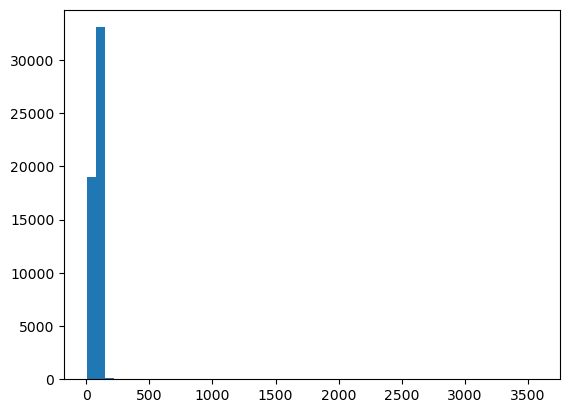

In [49]:
plt.hist(DP[:,0].numpy(), bins = 50);
np.max(DP[:,0].numpy())

In [63]:
mean_coverage = np.mean(data)
median_coverage = np.median(data)

variance = np.var(data)

# Calculate Overdispersion Index
overdispersion_index = variance / mean_coverage
# overdispersion_index = (variance**2 - mean_coverage)/(mean_coverage**2)

print(mean_coverage, median_coverage, variance)

73.56844660194174 74.0 986.5715286549157


tensor([[109,  83, 148],
        [ 93, 160,  95],
        [139,  97,  84],
        ...,
        [115, 110,  78],
        [ 88,  86,  94],
        [ 86, 116,  67]])


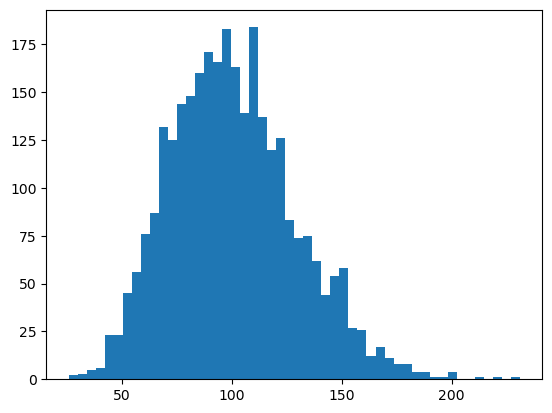

In [ ]:
import scipy.stats as stats
N = 1000
D = 3
variance = 800
mean = 100
probs = mean/variance
n = mean**2/(variance-mean)

neg_bin = stats.nbinom.rvs(n, probs, size=N*D)
# neg_bin = dist.NegativeBinomial(total_count=n, probs=probs).sample([1000])
print(torch.tensor(neg_bin).reshape([N,D]))
plt.hist(neg_bin, bins = 50);

In [26]:
data = pd.read_csv("./data/gbm.csv")

sets = ['primary', 'relapse']

NV_list = []
DP_list = []

for s in sets:
    NV = torch.tensor(data[f'NV_{s}'].to_numpy())
    DP = torch.tensor(data[f'DP_{s}'].to_numpy())
    
    NV_list.append(NV.view(-1, 1))  # Ensure correct shape
    DP_list.append(DP.view(-1, 1))  # Ensure correct shape
NV = torch.cat(NV_list, dim=1)
DP = torch.cat(DP_list, dim=1)

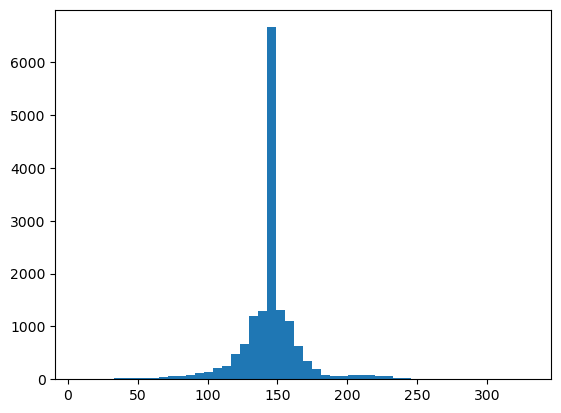

In [74]:
plt.hist(DP[:,0].numpy(), bins = 50);

In [73]:
data = DP[:,0].numpy()
mean_coverage = np.mean(data)
median_coverage = np.median(data)

variance = np.var(data)

print(mean_coverage, median_coverage, variance)

144.46923076923076 145.0 542.4309763313609


### Prior over alpha

(0.0, 5.0)

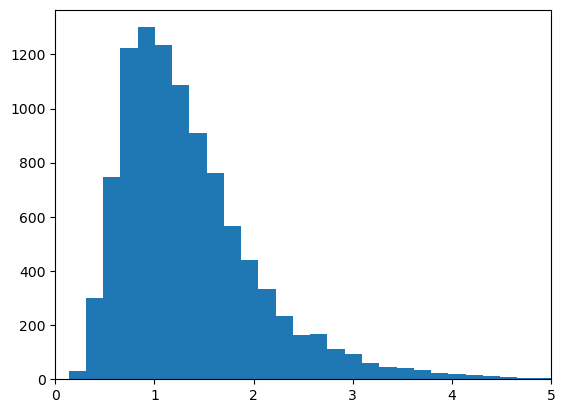

In [83]:
import pyro.distributions as dist
import torch
alpha_pareto_mean = torch.tensor(1.2)
alpha_pareto_std = torch.tensor(0.5)
a = dist.LogNormal(torch.log(alpha_pareto_mean), alpha_pareto_std).sample([10000])
plt.hist(a.numpy(), bins = 50);
plt.xlim([0,5])

(0.0, 5.0)

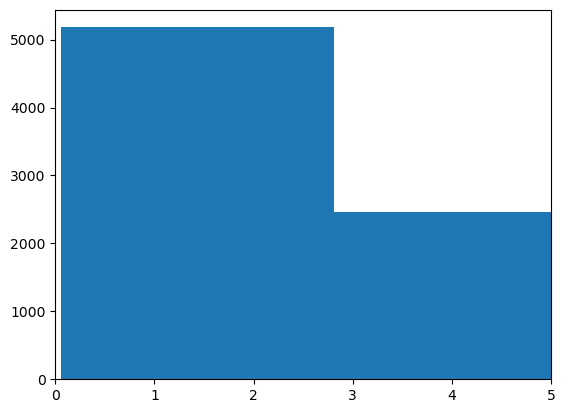

In [37]:
import pyro.distributions as dist
import torch
alpha_pareto_mean = torch.tensor(2.7)
alpha_pareto_std = torch.tensor(1.)
a = dist.LogNormal(torch.log(alpha_pareto_mean), alpha_pareto_std).sample([10000])
plt.hist(a.numpy(), bins = 50);
plt.xlim([0,5])

In [63]:
torch.log(alpha_pareto_mean)

tensor(0.1823)

1.0
tensor([0.2314, 0.4512, 0.6132,  ..., 1.4365, 1.5667, 2.0366])


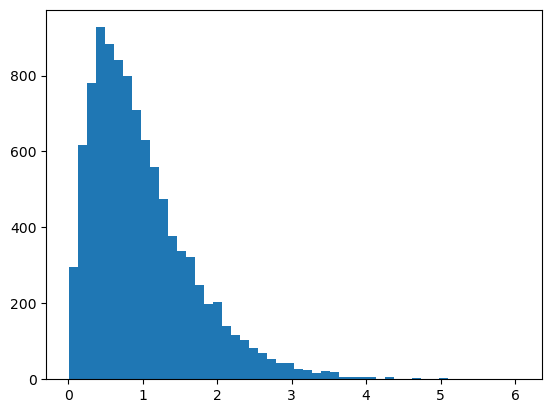

In [ ]:
a_gamma = 3
b_gamma = 3
a = dist.Gamma(a_gamma,b_gamma).sample([10000])
print(a_gamma/b_gamma)
print(a)
plt.hist(a.numpy(), bins = 50);
# plt.xlim([0,5])

tensor(3.7622)
tensor(1.3625)


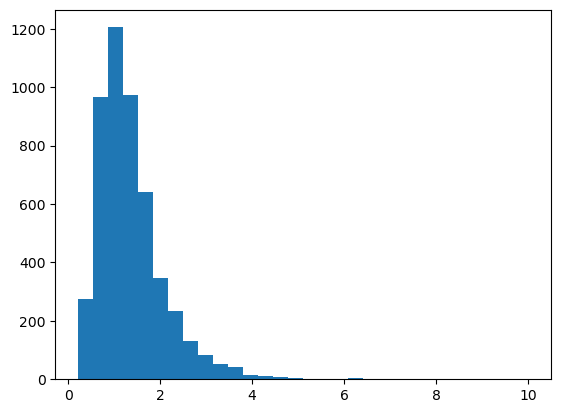

In [36]:
import pyro.distributions as dist
import torch
alpha_pareto_mean = torch.tensor(1.2)
alpha_pareto_std = torch.tensor(0.5)
mean = torch.exp(alpha_pareto_mean + 0.5*alpha_pareto_std**2)
print(mean)
a = dist.LogNormal(torch.log(alpha_pareto_mean), alpha_pareto_std).sample([5000])
print(torch.mean(a))
plt.hist(a.numpy(), bins = 30);

(0.0, 5.0)

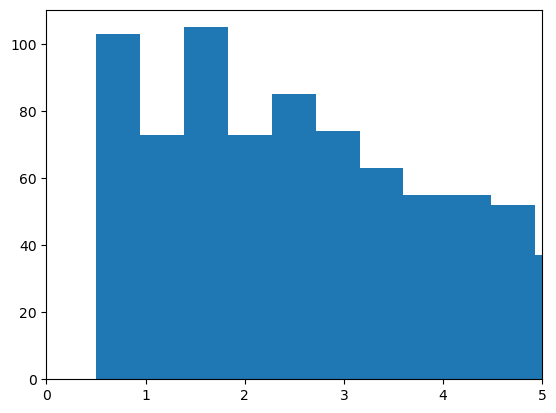

In [13]:
a = dist.HalfNormal(4).sample([1000])
plt.hist(a.numpy() + 0.5, bins = 30);
plt.xlim([0,5])

### Approximated Dirac

In [50]:
data = pd.read_csv("./data/real_data/Set6_mutations.csv")

sets = [42, 44, 45, 46, 47, 48]
s_number = 6

data = pd.read_csv("./data/real_data/Set7_mutations.csv")

sets = [55, 57, 59, 62]
s_number = 7

NV_list = []
DP_list = []

for s in sets:
    NV = torch.tensor(data[f'Set{s_number}_{s}.NV'].to_numpy())
    DP = torch.tensor(data[f'Set{s_number}_{s}.DP'].to_numpy())
    
    NV_list.append(NV.view(-1, 1))  # Ensure correct shape
    DP_list.append(DP.view(-1, 1))  # Ensure correct shape
NV = torch.cat(NV_list, dim=1)
DP = torch.cat(DP_list, dim=1)

In [68]:
a = 10e-4
b = 10e4
bb = dist.BetaBinomial(a, b, total_count = 100).sample([2000])
(bb != 0).sum()

tensor(0)

tensor([1.1755e-38, 1.1755e-38, 1.1755e-38, 1.1755e-38, 1.1755e-38, 1.1755e-38,
        1.1755e-38, 1.1755e-38, 1.1755e-38, 1.1755e-38, 1.1755e-38, 1.1755e-38,
        1.1755e-38, 1.1755e-38, 1.1755e-38, 1.1755e-38, 1.1755e-38, 1.1755e-38,
        1.1755e-38, 1.1755e-38, 1.1755e-38, 1.1755e-38, 1.1755e-38, 1.1755e-38,
        1.1755e-38, 1.1755e-38, 1.1755e-38, 1.1755e-38, 1.1755e-38, 1.1755e-38,
        1.1755e-38, 1.1755e-38, 1.1755e-38, 1.1755e-38, 1.1755e-38, 1.1755e-38,
        1.1755e-38, 1.1755e-38, 1.1755e-38, 1.1755e-38, 1.1755e-38, 1.1755e-38,
        1.1755e-38, 1.1755e-38, 1.1755e-38, 1.1755e-38, 1.1755e-38, 1.1755e-38,
        1.1755e-38, 1.1755e-38, 1.1755e-38, 1.1755e-38, 1.1755e-38, 1.1755e-38,
        1.1755e-38, 1.1755e-38, 1.1755e-38, 1.1755e-38, 1.1755e-38, 1.1755e-38,
        1.1755e-38, 1.1755e-38, 1.1755e-38, 1.1755e-38, 1.1755e-38, 1.1755e-38,
        1.1755e-38, 1.1755e-38, 1.1755e-38, 1.1755e-38, 1.1755e-38, 1.1755e-38,
        1.1755e-38, 1.1755e-38, 1.1755e-

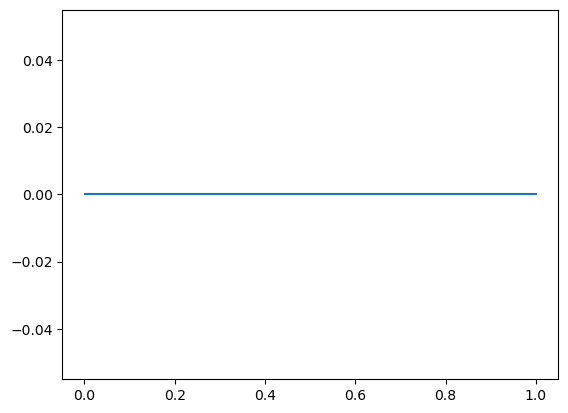

In [45]:
a = 10e-6
b = 10e6
print(dist.Beta(a, b).sample([1000]))

x = np.linspace(0, 1, 1000)
pdf = beta.pdf(x, a, b)
plt.plot(x, pdf)
# plt.xlim([0,0.2])

### Hitchhikers

In [20]:
NV = pd.read_csv("./data/hitchhikers/NV_bigger.csv")
DP = pd.read_csv("./data/hitchhikers/DP_bigger.csv")
NV = torch.tensor(NV.values)
DP = torch.tensor(DP.values)
print(NV.shape, DP.shape)
purity = 1

torch.Size([37202, 2]) torch.Size([37202, 2])


In [3]:
data = pd.read_csv("./data/gbm_B7R7.csv")

sets = ['primary', 'relapse']

NV_list = []
DP_list = []

for s in sets:
    NV = torch.tensor(data[f'NV_{s}'].to_numpy())
    DP = torch.tensor(data[f'DP_{s}'].to_numpy())
    
    NV_list.append(NV.view(-1, 1))  # Ensure correct shape
    DP_list.append(DP.view(-1, 1))  # Ensure correct shape
NV = torch.cat(NV_list, dim=1)
DP = torch.cat(DP_list, dim=1)
purity = 0.9

In [23]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
inertia_list = []

seed = 42

K_range = range(3, 15)

bic_values = []
aic_values = []
data = (NV/DP).numpy()
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=seed, n_init=5).fit(data)
    centers = torch.tensor(kmeans.cluster_centers_)
    inertia = kmeans.inertia_
    # print('K = ', k, ': ', inertia)
    inertia_list.append(inertia)
    # print(k)
    gmm = GaussianMixture(n_components=k, random_state=seed).fit(data)
    bic = gmm.bic(data)
    aic = gmm.aic(data)
    bic_values.append(bic)
    aic_values.append(aic)
    print('K = ', k, ': ', bic, aic)

k_min_inertia = K_range[np.argmin(inertia_list)]
k_min_bic = K_range[np.argmin(bic_values)]
k_min_aic = K_range[np.argmin(aic_values)]

print(f"K min inertia: {k_min_inertia}")
print(f"K min BIC: {k_min_bic}")
print(f"K min AIC: {k_min_aic}")

K =  3 :  -372868.03661391593 -373012.9466165543
K =  4 :  -432358.3986914075 -432554.45340085943
K =  5 :  -458226.66862561076 -458473.86804187624
K =  6 :  -508710.10131784604 -509008.445440925
K =  7 :  -517874.3047179912 -518223.79354788375
K =  8 :  -523867.40991150984 -524268.04344821593
K =  9 :  -529693.2668749992 -530145.0451185188
K =  10 :  -546539.1463100746 -547042.0692604077
K =  11 :  -548956.2486297269 -549510.3162868737
K =  12 :  -549100.9070978654 -549706.1194618256
K =  13 :  -549284.4104069615 -549940.7674777352
K =  14 :  -549233.3167149889 -549940.8184925762
K min inertia: 14
K min BIC: 13
K min AIC: 14


In [30]:
vaf = NV.numpy()/DP.numpy()
cond = np.where(np.all(((vaf == 0) | (vaf >= 0.03)), axis=1))[0]
NV = NV[cond,:]
DP = DP[cond,:]

In [31]:
best_bic_single_k = float('inf')
best_bic = float('inf')
best_centers = None
best_labels = None
best_centers_single_k = None
best_labels_single_k = None
best_k = None

seed = 42

K_range = range(3, 15)
for k in K_range:
    for seed in range(1, 10):
        gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=seed).fit((NV/DP).numpy())
        bic = gmm.bic((NV/DP).numpy())
        # Update best results if current bic is lower
        if bic < best_bic_single_k:
            best_bic_single_k = bic
            best_labels_single_k = torch.tensor(gmm.predict((NV/DP).numpy()))
            best_centers_single_k = torch.tensor(gmm.means_)
    if best_bic_single_k < best_bic:
        best_k = k
        best_labels = best_labels_single_k.clone()
        best_centers = best_centers_single_k.clone()
print("Best K using BIC: ", best_k)

Best K using BIC:  14


In [32]:
best_aic_single_k = float('inf')
best_aic = float('inf')
best_centers = None
best_labels = None
best_centers_single_k = None
best_labels_single_k = None
best_k = None

seed = 42

K_range = range(3, 15)
for k in K_range:
    for seed in range(1, 10):
        gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=seed).fit((NV/DP).numpy())
        aic = gmm.aic((NV/DP).numpy())
        # Update best results if current bic is lower
        if aic < best_aic_single_k:
            best_aic_single_k = aic
            best_labels_single_k = torch.tensor(gmm.predict((NV/DP).numpy()))
            best_centers_single_k = torch.tensor(gmm.means_)
    if best_aic_single_k < best_aic:
        best_k = k
        best_labels = best_labels_single_k.clone()
        best_centers = best_centers_single_k.clone()
print("Best K using AIC: ", best_k)

Best K using AIC:  14


/var/folders/z4/6ll9fb5s3k52m037sj27846c0000gn/T/ipykernel_12066/516545786.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20')


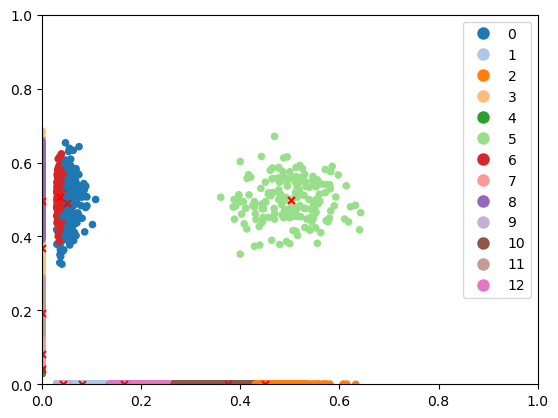

In [33]:
plt.figure()
unique_labels = np.unique(best_labels)
cmap = cm.get_cmap('tab20')
color_mapping = {label: cmap(i) for i, label in enumerate(unique_labels)}
colors = [color_mapping[label] for label in best_labels.detach().numpy()]

sc = plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c=colors, s=20)  # tab20
handles = [plt.Line2D([0], [0], marker='o', color='w', label=f"{label}",
                    markerfacecolor=color_mapping[label], markersize=10) 
        for label in unique_labels]
plt.legend(handles=handles)

plt.scatter(best_centers[:, 0], 
            best_centers[:, 1], color='red', marker='x', s=25)

plt.xlim([0,1])
plt.ylim([0,1])
plt.show()
plt.close()

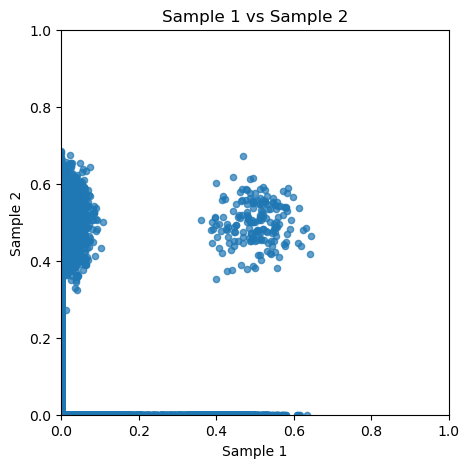

In [3]:
D = NV.shape[1]
pairs = np.triu_indices(D, k=1)  # Generate all unique pairs of samples (i, j)
vaf = NV/DP    


num_pairs = len(pairs[0])  # Number of unique pairs
# ncols = 3
ncols = min(3, num_pairs)
nrows = (num_pairs + ncols - 1) // ncols  # Calculate the number of rows

fig_width_per_plot = 5
fig_width = ncols * fig_width_per_plot
fig_height = 5 * nrows

fig, axes = plt.subplots(nrows, ncols, figsize=(fig_width, fig_height))
if num_pairs == 1:
    axes = [axes]
else:
    axes = axes.flatten()

idx = 0
for i, j in zip(*pairs):
    ax = axes[idx]  # Select the appropriate subplot
    x = vaf[:, i].numpy()
    y = vaf[:, j].numpy()

    ax.scatter(x, y, alpha=0.7, s = 20)

    ax.set_title(f"Sample {i+1} vs Sample {j+1}")
    ax.set_xlabel(f"Sample {i+1}")
    ax.set_ylabel(f"Sample {j+1}")
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    idx += 1

plt.show()

In [4]:
# Size of hitchhikers cluster
vaf = NV/DP
cond = vaf[np.where((vaf[:,0] > 0) & (vaf[:,0] < 0.2)& (vaf[:,1] > 0.4))]
cond.shape

torch.Size([1443, 2])

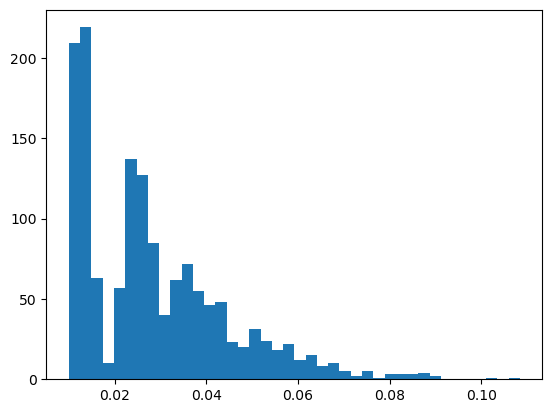

In [5]:
plt.hist(cond[:,0], bins = 40);

In [6]:
vaf = NV/DP
cond = np.where((vaf[:,0] > 0.3) & (vaf[:,1] > 0.3))[0]
print(cond.shape)
# plt.scatter(vaf[cond][:,0], vaf[cond][:,1])

(188,)


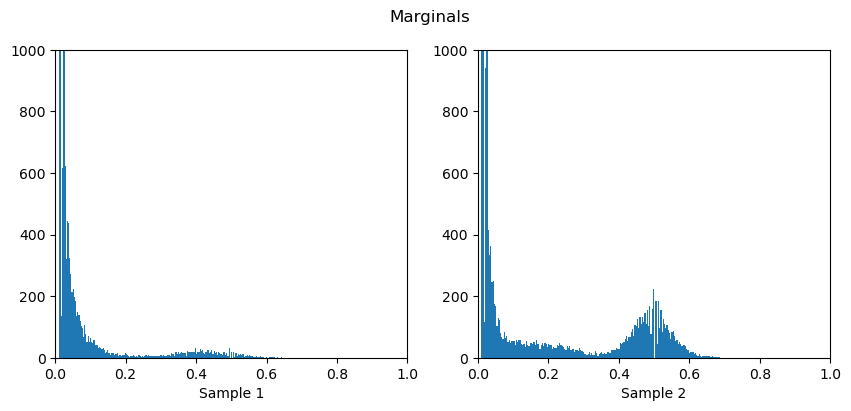

In [7]:
fig, axes = plt.subplots(1, D, figsize=(5*D, 4))
plt.suptitle("Marginals")

for i in range(D):
    x = vaf[:, i].numpy()
    x = x[x > 0]
    n_bins = int(np.ceil(np.sqrt(len(vaf))))
    axes[i].hist(x, bins = n_bins)    
    
    axes[i].set_xlabel(f"Sample {i+1}")
    axes[i].set_xlim([0,1])
    axes[i].set_ylim([0,1000])
plt.show()

In [ ]:
torch.tensor([[0.03, 8.9043e-03],
        [1.0415e-02, 5.0000e-01],
        [4.5754e-08, 5.0000e-01],
        [4.5754e-08, 2.3000e-01],
        [4.5940e-01, 4.9474e-01],
        [2.30338e-01, 1.0000e-10],
        [8.8476e-08, 1.0415e-02]])

tensor([[1.0415e-02, 8.9043e-03],
        [1.0415e-02, 5.0000e-01],
        [4.5754e-08, 5.0000e-01],
        [4.5754e-08, 2.3000e-01],
        [4.5940e-01, 4.9474e-01],
        [2.3034e-01, 1.0000e-10],
        [8.8476e-08, 1.0415e-02]])

In [5]:
tau = 0.2
delta = torch.tensor([[[0.1000, 0.2000, 0.7000],
         [0.2000, 0.7000, 0.1000]],

        [[0.7000, 0.2000, 0.1000],
         [0.1000, 0.2000, 0.7000]],

        [[0.1000, 0.2000, 0.7000],
         [0.2000, 0.7000, 0.1000]],

        [[0.2000, 0.7000, 0.1000],
         [0.1000, 0.2000, 0.7000]],

        [[0.2000, 0.7000, 0.1000],
         [0.2000, 0.7000, 0.1000]]])
# print(delta)
softmax_delta = torch.softmax(delta / tau, dim=-1)
print(softmax_delta)

tensor([[[0.0440, 0.0725, 0.8835],
         [0.0725, 0.8835, 0.0440]],

        [[0.8835, 0.0725, 0.0440],
         [0.0440, 0.0725, 0.8835]],

        [[0.0440, 0.0725, 0.8835],
         [0.0725, 0.8835, 0.0440]],

        [[0.0725, 0.8835, 0.0440],
         [0.0440, 0.0725, 0.8835]],

        [[0.0725, 0.8835, 0.0440],
         [0.0725, 0.8835, 0.0440]]])


In [7]:
vaf = NV/DP
cond = np.where((vaf[:,0] >= 0.03) & (vaf[:,0] < 0.2) & (vaf[:,1] == 0))[0]
print(cond.shape)

(1212,)


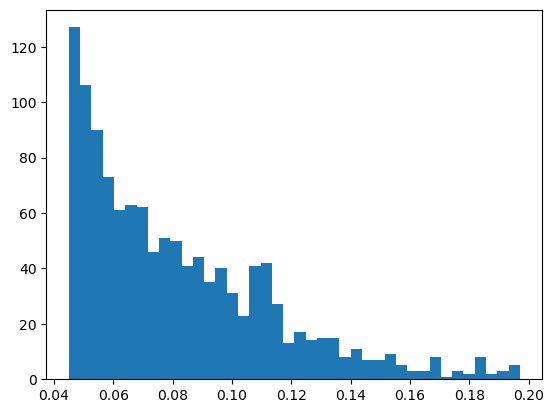

In [8]:
plt.hist(vaf[cond,0], bins = 40);

No GPU available.
RUN WITH K = 7 AND SEED = 42
Minimum detected VAF: tensor(0.0300)


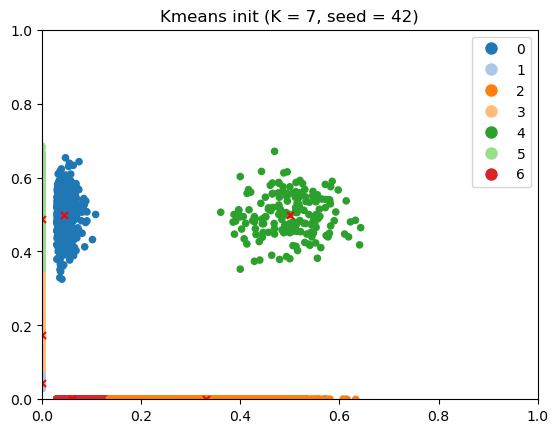

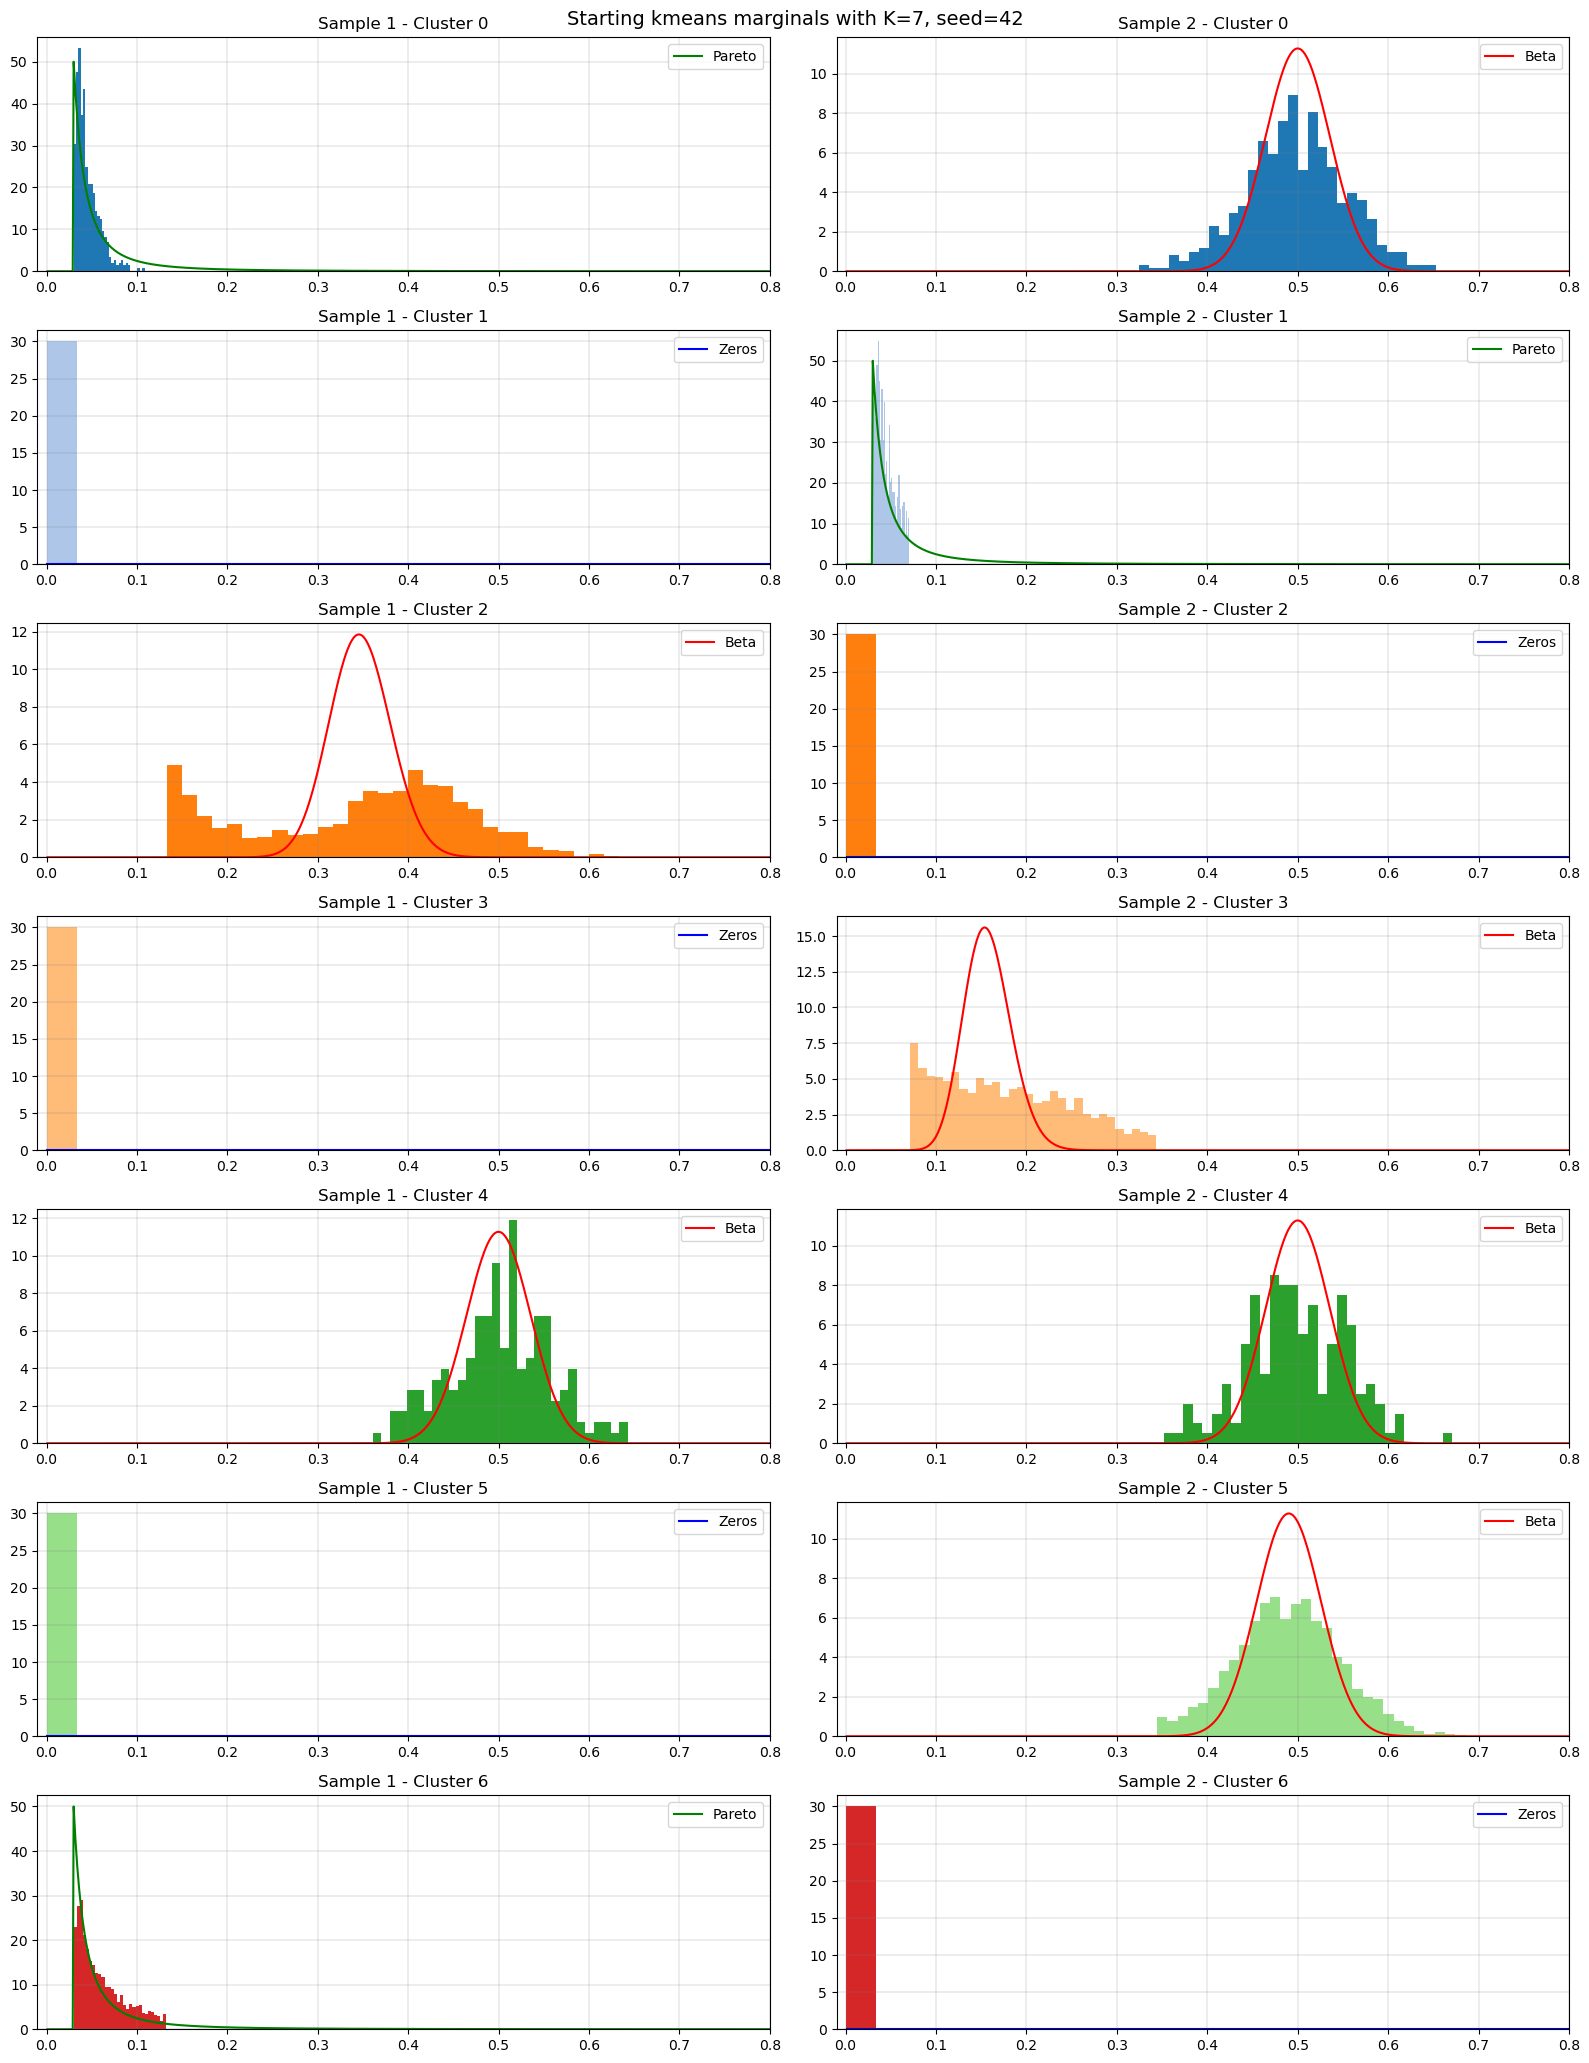

Iteration 0: Loss = 1093877585.7221792
Iteration 50: Loss = 969666528.2287285
Iteration 100: Loss = 947315329.2705936
Iteration 150: Loss = 939522103.5432808
Iteration 200: Loss = 935750960.5926812
Iteration 250: Loss = 933478954.8058608
Iteration 300: Loss = 932100882.2588618
Iteration 350: Loss = 931297751.2053787
Iteration 400: Loss = 930746429.7256393
Iteration 450: Loss = 930331385.7059097
Iteration 500: Loss = 930004334.1753632
Iteration 550: Loss = 929739804.0631615


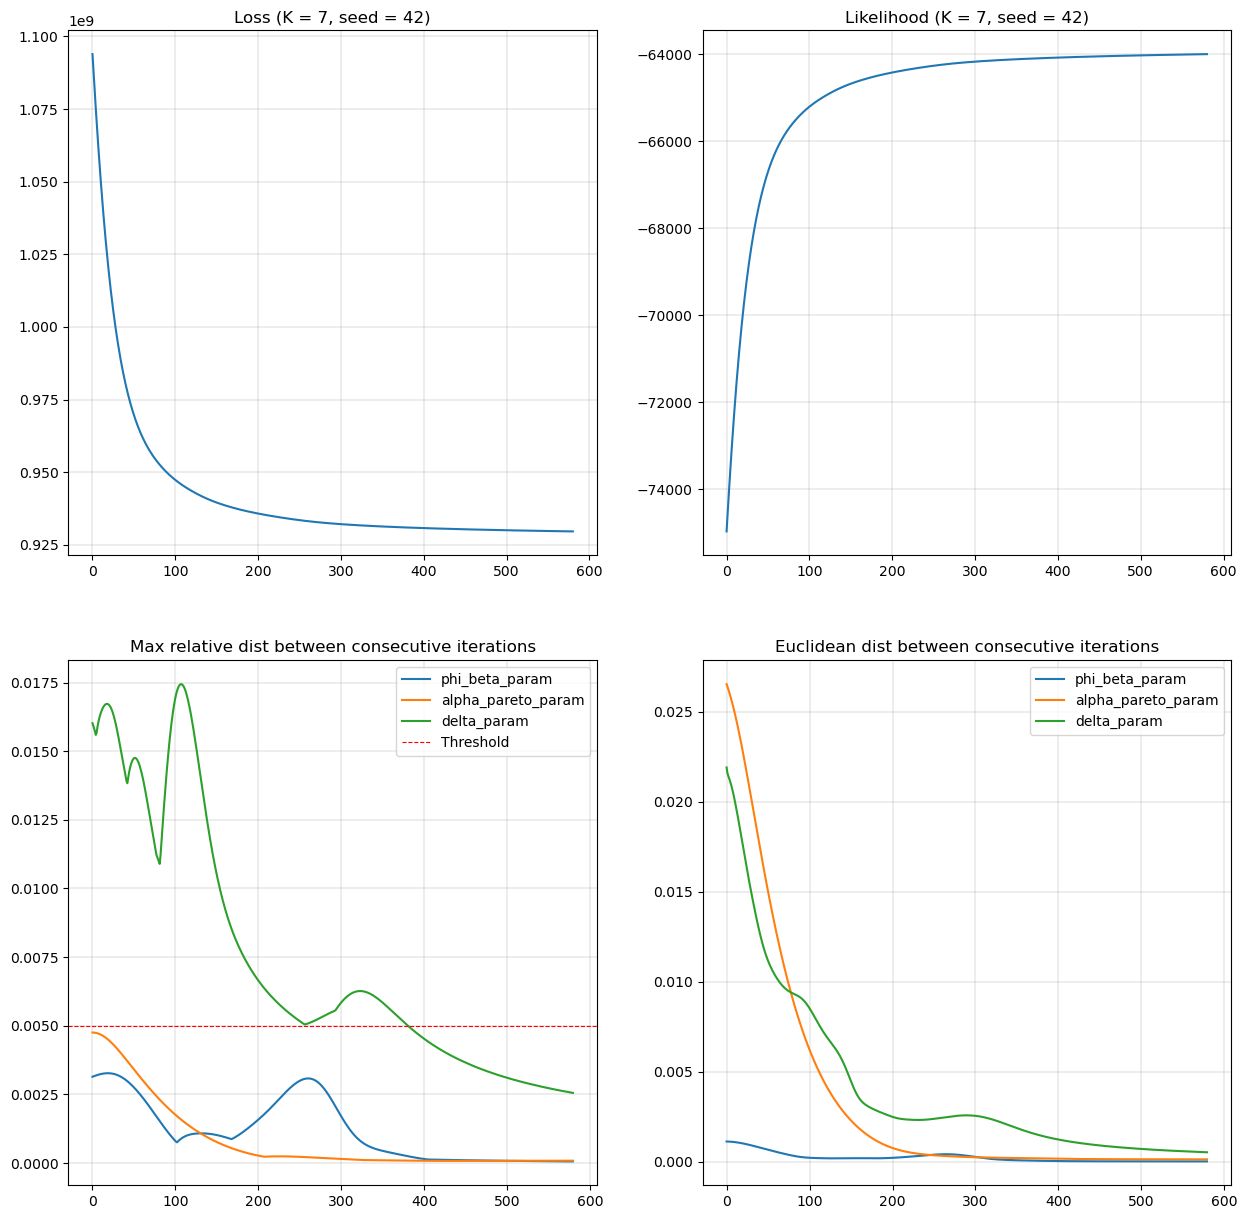

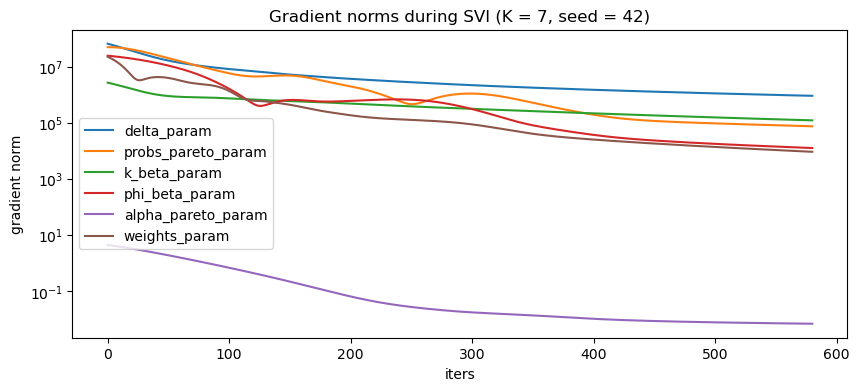

Inference lk:  -63992.80161684393
Final lk (integr):  tensor(-64900.8633, grad_fn=<SumBackward0>)
n_params:  105
n:  tensor(14525)
lk:  tensor(-64900.8633, grad_fn=<SumBackward0>)
bic: 130808.0078125 



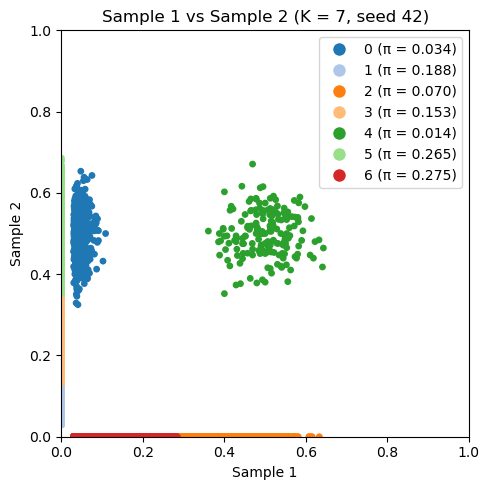

Time taken for K = 7 and seed = 42: 36.862 seconds


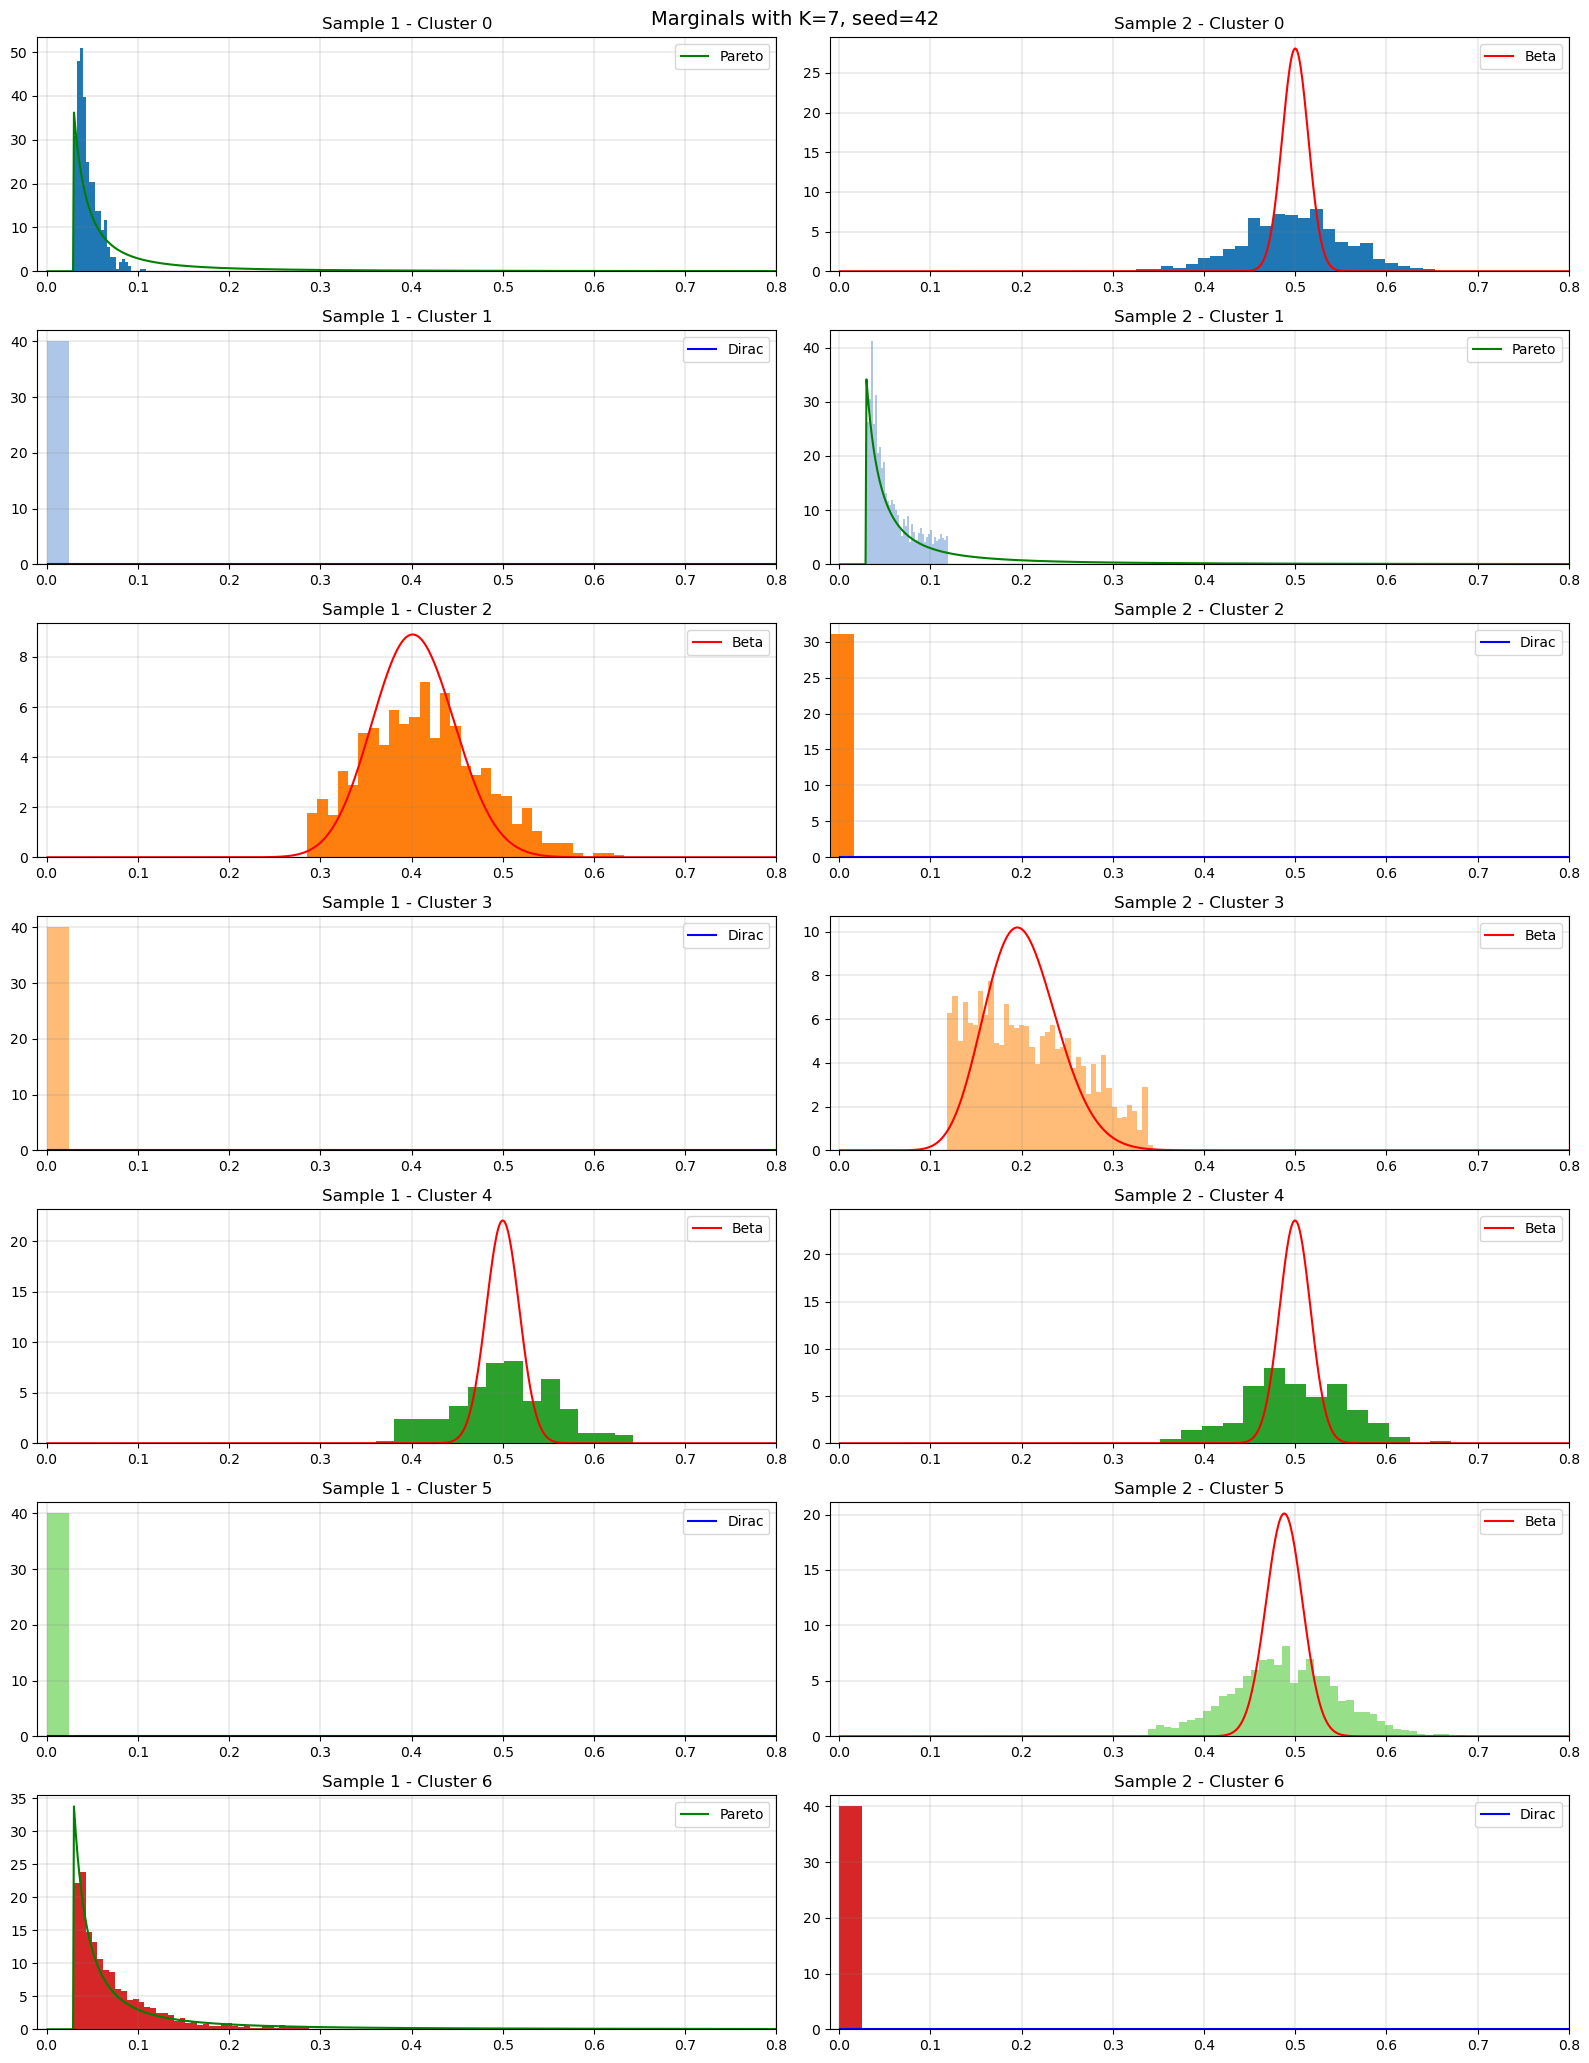

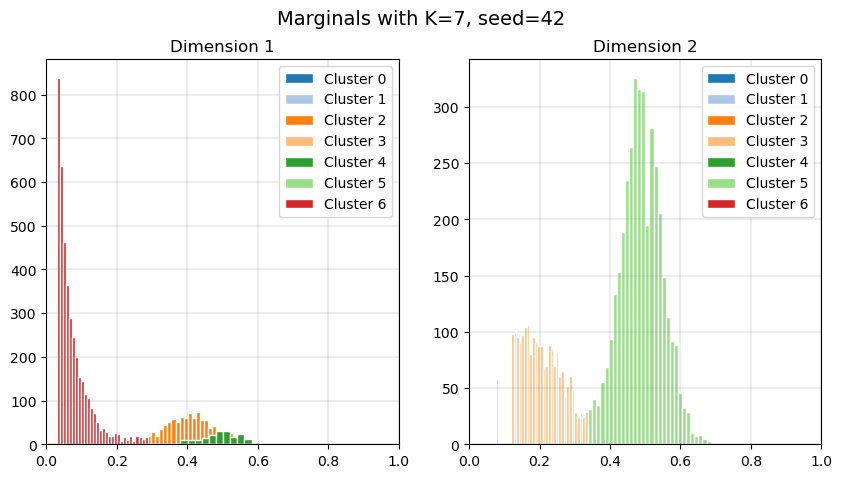

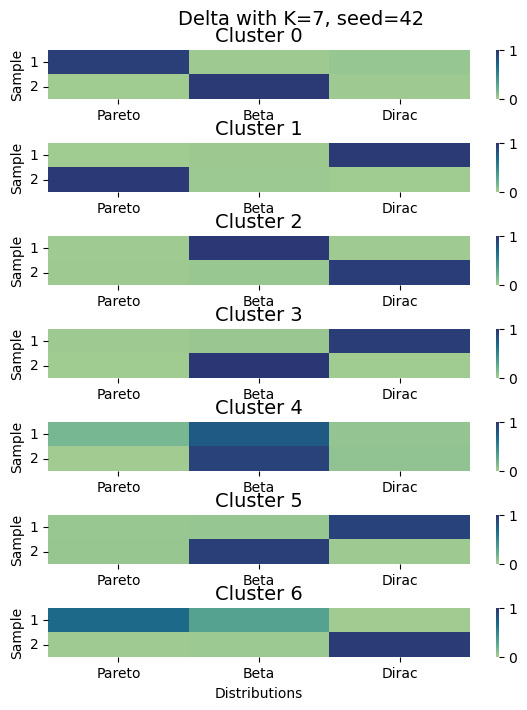

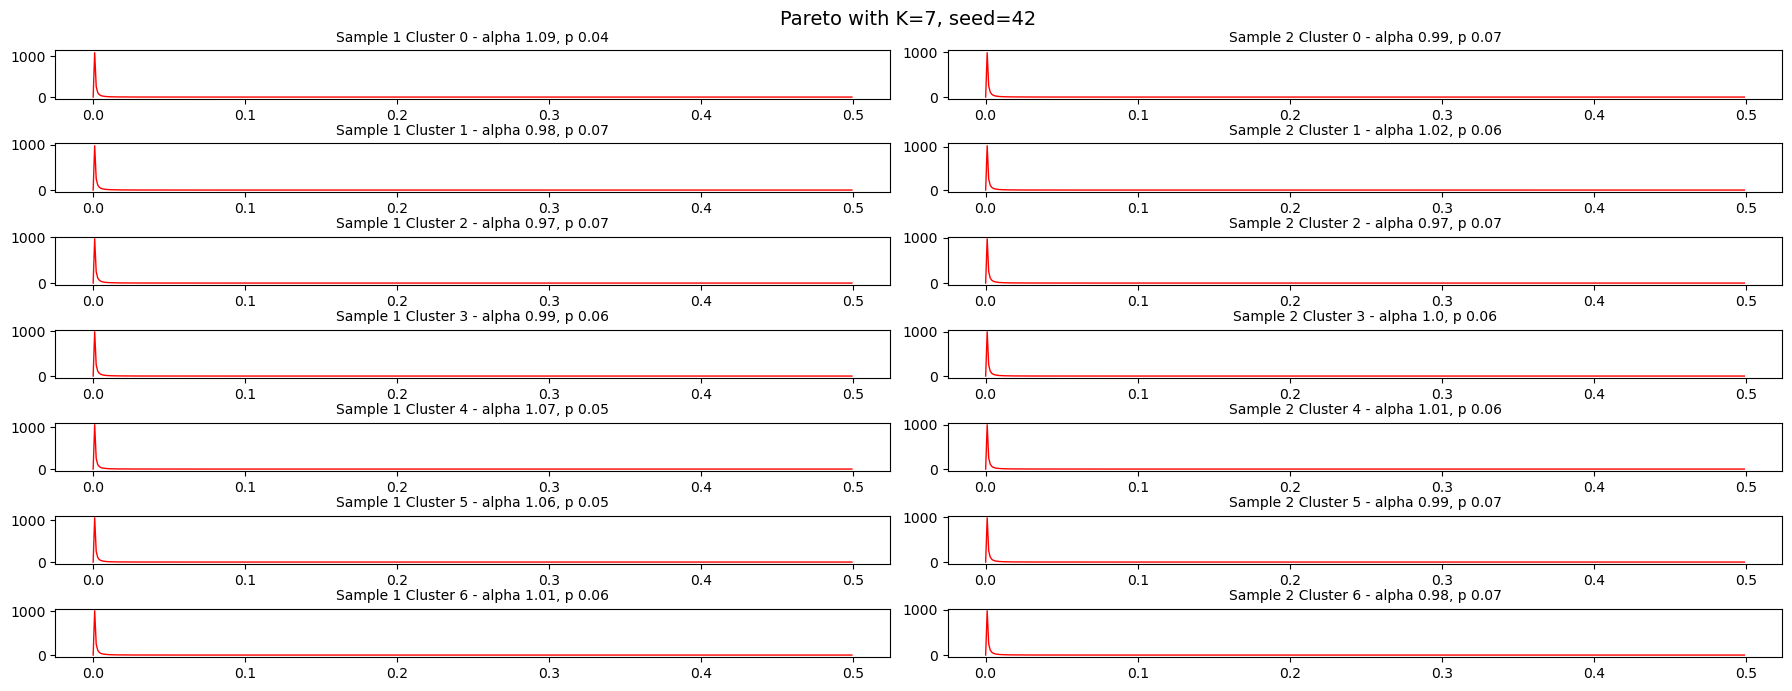

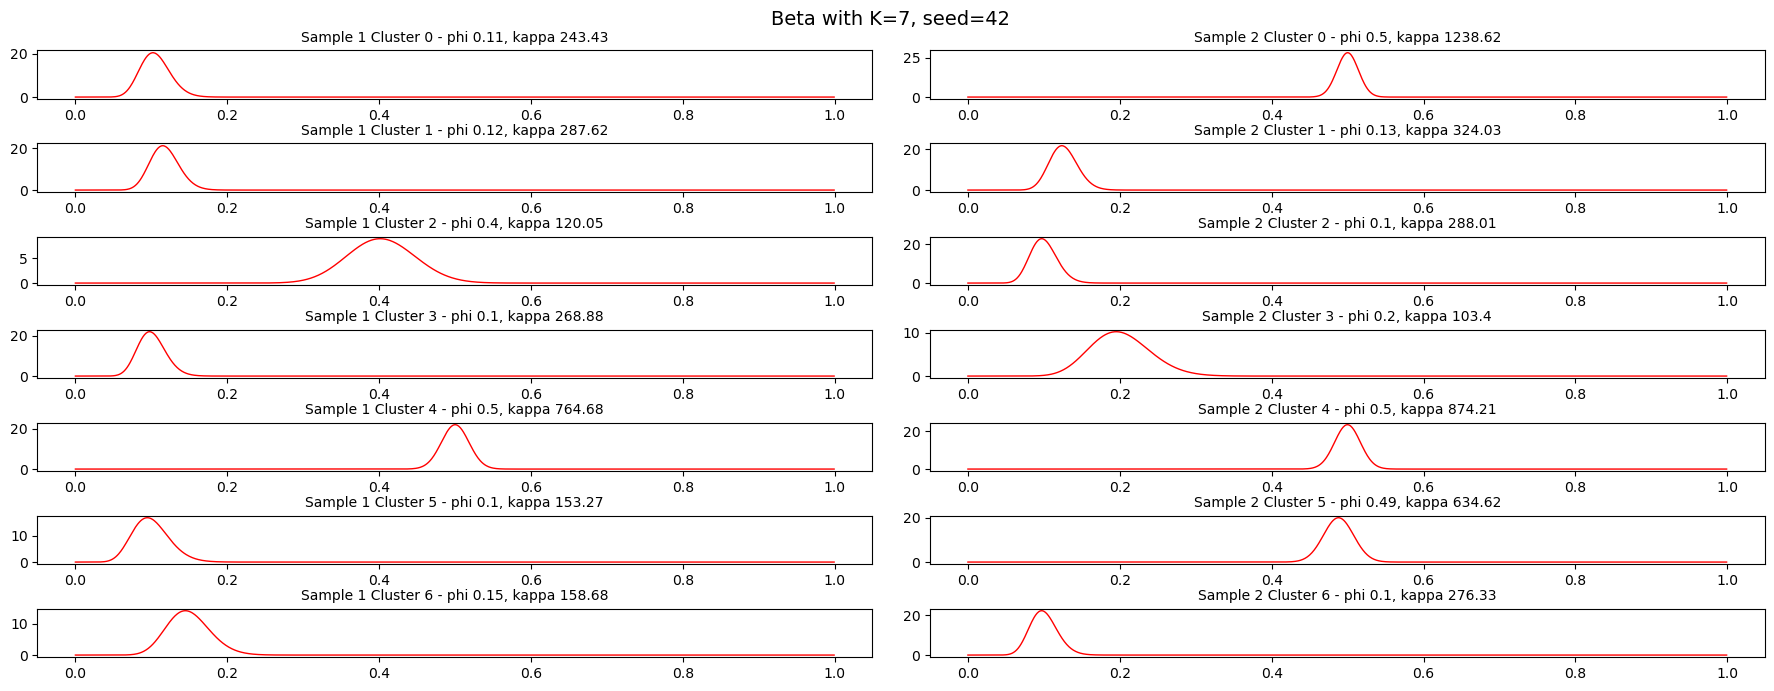

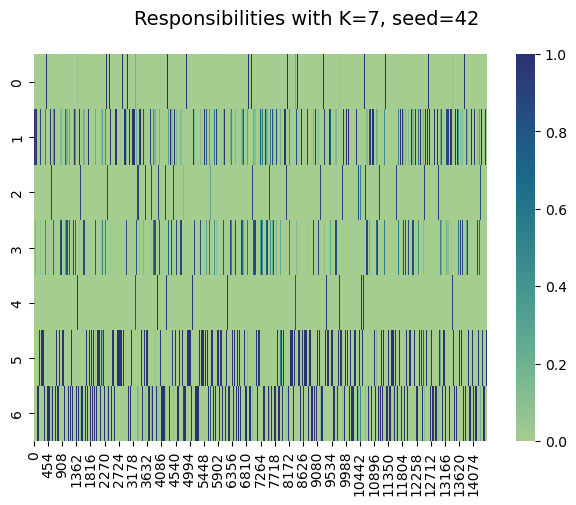

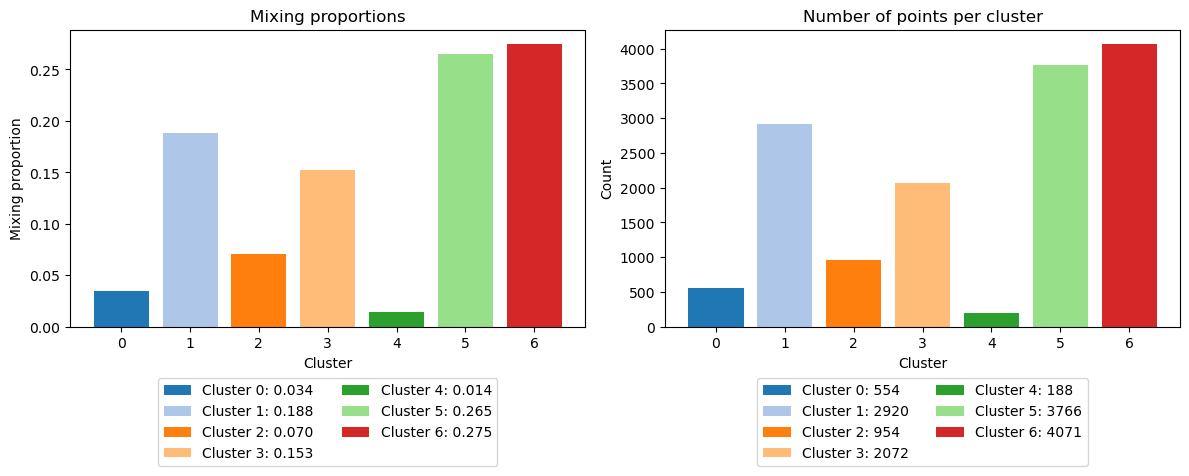

Selected number of clusters is 7 with seed 42


In [18]:
K_list = [7]
seed_list = [42]
mb_list, best_K, best_seed = model_mobster_mv.fit(NV, DP, num_iter = 2000, K = K_list, seed = seed_list, lr = 0.01, purity = purity)#, choice_init_centers = 'kmeans')

In [5]:
def get_a_beta(phi, kappa):
    return phi * (kappa)

def get_b_beta(phi, kappa):
    return (1-phi) * (kappa)

In [10]:
def beta_lk(mb,idx,  d, a_beta, b_beta):
    """
    Compute beta-binomial likelihood for a single dimension of a single cluster.
    """
    betabin = dist.BetaBinomial(a_beta, b_beta, total_count=mb.DP[idx,d]).log_prob(mb.NV[idx,d])
    return betabin # simply does log(weights) + log(density)

def expon_lk(mb, idx,  d):
    """
    Compute exponential likelihood for a single dimension of a single cluster.
    """
    exp = dist.Exponential(mb.rate_expon).log_prob(mb.NV[idx,d])
    return exp # simply does log(weights) + log(density)

def pareto_binomial_pmf_samp(mb, NV, DP, alpha, probs_pareto):
    binom = dist.Binomial(total_count=DP, probs=probs_pareto).log_prob(NV)
    return binom  # Convert the result to a list

def pareto_lk_samp(mb, idx, d, alpha, probs_pareto):
    paretobin = pareto_binomial_pmf_samp(mb, NV=mb.NV[idx, d], DP=mb.DP[idx, d], alpha=alpha, probs_pareto = probs_pareto)
    return paretobin # tensor of len N (if D = 1, only N)

In [22]:
np.where((vaf[:,0] > 0.3) & (vaf[:,1] > 0.3))

(array([  831,   855,  1353,  1397,  1528,  1704,  2292,  2410,  2738,
         2794,  3289,  3303,  3409,  3527,  3536,  3917,  4135,  4223,
         4271,  4302,  4406,  4631,  4970,  5349,  5383,  5435,  5632,
         6271,  6442,  6520,  6664,  7542,  7608,  7902,  8382,  8655,
         8742,  9573,  9695, 10118, 10327, 10342, 10469, 10475, 10516,
        10821, 10999, 11105, 11427, 11576, 11621, 11685, 11877, 11966,
        12059, 12068, 12148, 12363, 12921, 13164, 13742, 13792, 13816,
        14185, 14201, 14476, 14804, 14829, 14995, 15083, 15204, 15603,
        15732, 15753, 15774, 16000, 16191, 16466, 16556, 16883, 17225,
        17417, 17486, 17646, 18103, 18224, 18314, 18417, 18425, 18553,
        18981, 19023, 19396, 19717, 20061, 20213, 20717, 20740, 21025,
        21077, 21117, 21525, 21532, 21746, 21822, 21928, 22069, 22450,
        22975, 23045, 23226, 23255, 23358, 23386, 23408, 23516, 23755,
        24020, 24082, 24801, 24835, 25124, 25269, 25593, 25608, 25731,
      

In [11]:
mb = mb_list[0]
s = 2
c = 4
d = s -1
vaf = NV[:,d]/DP[:,d]
labels = mb.params['cluster_assignments']
delta = mb.params['delta_param']
alpha = mb.params['alpha_pareto_param'][c,d]
print(alpha)
phi = mb.params['phi_beta_param'][c,d]
# phi = 0.5
print(phi)
kappa = mb.params['k_beta_param'][c,d]
a_beta = get_a_beta(phi, kappa)
b_beta = get_b_beta(phi, kappa)
probs_pareto = mb.params['probs_pareto_param'][c,d]
# idx = np.where((labels == c) )[0]
vaf = NV/DP
# idx = np.where((vaf[:,0] > 0.3) & (vaf[:,1] > 0.3))
idx = np.where((labels == c))[0]
print("Pareto integr: ", pareto_lk(mb, idx, d, alpha).sum())
print("Pareto samp: ", pareto_lk_samp(mb, idx, d, alpha, probs_pareto).sum())
print("Beta: ",beta_lk(mb, idx,  d, a_beta, b_beta).sum())


tensor(1.0699, grad_fn=<SelectBackward0>)
tensor(0.1359, dtype=torch.float64, grad_fn=<SelectBackward0>)
Pareto integr:  tensor(-7088.6987)
Pareto samp:  tensor(-8755.7471, grad_fn=<SumBackward0>)
Beta:  tensor(-8083.0137, dtype=torch.float64, grad_fn=<SumBackward0>)


### Precomputed paretobinomial likelihood

In [74]:
alpha_grid = torch.arange(0.5, 3, 0.02)
# alpha_grid = torch.linspace(0.5, 3, 100)
alpha_grid.shape

torch.Size([125])

In [75]:
pareto_L = 0.05
pareto_H = purity/2
def pareto_binomial_pmf(NV, DP, alpha):
    integration_points=2000
    # Generate integration points across all rows at once
    t = torch.linspace(pareto_L, pareto_H, integration_points).unsqueeze(0)  # Shape (1, integration_points)
    NV_expanded = NV.unsqueeze(-1)  # Shape (NV.shape[0], 1)
    DP_expanded = DP.unsqueeze(-1)  # Shape (NV.shape[0], 1)
    binom_vals = dist.Binomial(total_count=DP_expanded, probs=t).log_prob(NV_expanded).exp()
    pareto_vals = BoundedPareto(pareto_L, alpha, pareto_H).log_prob(t).exp()  # Shape (1, integration_points)
    integrand = binom_vals * pareto_vals

    pmf_x = torch.trapz(integrand, t, dim=-1).log()  # Shape (NV.shape[0], NV.shape[1])

    return pmf_x.tolist()  # Convert the result to a list

def pareto_lk_integr(d, alpha):
    paretobin = torch.tensor(pareto_binomial_pmf(NV=NV[:, d], DP=DP[:, d], alpha=alpha))
    return paretobin # tensor of len N (if D = 1, only N)
    
# alpha_grid = torch.linspace(0.5, 3, 100)
alpha_grid = torch.arange(0.5, 3, 0.02)
precomputed_likelihoods = {}
i = 0
for alpha in alpha_grid:
    likelihoods_per_alpha = []
    print(i)
    i+= 1
    for d in range(NV.shape[1]):  # Loop over each column of NV and DP
        likelihood = pareto_lk_integr(d, alpha)
        likelihoods_per_alpha.append(likelihood)
    precomputed_likelihoods[alpha.item()] = torch.stack(likelihoods_per_alpha, dim=1)  # Combine across columns
# paretobin = torch.tensor(pareto_binomial_pmf(NV=NV[:, d], DP=DP[:, d], alpha=alpha))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


KeyboardInterrupt: 

In [70]:
precomputed_likelihoods

{0.5: tensor([[-5.4943, -5.4238, -6.0107],
         [-7.5099, -5.8450, -6.6564],
         [-6.4032, -5.9556, -5.8925],
         ...,
         [-3.5488, -3.0800, -5.0260],
         [-2.9765, -3.1750, -5.2728],
         [-3.5762, -5.0544, -4.9152]]),
 0.5252525210380554: tensor([[-5.4960, -5.4276, -6.0168],
         [-7.5173, -5.8506, -6.6634],
         [-6.4098, -5.9614, -5.8979],
         ...,
         [-3.5173, -3.0395, -5.0219],
         [-2.9375, -3.1360, -5.2709],
         [-3.5463, -5.0502, -4.9089]]),
 0.5505050420761108: tensor([[-5.5000, -5.4336, -6.0251],
         [-7.5270, -5.8584, -6.6726],
         [-6.4188, -5.9696, -5.9056],
         ...,
         [-3.4881, -3.0012, -5.0202],
         [-2.9008, -3.0993, -5.2714],
         [-3.5186, -5.0483, -4.9049]]),
 0.5757575631141663: tensor([[-5.5061, -5.4417, -6.0356],
         [-7.5388, -5.8684, -6.6839],
         [-6.4298, -5.9799, -5.9154],
         ...,
         [-3.4609, -2.9651, -5.0206],
         [-2.8661, -3.0647, -5.2740],

In [71]:
def pareto_binomial_pmf(NV, DP, alpha):
    integration_points = 2000
    # Generate integration points for Pareto distribution
    t = torch.linspace(pareto_L, pareto_H, integration_points).unsqueeze(0)  # Shape (1, integration_points)
    
    # Expand NV and DP to align with integration points
    NV_expanded = NV.unsqueeze(-1)  # Shape (N, D, 1) if NV is (N, D)
    DP_expanded = DP.unsqueeze(-1)  # Shape (N, D, 1) if DP is (N, D)
    
    # Compute Binomial probabilities
    binom_vals = dist.Binomial(total_count=DP_expanded, probs=t).log_prob(NV_expanded).exp()  # Shape (N, D, integration_points)
    
    # Compute Pareto probabilities
    pareto_vals = BoundedPareto(pareto_L, alpha, pareto_H).log_prob(t).exp()  # Shape (1, integration_points)
    
    # Compute integrand
    integrand = binom_vals * pareto_vals  # Shape (N, D, integration_points)
    
    # Perform numerical integration over the last dimension
    pmf_x = torch.trapz(integrand, t, dim=-1).log()  # Shape (N, D)
    
    return pmf_x

alpha_grid = torch.linspace(0.5, 3, 100)  # Define range of alpha values
precomputed_likelihoods_new = {}
i = 0
# Loop over alpha values
for alpha in alpha_grid:
    print(i)
    # Compute likelihoods for all columns of NV and DP at once
    likelihoods = pareto_binomial_pmf(NV, DP, alpha)
    
    # Store the likelihoods for the current alpha
    precomputed_likelihoods_new[alpha.item()] = likelihoods
    i+=1


0
1
2
3


KeyboardInterrupt: 

In [78]:
print(precomputed_likelihoods[0.5])
print(precomputed_likelihoods_new[0.5])

tensor([[-5.4943, -5.4238, -6.0107],
        [-7.5099, -5.8450, -6.6564],
        [-6.4032, -5.9556, -5.8925],
        ...,
        [-3.5488, -3.0800, -5.0260],
        [-2.9765, -3.1750, -5.2728],
        [-3.5762, -5.0544, -4.9152]])
tensor([[-5.4943, -5.4238, -6.0107],
        [-7.5099, -5.8450, -6.6564],
        [-6.4032, -5.9556, -5.8925],
        ...,
        [-3.5488, -3.0800, -5.0260],
        [-2.9765, -3.1750, -5.2728],
        [-3.5762, -5.0544, -4.9152]])


In [85]:
alpha = 1.08

In [101]:
alpha = mb_list[0].params['alpha_pareto_param']
paretobin = torch.zeros((alpha.shape[0], NV.shape[0],NV.shape[1]))
# self.precompute_paretobin_lk() questa è già stata chiamata all'inizio, prima di iniziare l'inferenza
for k in range(alpha.shape[0]):
    for d in range(alpha.shape[1]):
        alpha_grid = torch.tensor(list(precomputed_likelihoods.keys()))
        closest_alpha_idx = (torch.abs(alpha_grid - alpha[k,d])).argmin()
        closest_alpha = alpha_grid[closest_alpha_idx].item()
        paretobin[k,:,d] = precomputed_likelihoods[closest_alpha][:,d]
print(paretobin.shape)

torch.Size([5, 10000, 3])


In [88]:
alpha_grid = torch.tensor(list(precomputed_likelihoods.keys()))
closest_alpha_idx = (torch.abs(alpha_grid - alpha)).argmin()
closest_alpha = alpha_grid[closest_alpha_idx].item()
precomputed_likelihoods[closest_alpha]
print(closest_alpha)
print(precomputed_likelihoods[closest_alpha].shape)

1.0808080434799194
torch.Size([10000, 3])
